Importing libraries, defining model, some functions....

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, Grayscale
import torchvision.transforms.functional as TF
import numpy as np
import skimage
import matplotlib.pyplot as plt
import random
import pandas as pd

import urllib.request
import time
from google.colab import files


In [ ]:
def get_mgrid(sidelen, dim=2, depth=1):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])+(torch.linspace(-1, 1, steps=depth),)
    print(tensors[0].size(), tensors[1].size(), tensors[2].size())
    print(len(torch.meshgrid(*tensors)))
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    print("Mgrid step 2: ", mgrid.size())
    mgrid = mgrid.reshape(depth, sidelen**2, dim+1)
    print("Mgrid step 3: ", mgrid.size())
    return mgrid

Definition of the model

In [ ]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        #output=gradient(output, coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

Creating all the images: color and black_and_white


1.   download images
2.   resize each
3.   save each in RGB and gray (in 2 folders), with new name

To take all images urls from google images:

- make a search on google iamge
- load all the iamges in the page: go to the very bottom of the page with the cursor
- open the navigator console
- insert the following code inside the console: wil return a csv of all the urls of images

urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

- finally, in the next cells we upload the file to the notebook: the commmand to upload a file depends whether it is on google colab or something else

In [ ]:
!rm -r imgs/*
!ls

rm: cannot remove 'imgs/*': No such file or directory
sample_data


In [ ]:
  !mkdir "imgs"
!mkdir "imgs/temp"
!mkdir "imgs/rgb"
!mkdir "imgs/bw"

In [ ]:
!ls imgs/rgb

In [ ]:
uploaded = files.upload()


Saving all_urls.csv to all_urls.csv


In [ ]:
all_urls=pd.read_csv("all_urls.csv", header=None)

In [ ]:
all_urls=list(all_urls.iloc[:, 0])

In [ ]:
len(all_urls)

5322

Important: defining the size of each image. Beware: the size of the model is porportionate to sidelength**4. Sidelength=128 requires 5Gb for defining the model!


In [ ]:
sidelength=32

We store all the images on local, with the correct size, in RGB and BW

In [ ]:

transform1 = Compose([
        Resize((sidelength, sidelength)),
        #ToTensor(),
        #Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])

transform2 = Compose([
        Resize((sidelength, sidelength)),
        #ToTensor(),
        Grayscale(1),
        #Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])

index=0
for i, url in enumerate(all_urls):
  #we download the image
  filename = str(index)+'.jpg'
  try:
    urllib.request.urlretrieve(url, "imgs/temp/temp.jpg")
    #and we resize, save in correct folder
    img = Image.fromarray(np.array(Image.open("imgs/temp/temp.jpg")))
    img=transform1(img)
    if img.mode=="RGB":
      img.save("imgs/rgb/"+filename)
      #and convert to BW and store in correct folder
      img=transform2(img)
      img.save("imgs/bw/"+filename)
      index+=1
    else:
      print("one non-RGB image: "+url)
  except Exception:
    print("one unfound image: "+url)

one unfound image: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSEWdS788cBe0xogfqoTGRYDVyQXQ7B42gnzg&usqp=CAU
one non-RGB image: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTxjDLmgjLheVwidN_mW2N5wl9D4yIuMbyGdw&usqp=CAU
one non-RGB image: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQyUIQ5XxOld4fVSMdUUTJm7ee3iMeZ2yXRDg&usqp=CAU
one unfound image: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTMlxTR04nYO_rrDtB4WB-2padkPKjf1QQ0Ow&usqp=CAU
one non-RGB image: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT-YBXPpA7R0huqN_htGd9_eiZLCZpZxD6ehQ&usqp=CAU
one non-RGB image: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTKBNS0EhK-0pxsCKrYeeIK8bHmqpnDu_cXAQ&usqp=CAU
one non-RGB image: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTSaPo0D1vHoyqyAG9WMUrbpjWgTL61LthLYg&usqp=CAU
one non-RGB image: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRouHgYoZ7AaIjasL_iL7opuZu4xMbwLMKb0w&usqp=CAU
one non-RGB image: https://encrypted-tbn0.gstati

In [ ]:
nb_images=index
nb_images

5313

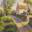

In [ ]:

Image.open("imgs/rgb/2.jpg")

We create a transform that takes a PIL gray (1 channel) image, and converts it into a 1D tensor

In [ ]:
def transform_reshape(img, sidelength=sidelength):
  transform = Compose([
        ToTensor(),
        #Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
  img=transform(img)
  img=img.reshape(-1)
  return img


In [ ]:
img=transform_reshape(Image.open("imgs/bw/1.jpg"))
print(img, img.size())

tensor([0.9922, 1.0000, 0.9765,  ..., 0.9804, 1.0000, 1.0000]) torch.Size([1024])


<class 'numpy.ndarray'> (32, 32, 3)


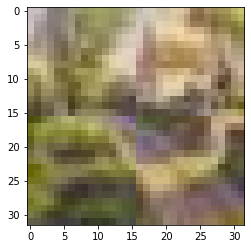

In [ ]:
image_index=2

out=transform_reshape(Image.open("imgs/rgb/"+str(image_index)+".jpg"))
res=out.reshape(3, sidelength, sidelength).detach().permute(1, 2, 0).numpy()
print(type(res), res.shape)
plt.imshow(out.reshape(3,sidelength,sidelength).detach().permute(1, 2, 0).numpy())
plt.show()

In [ ]:
#verifying that all images are correct in sizes
for i in range(nb_images):
  img_aim_output=transform_reshape(Image.open("imgs/rgb/"+str(i)+".jpg"))
  #print(i, ": ", img_aim_output.size())
  if img_aim_output.size()[0]!=3*sidelength**2:
    print(i, ": ", img_aim_output.size())

We create the model, and train it


In [ ]:
img_siren = Siren(in_features=sidelength**2, out_features=3*sidelength**2, hidden_features=4*sidelength**2, 
                  hidden_layers=2, outermost_linear=True)
#img_siren.cuda()

In [ ]:
losses=[]

Step 0, Total loss 0.009389


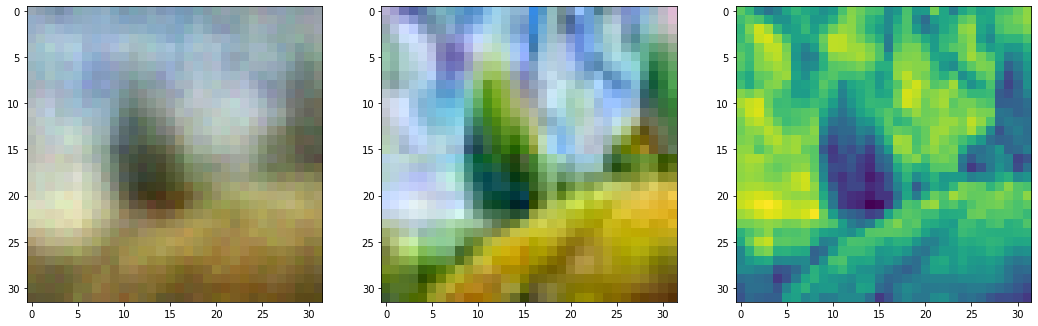

Step 10, Total loss 0.011607


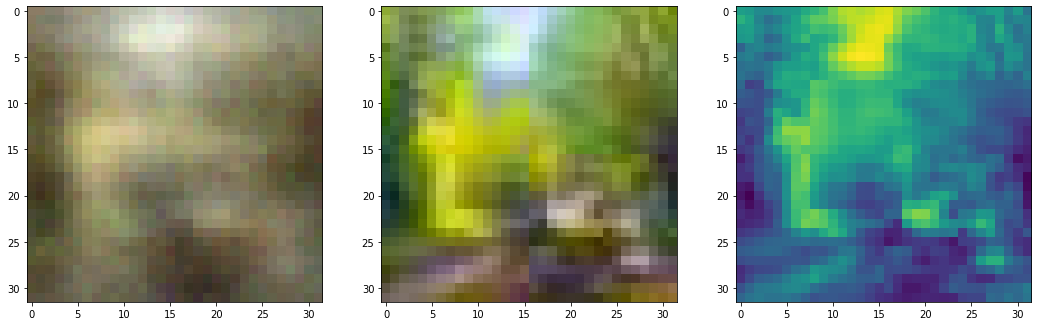

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 20, Total loss 0.009892


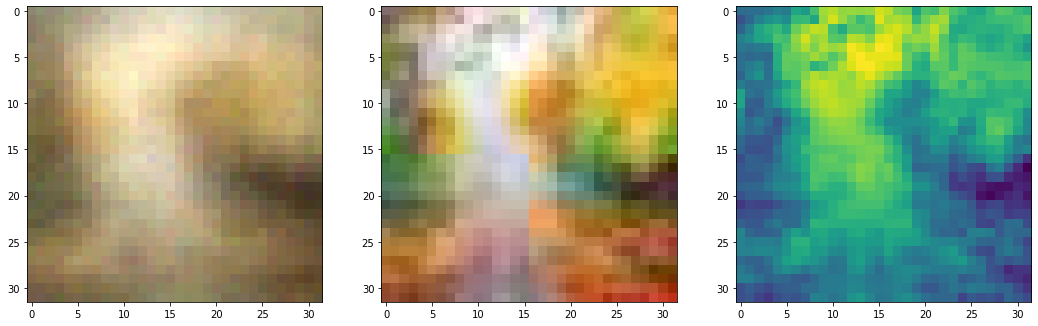

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 30, Total loss 0.009963


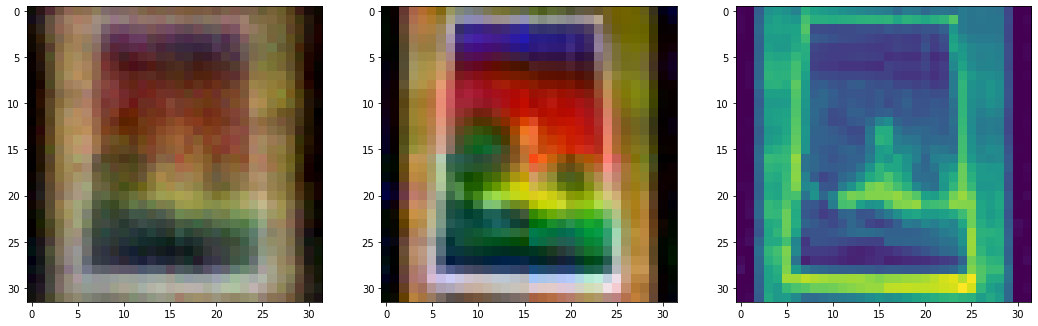

Step 40, Total loss 0.009802


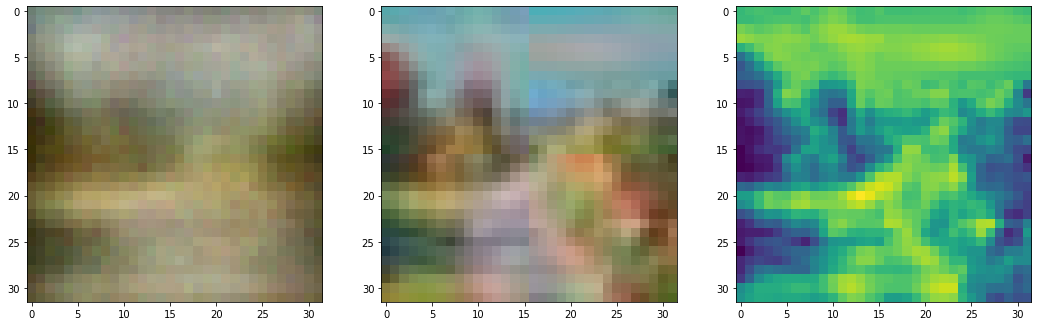

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 50, Total loss 0.008158


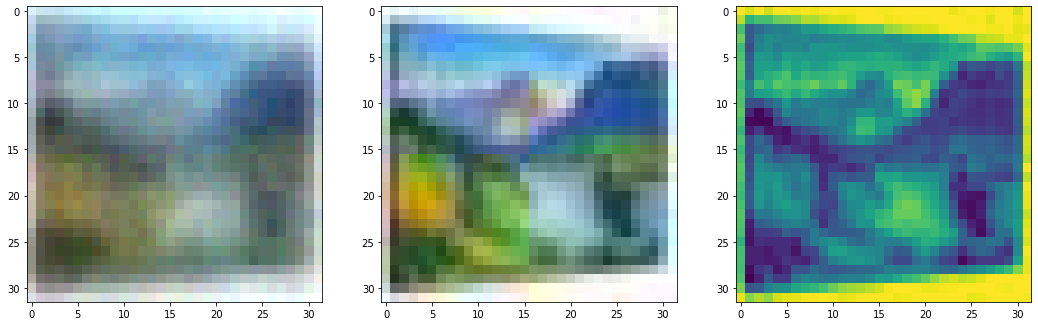

Step 60, Total loss 0.010575


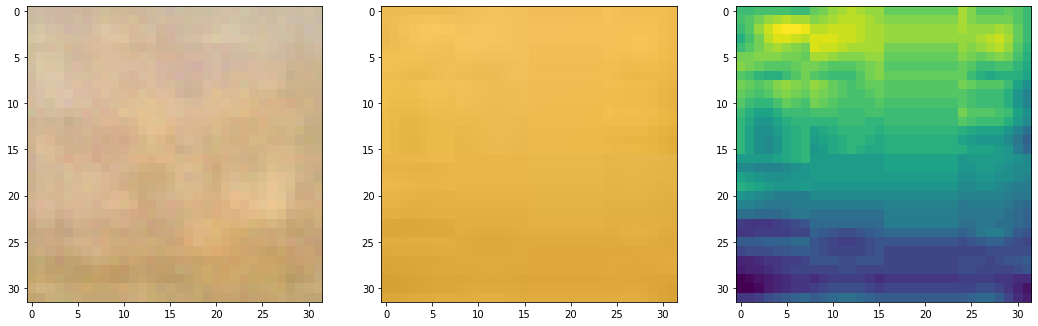

Step 70, Total loss 0.008538


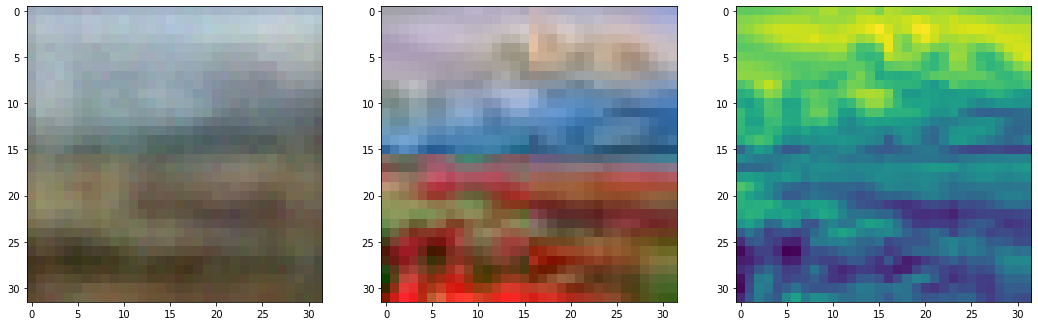

Step 80, Total loss 0.009470


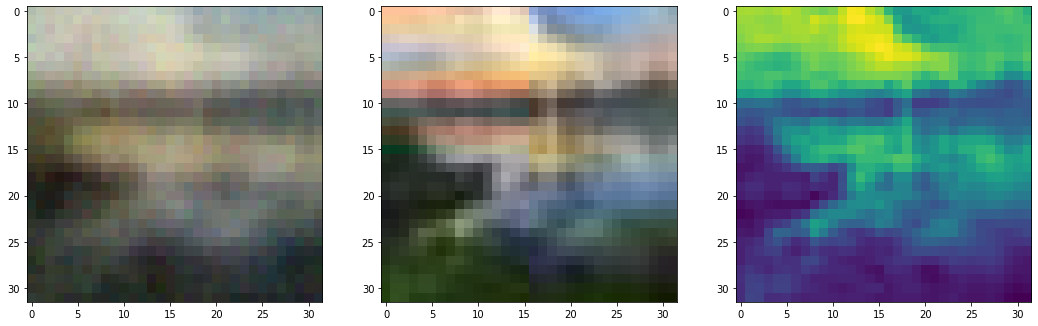

Step 90, Total loss 0.007324


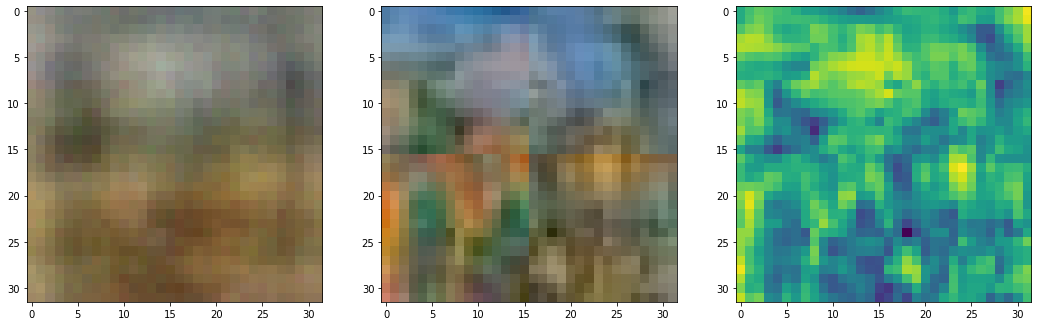

Step 100, Total loss 0.008466


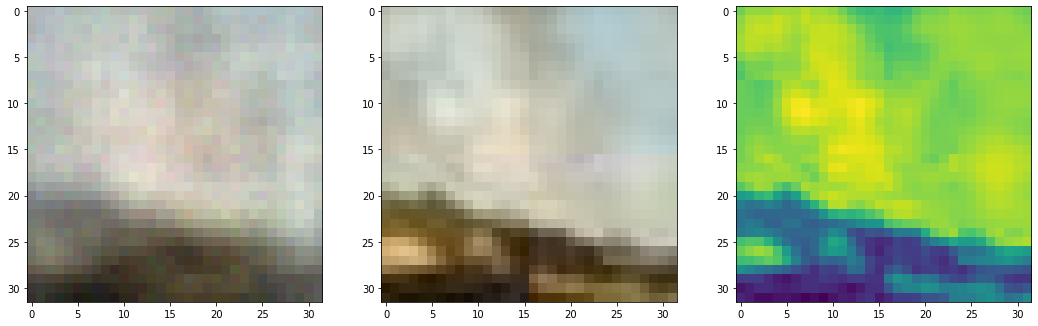

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 110, Total loss 0.007985


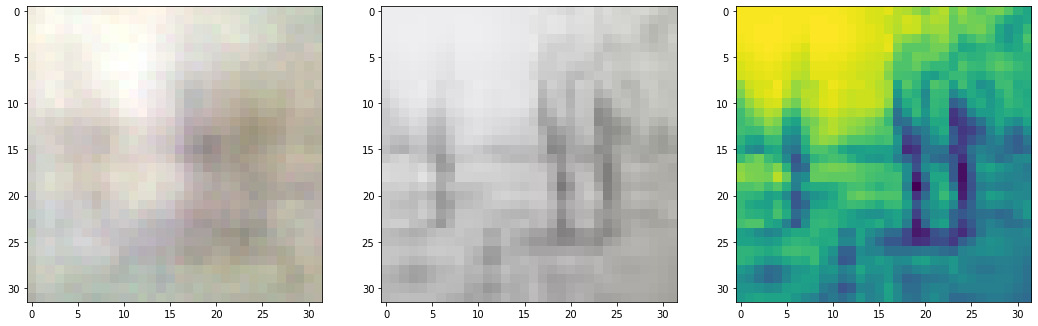

Step 120, Total loss 0.007990


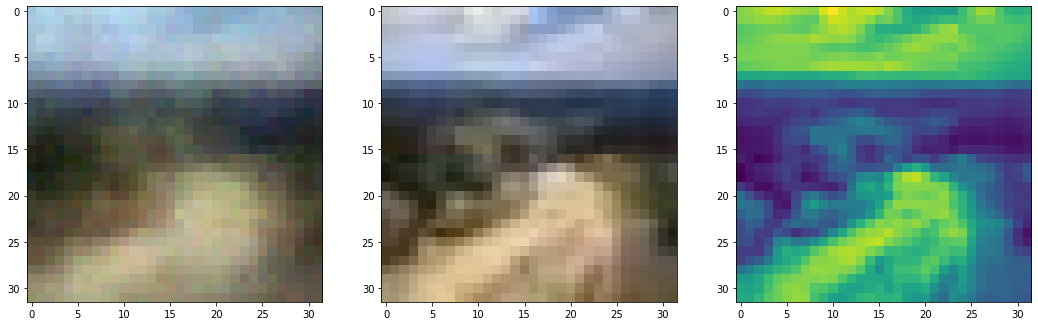

Step 130, Total loss 0.007341


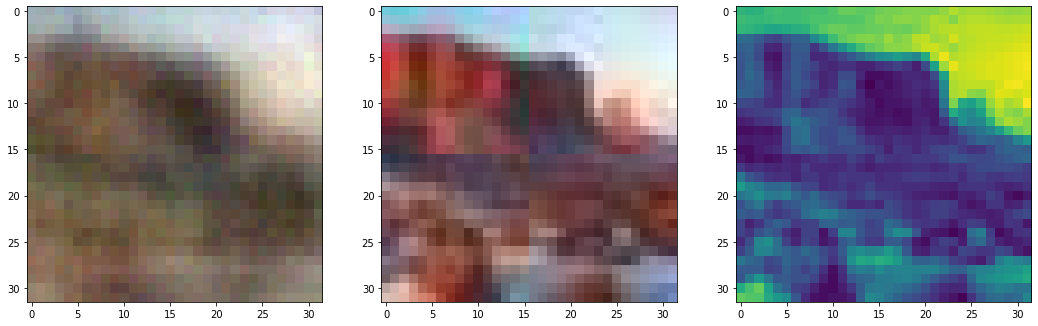

Step 140, Total loss 0.008595


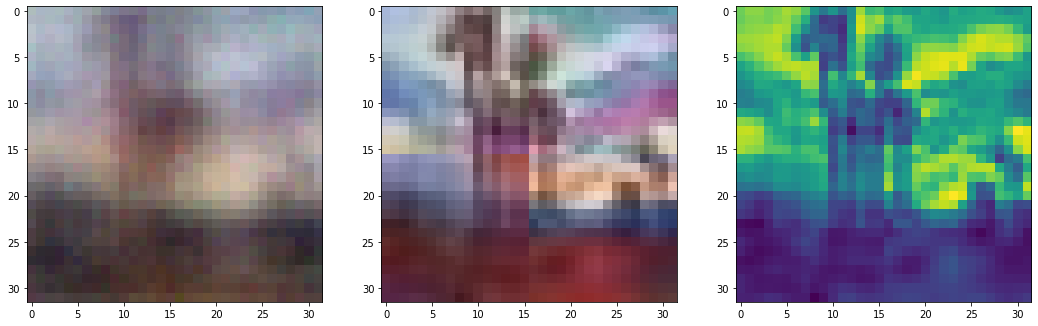

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 150, Total loss 0.008787


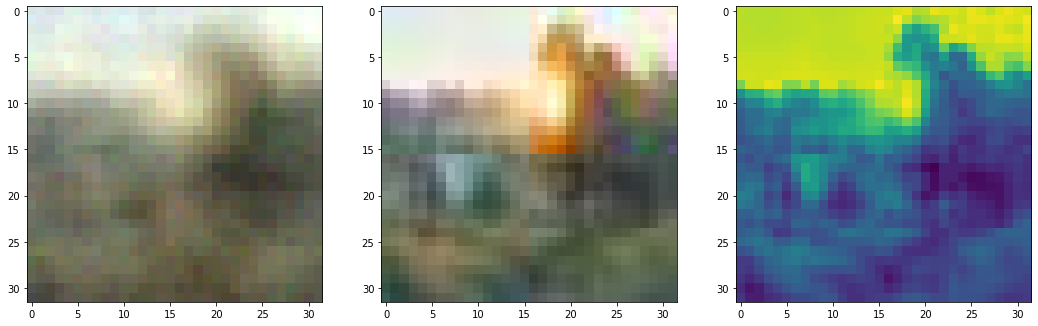

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 160, Total loss 0.007672


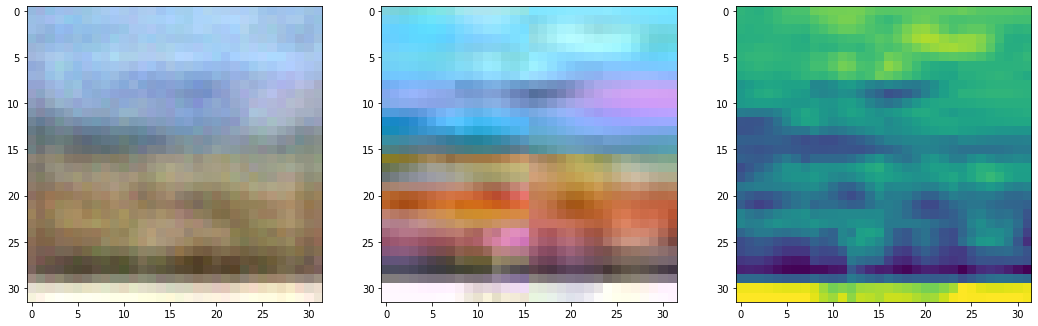

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 170, Total loss 0.008079


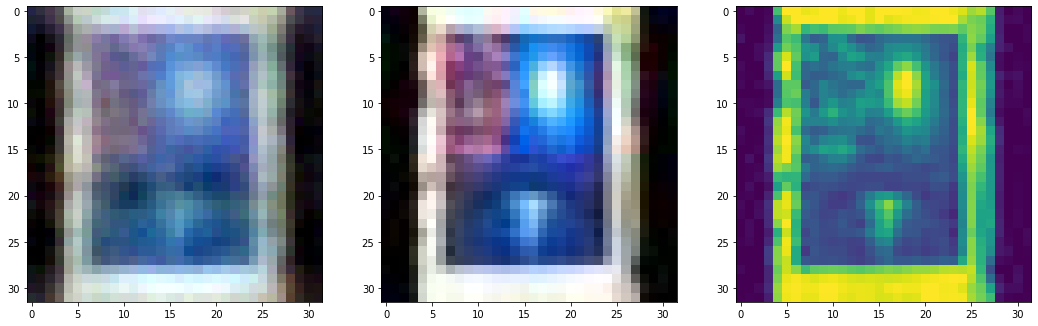

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 180, Total loss 0.008481


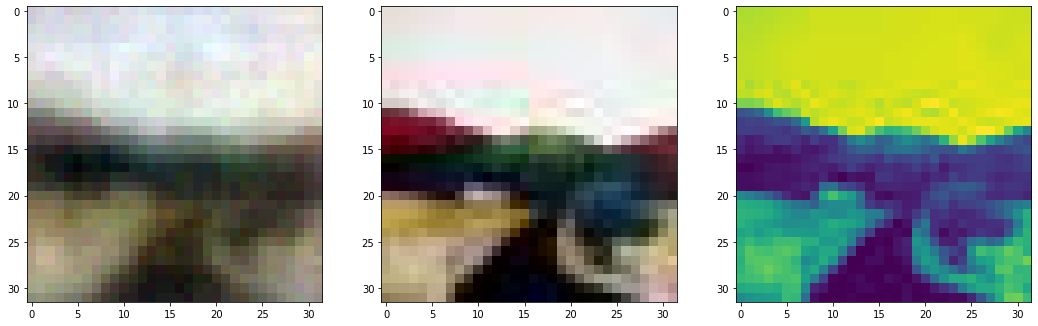

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 190, Total loss 0.007014


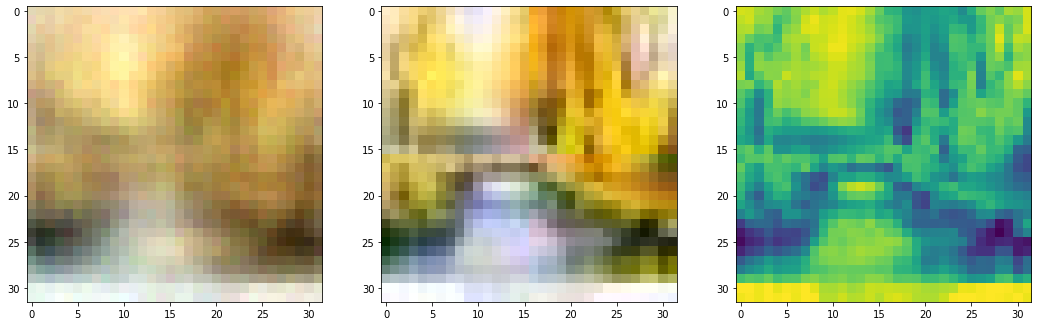

Step 200, Total loss 0.008116


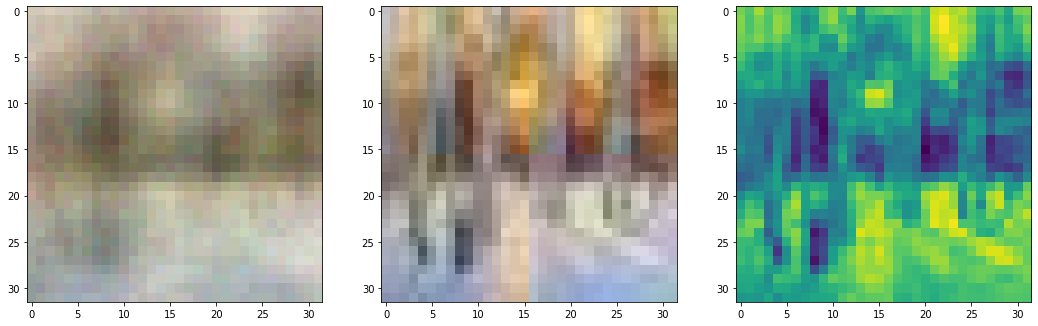

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 210, Total loss 0.007949


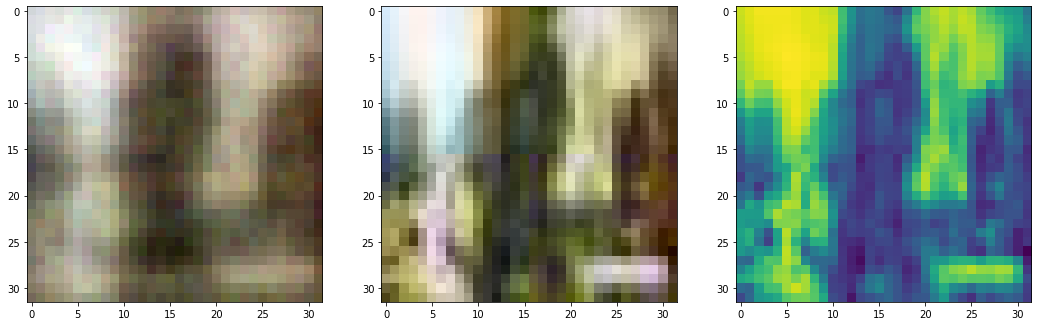

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 220, Total loss 0.007747


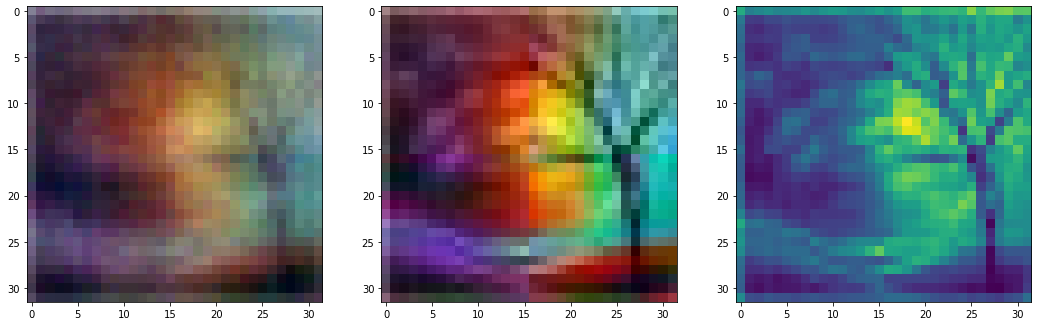

Step 230, Total loss 0.007306


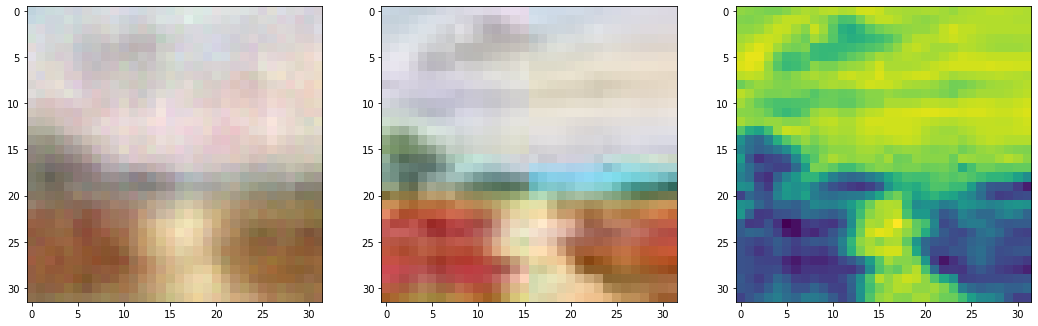

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 240, Total loss 0.007198


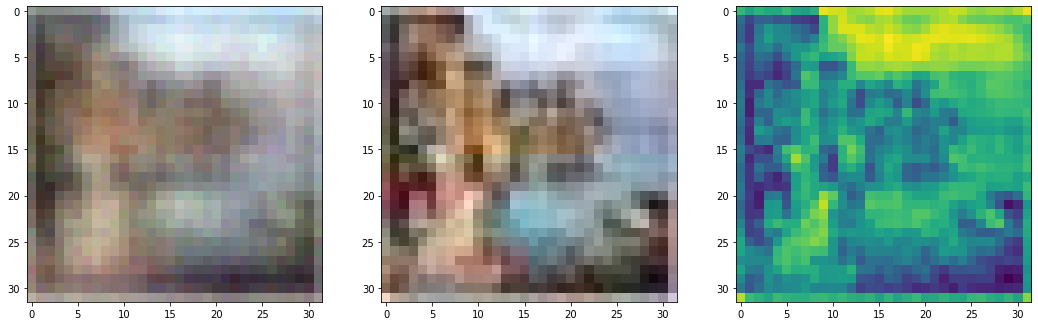

Step 250, Total loss 0.007291


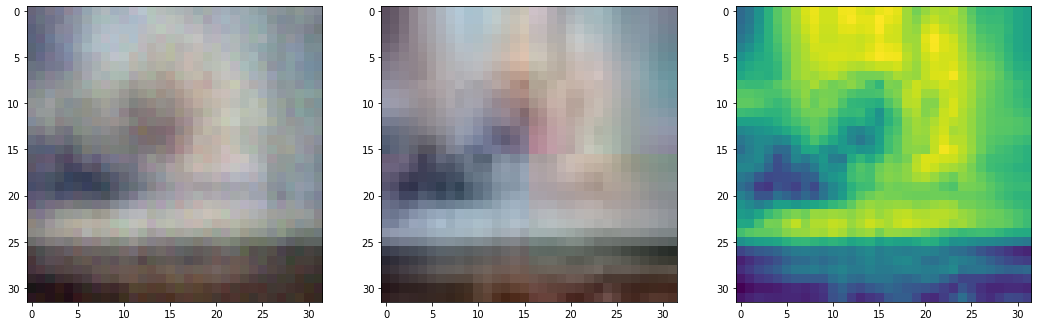

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 260, Total loss 0.006884


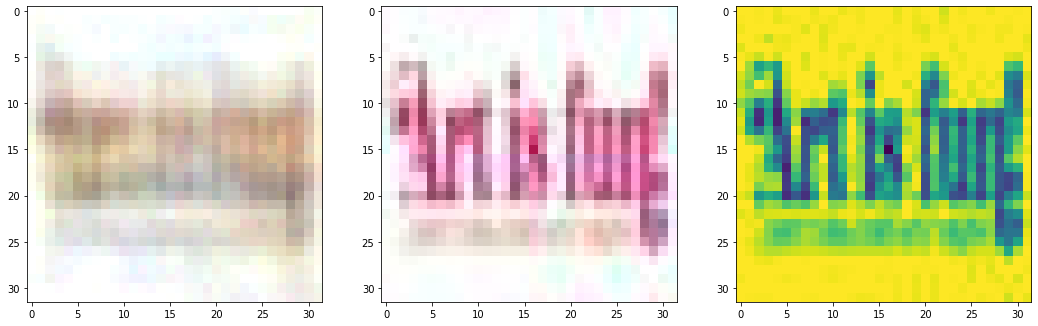

Step 270, Total loss 0.007431


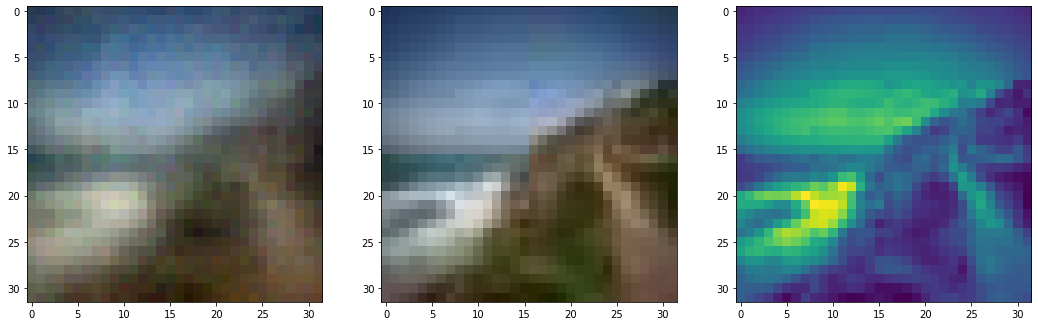

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 280, Total loss 0.005954


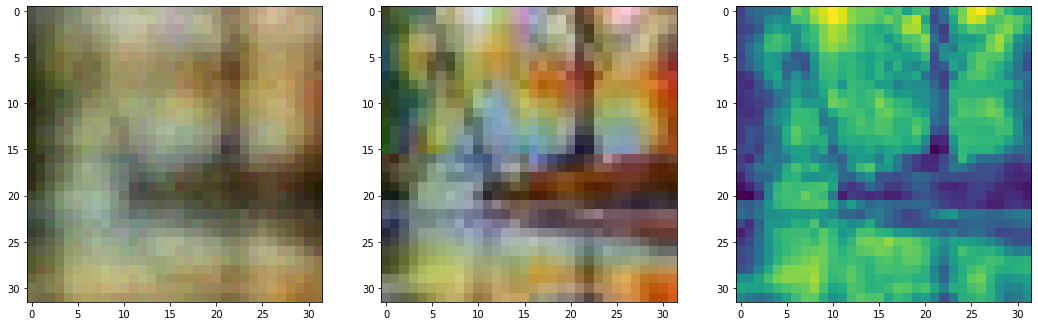

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 290, Total loss 0.006361


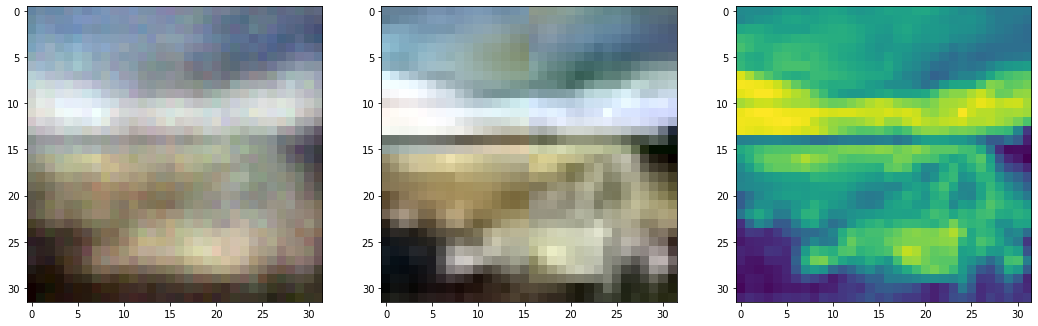

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 300, Total loss 0.006811


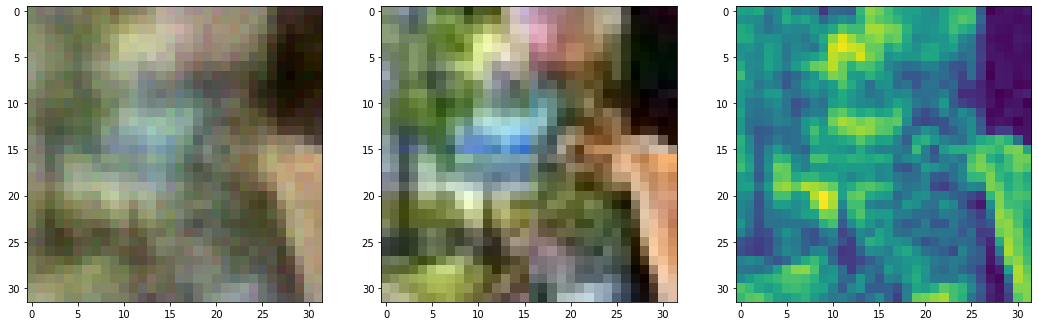

Step 310, Total loss 0.007152


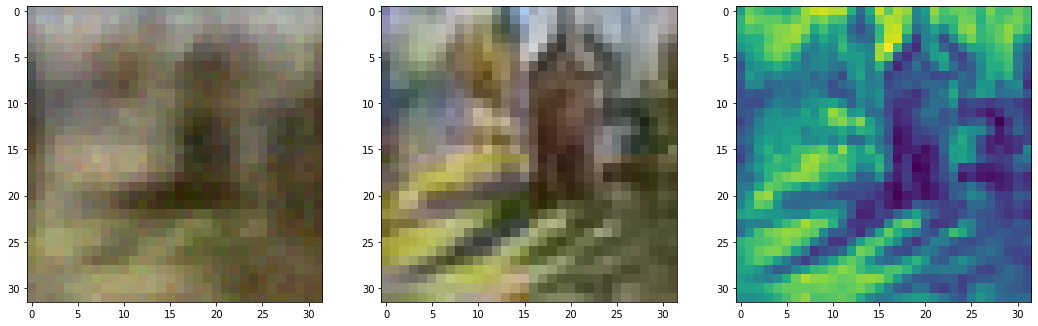

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 320, Total loss 0.006617


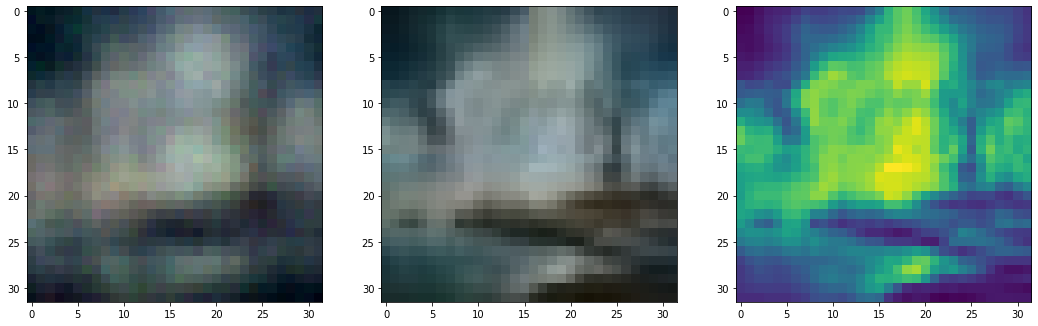

Step 330, Total loss 0.006375


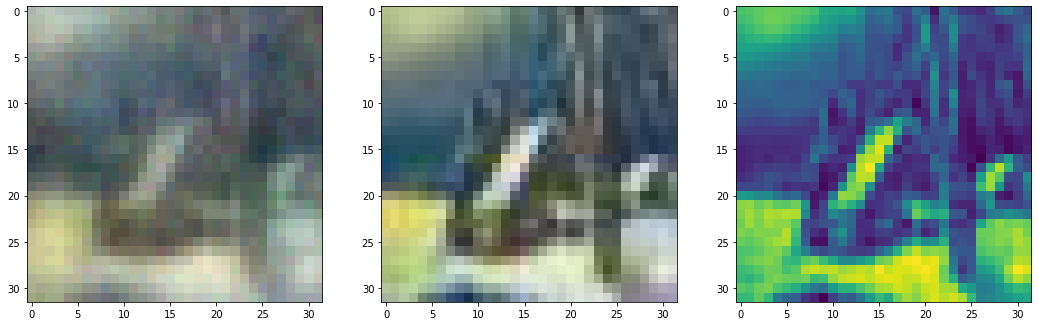

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 340, Total loss 0.006596


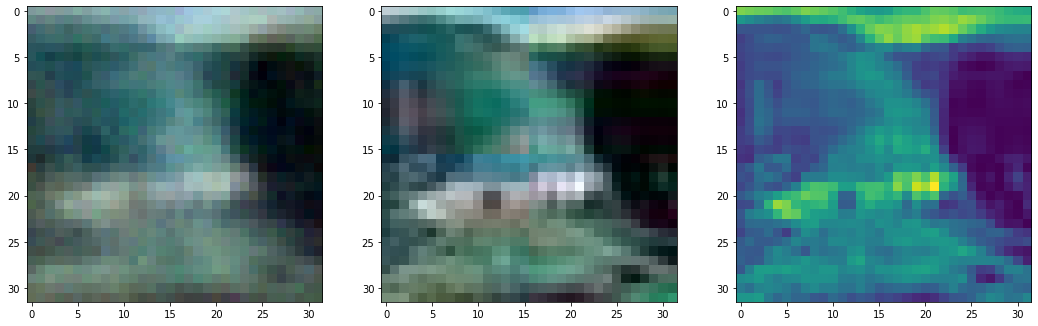

Step 350, Total loss 0.006990


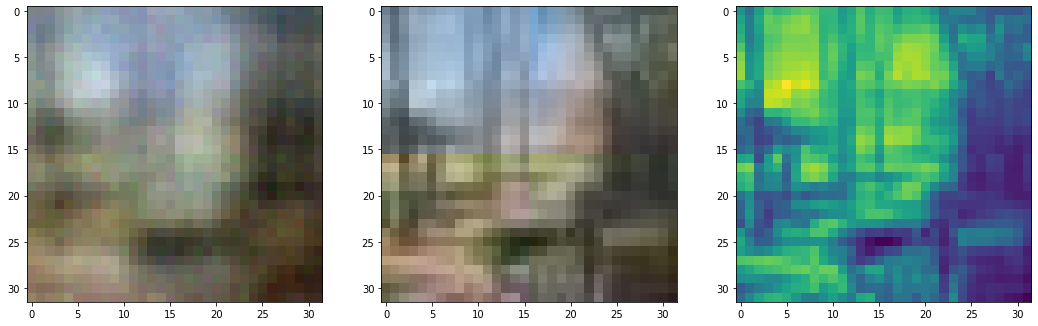

Step 360, Total loss 0.006887


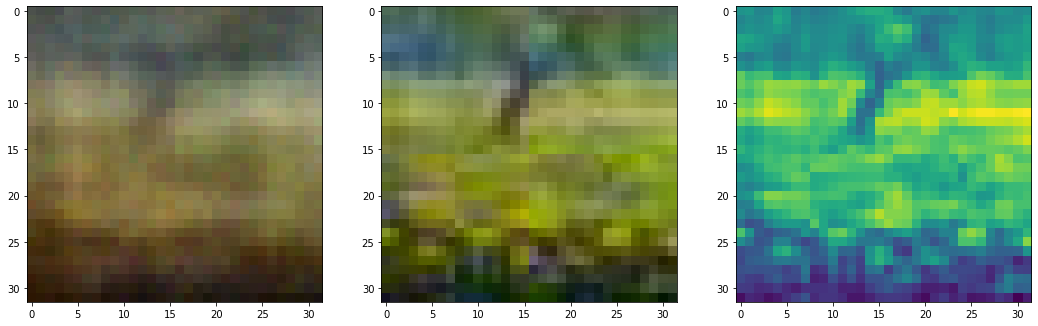

Step 370, Total loss 0.007241


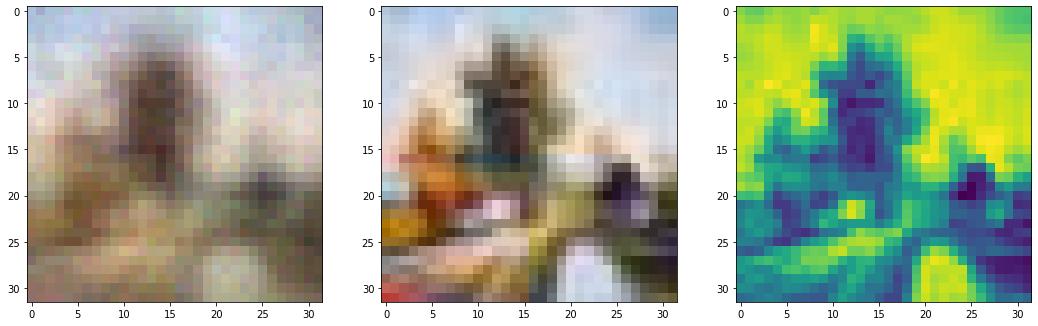

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 380, Total loss 0.005994


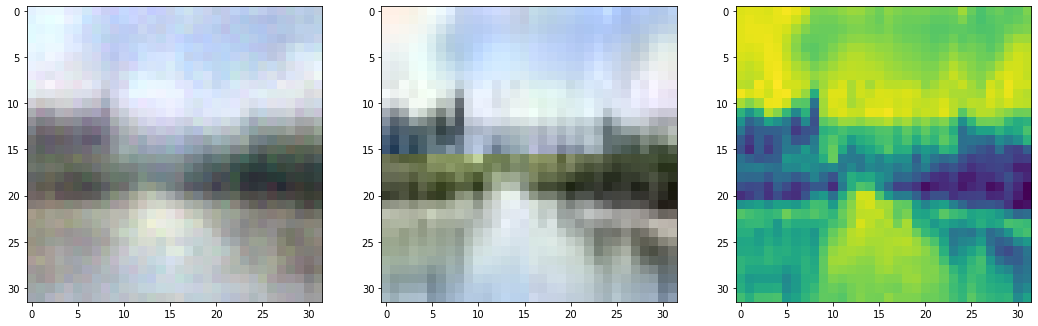

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 390, Total loss 0.007671


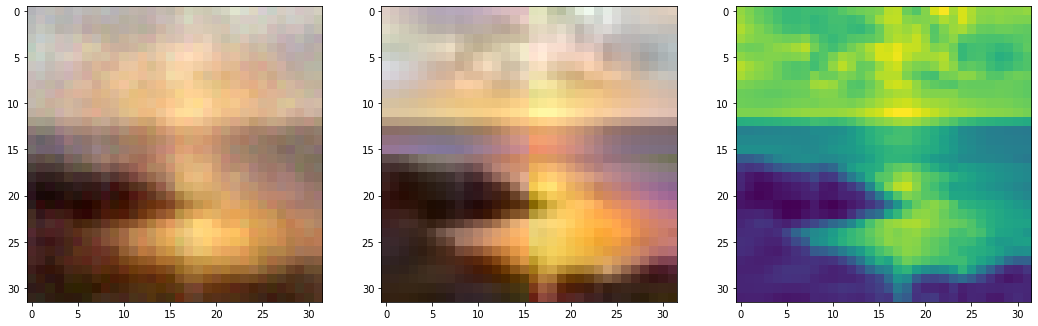

Step 400, Total loss 0.006212


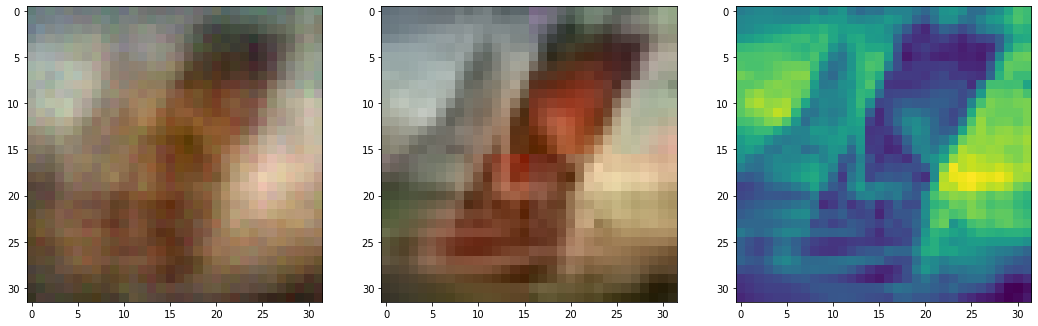

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 410, Total loss 0.006229


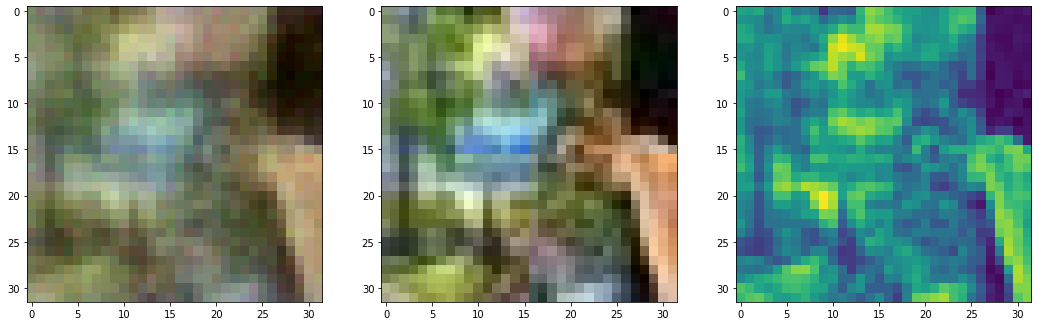

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 420, Total loss 0.006372


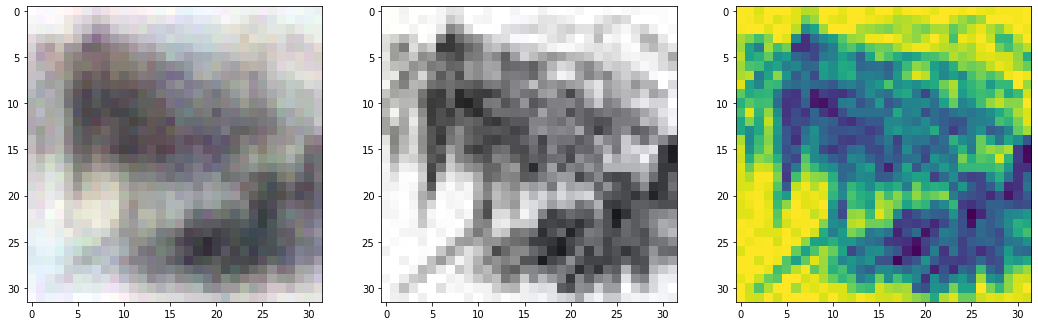

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 430, Total loss 0.006062


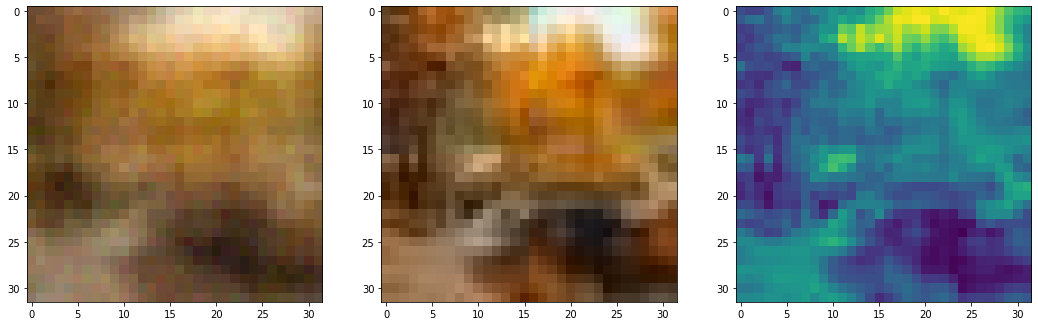

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 440, Total loss 0.006290


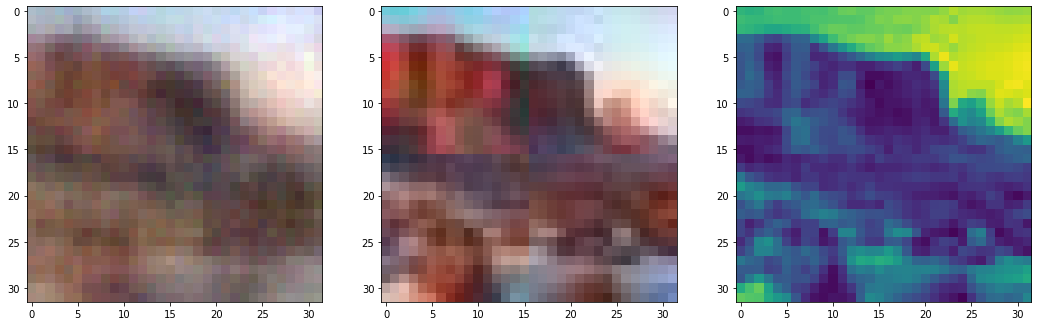

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 450, Total loss 0.006276


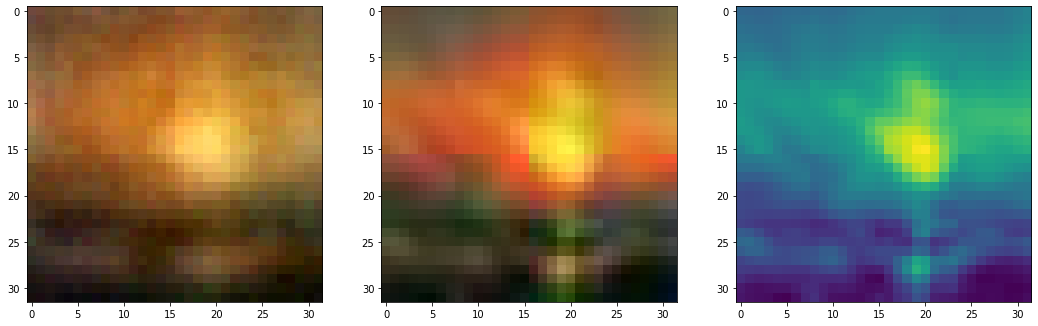

Step 460, Total loss 0.005945


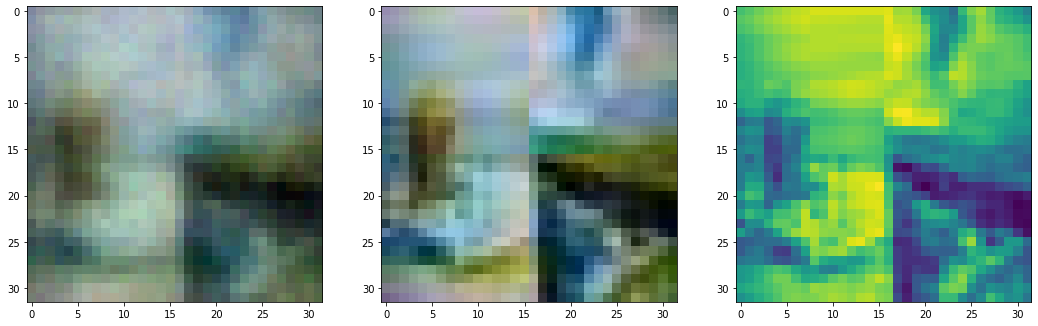

Step 470, Total loss 0.005729


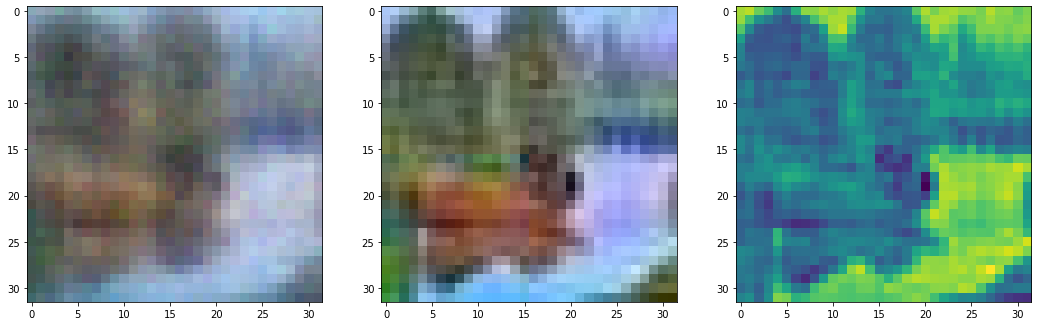

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 480, Total loss 0.006261


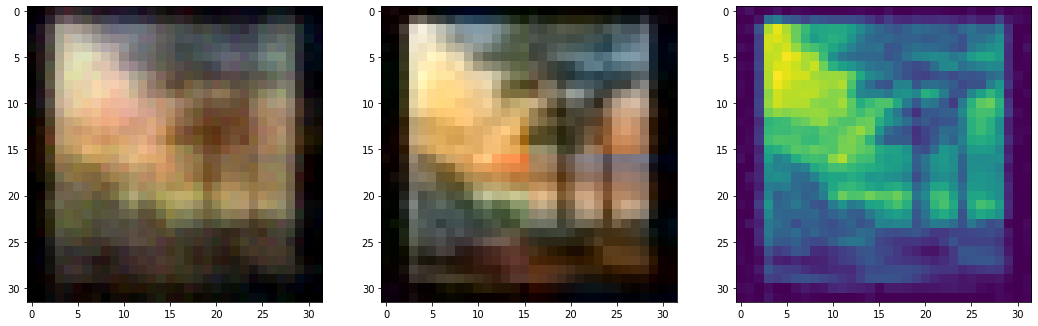

Step 490, Total loss 0.005256


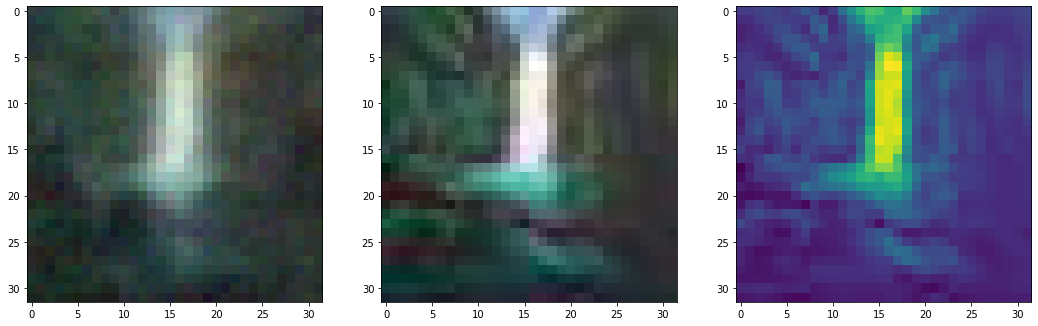

Step 500, Total loss 0.005193


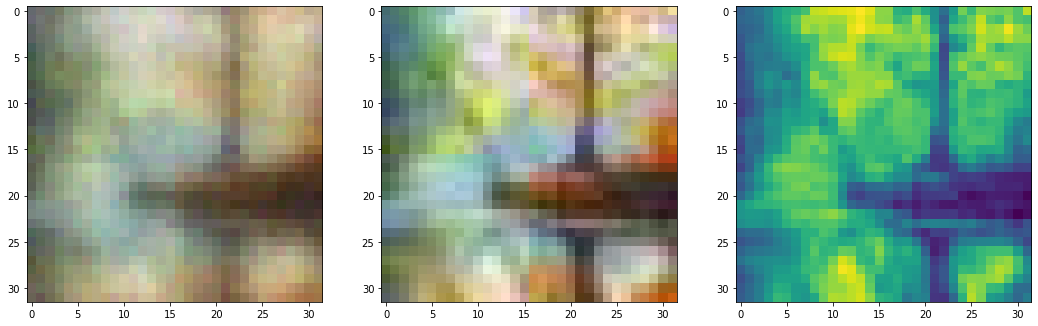

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 510, Total loss 0.005262


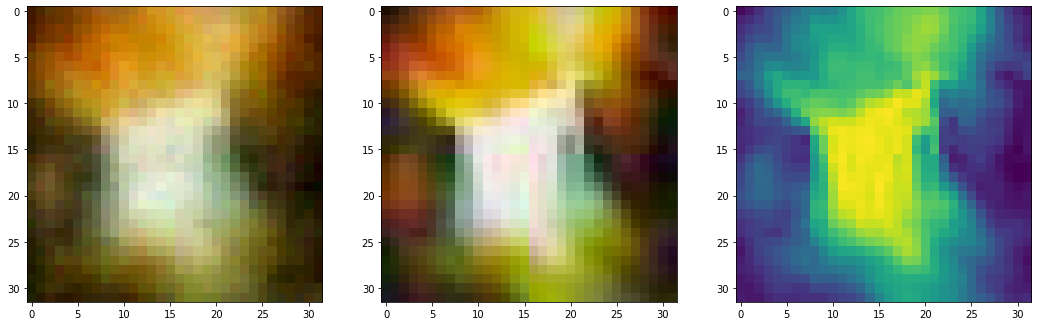

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 520, Total loss 0.005783


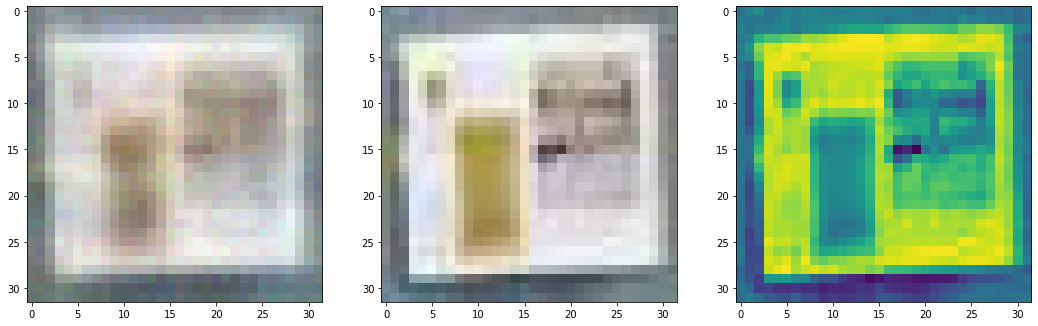

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 530, Total loss 0.005209


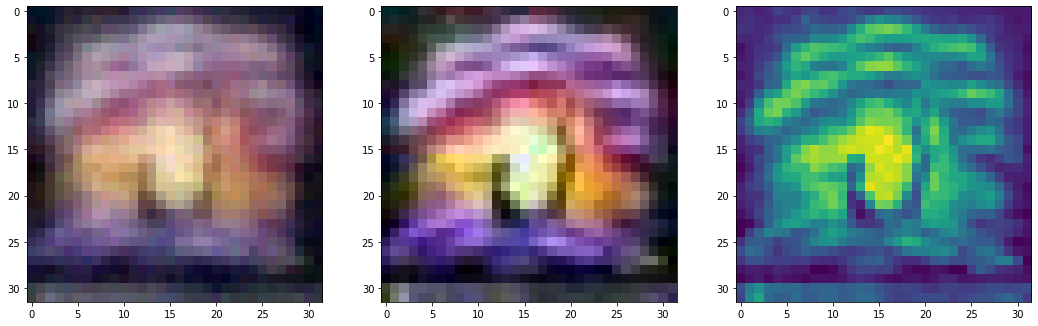

Step 540, Total loss 0.004844


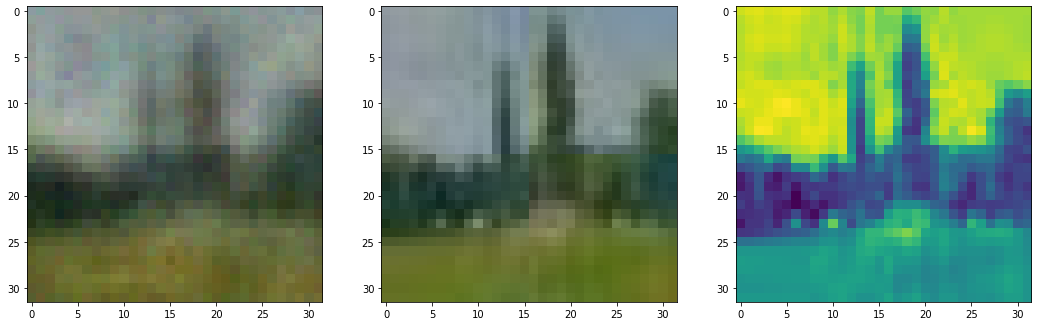

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 550, Total loss 0.005142


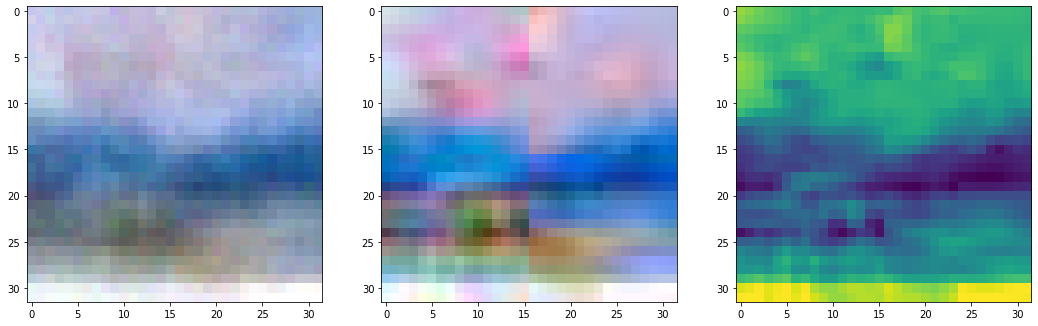

Step 560, Total loss 0.006512


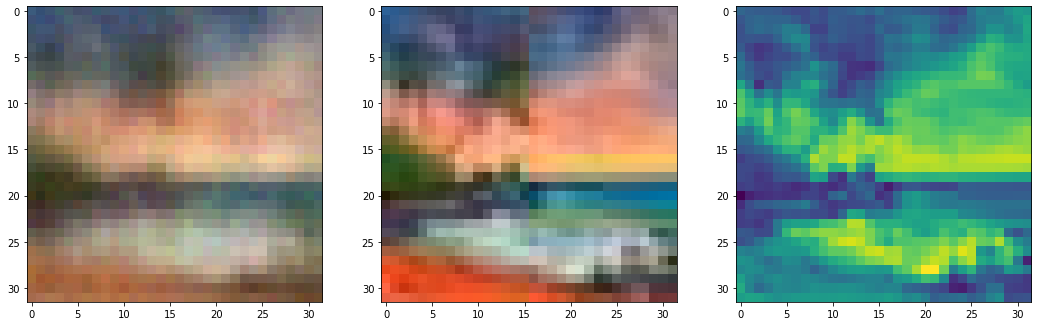

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 570, Total loss 0.005434


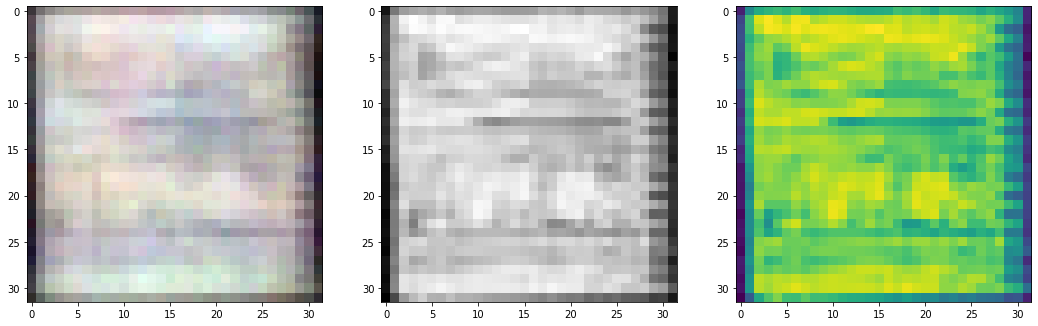

Step 580, Total loss 0.005489


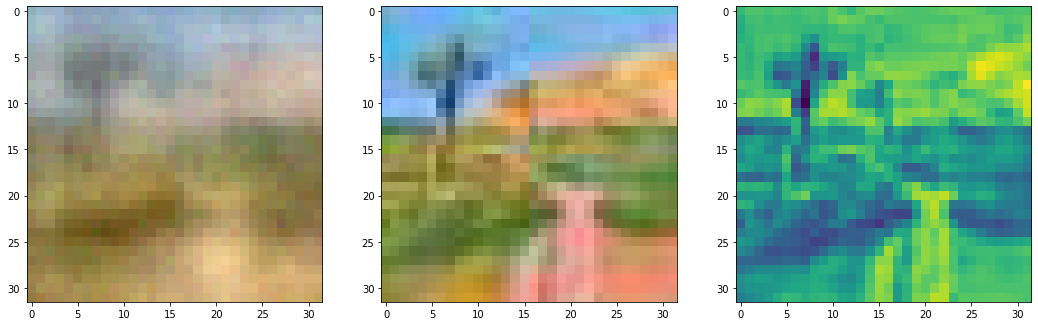

Step 590, Total loss 0.004985


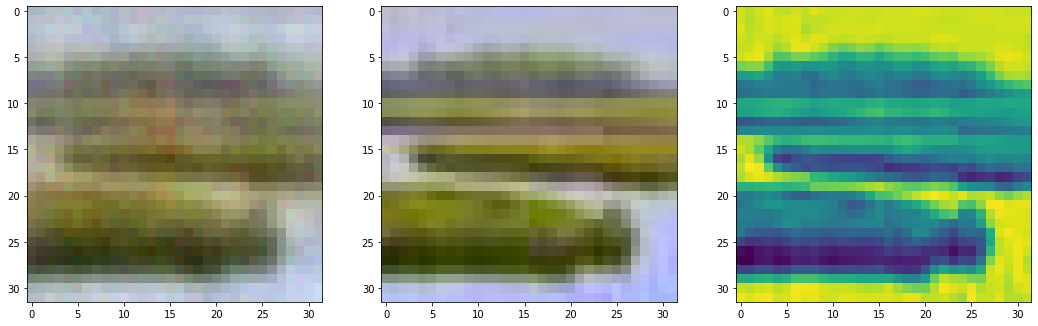

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 600, Total loss 0.004802


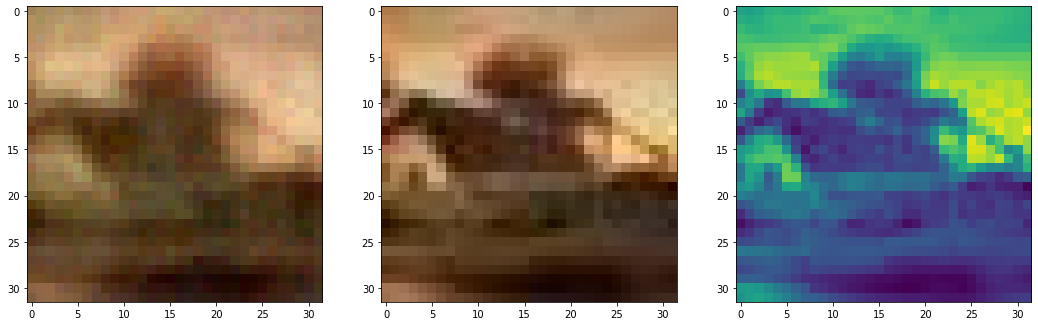

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 610, Total loss 0.005121


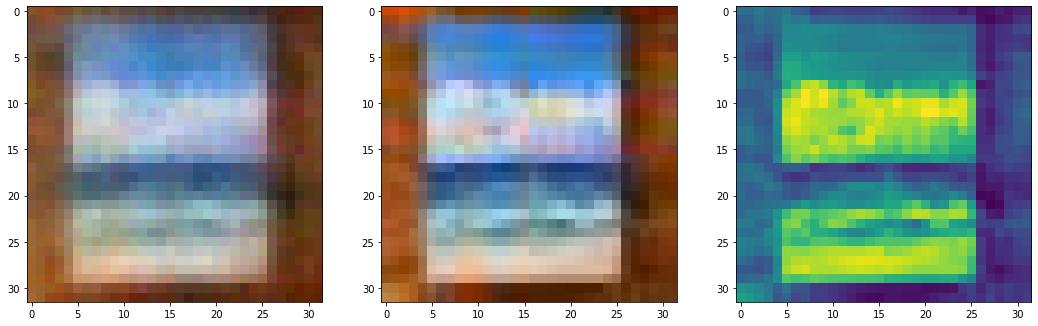

Step 620, Total loss 0.005011


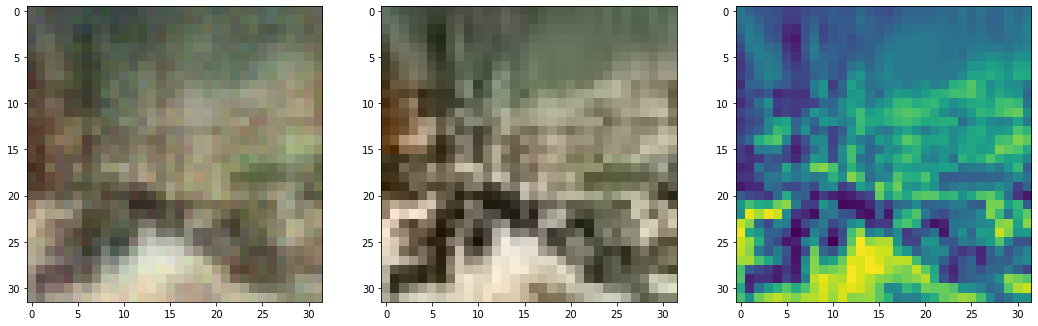

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 630, Total loss 0.005427


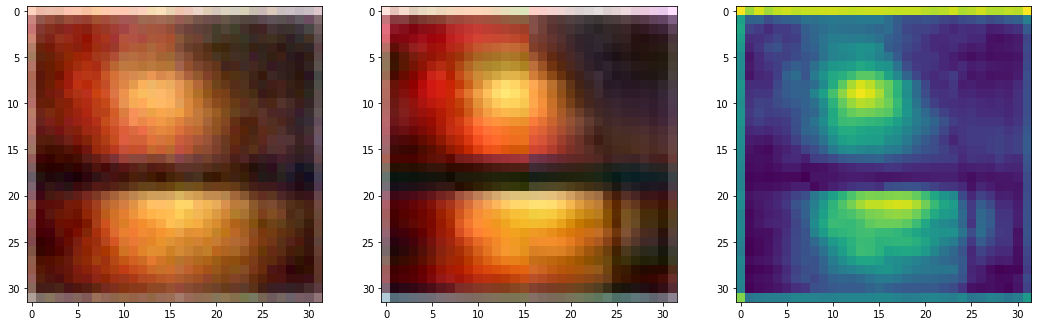

Step 640, Total loss 0.004560


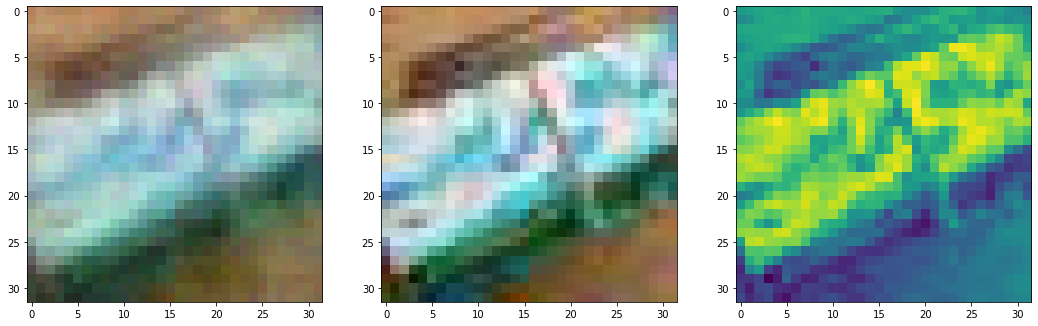

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 650, Total loss 0.004808


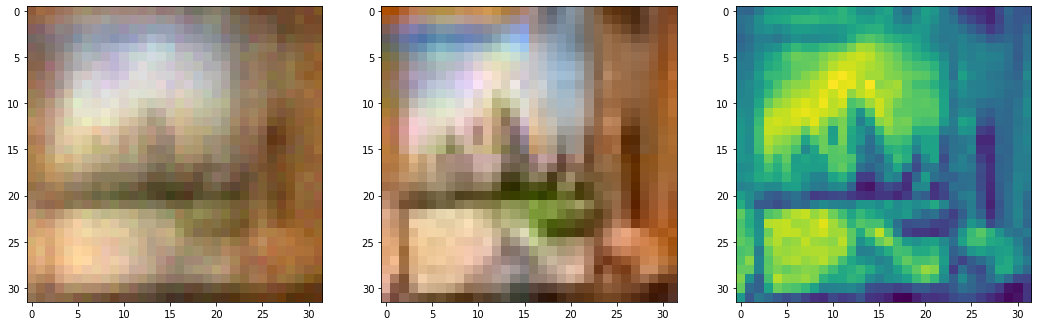

Step 660, Total loss 0.004689


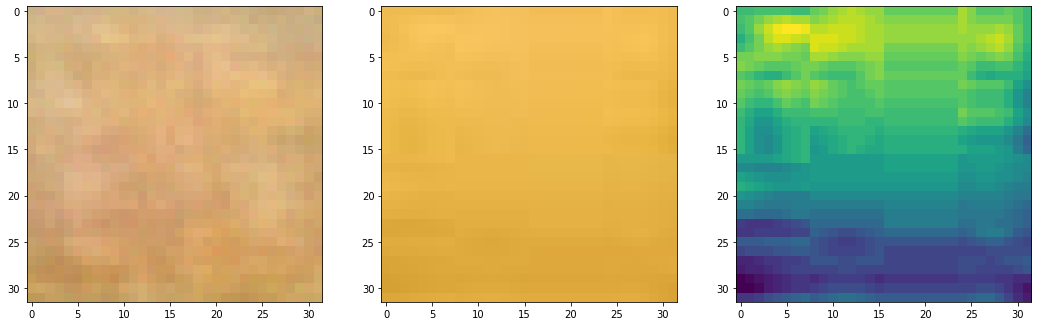

Step 670, Total loss 0.004246


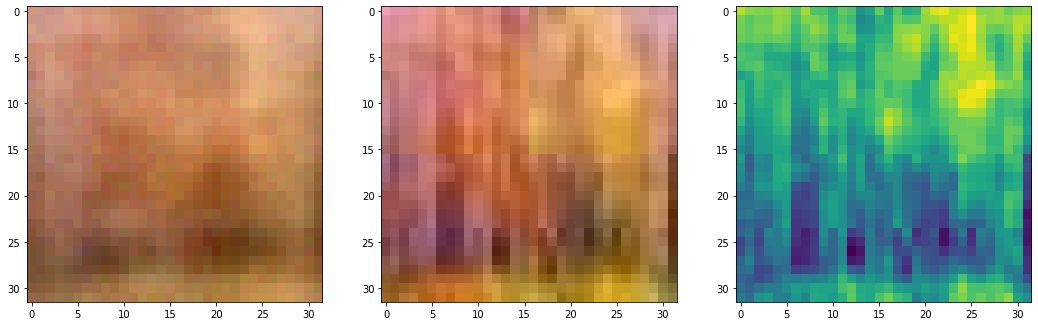

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 680, Total loss 0.004846


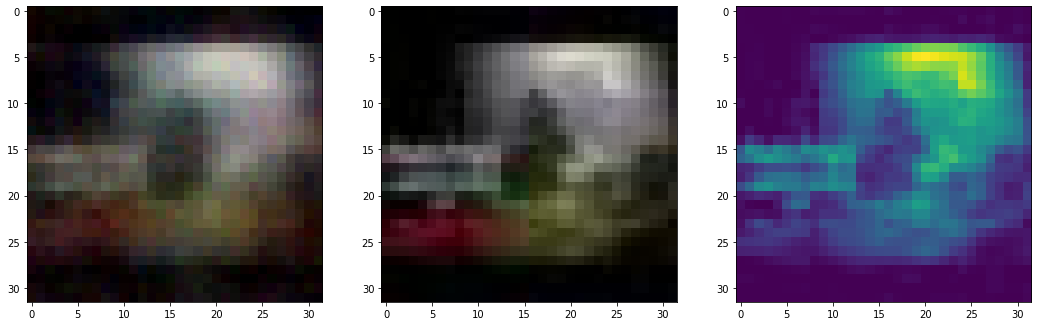

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 690, Total loss 0.005261


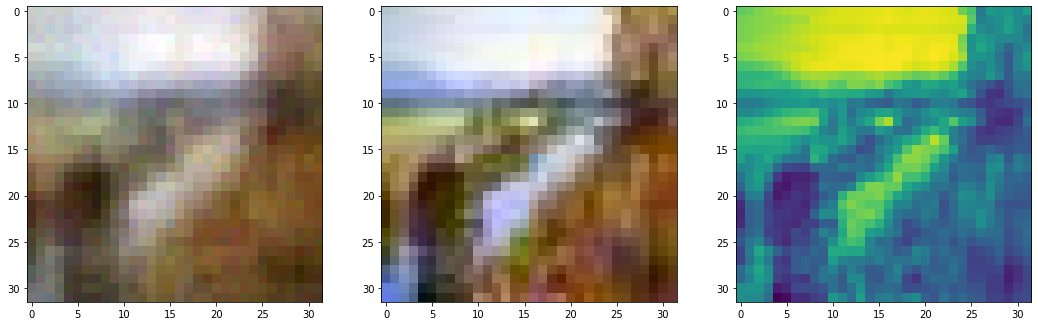

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 700, Total loss 0.004380


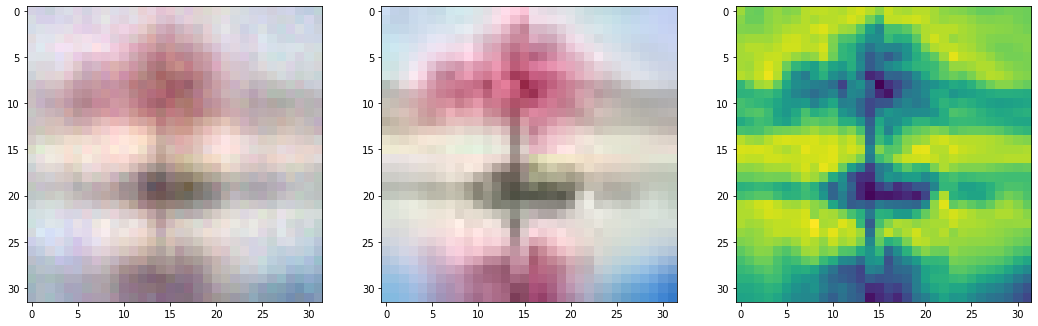

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 710, Total loss 0.004293


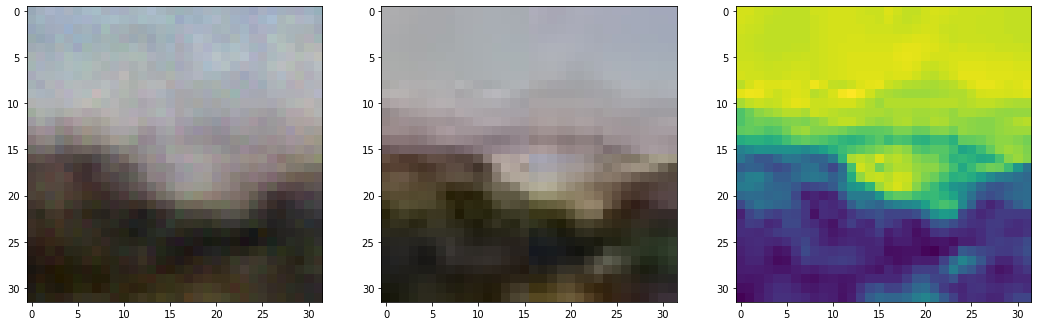

Step 720, Total loss 0.004524


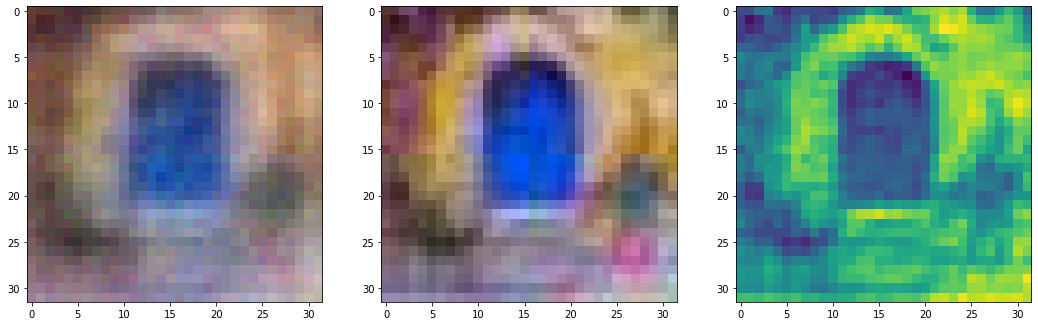

Step 730, Total loss 0.004529


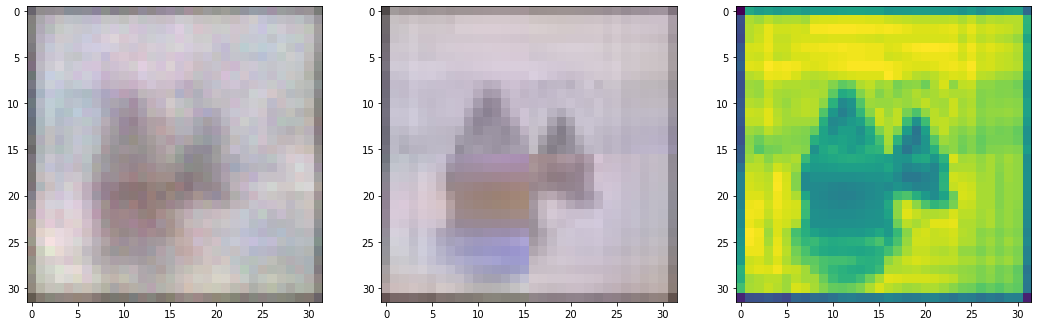

Step 740, Total loss 0.004039


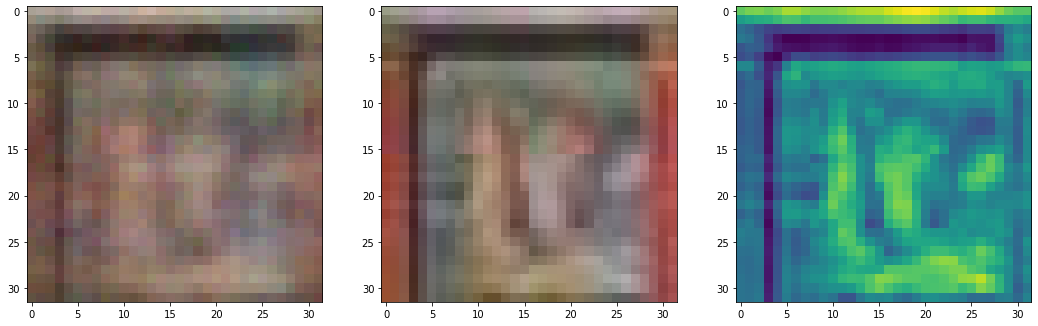

Step 750, Total loss 0.004035


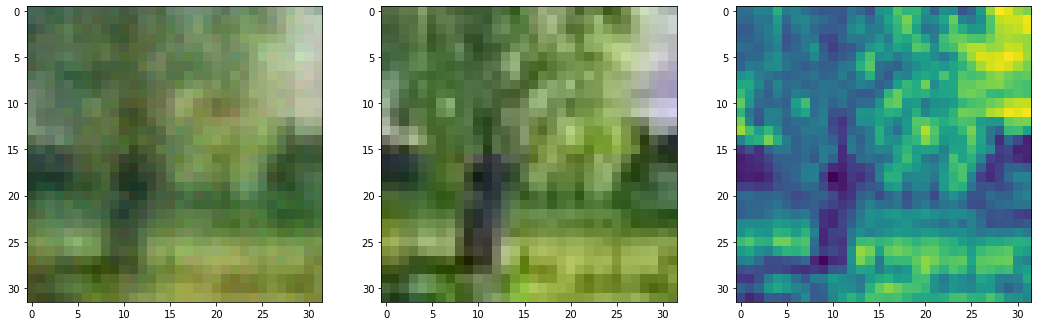

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 760, Total loss 0.004898


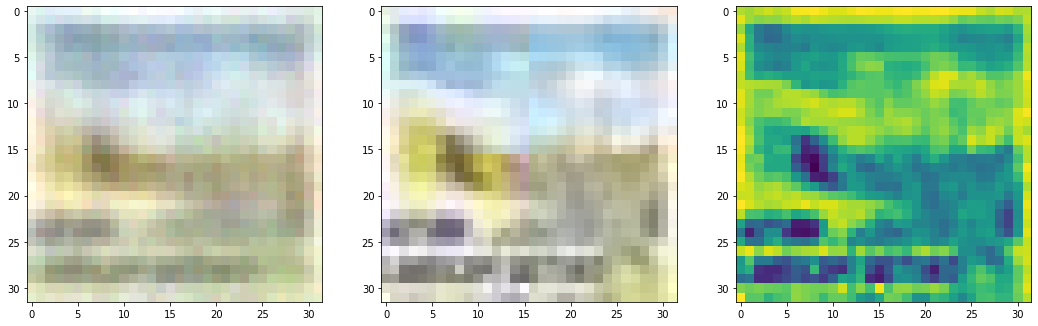

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 770, Total loss 0.003908


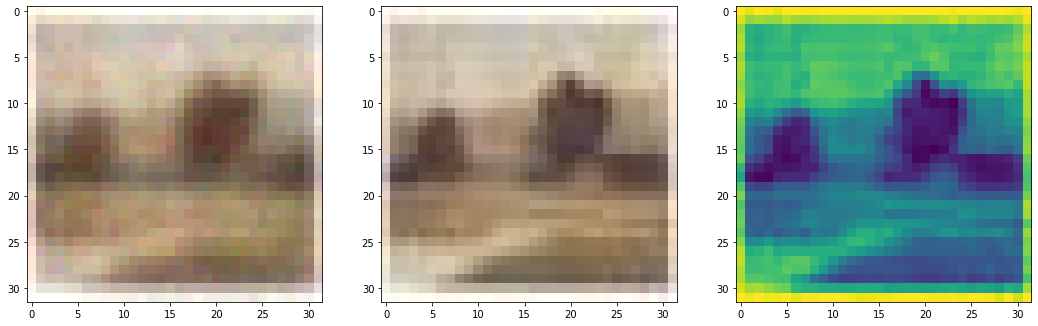

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 780, Total loss 0.004207


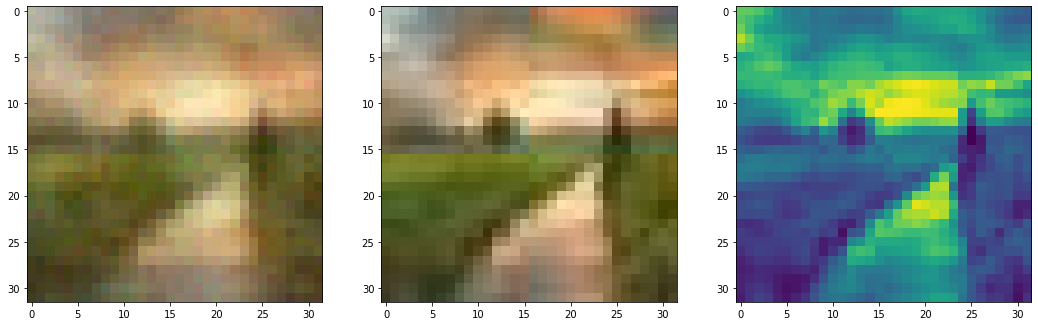

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 790, Total loss 0.004025


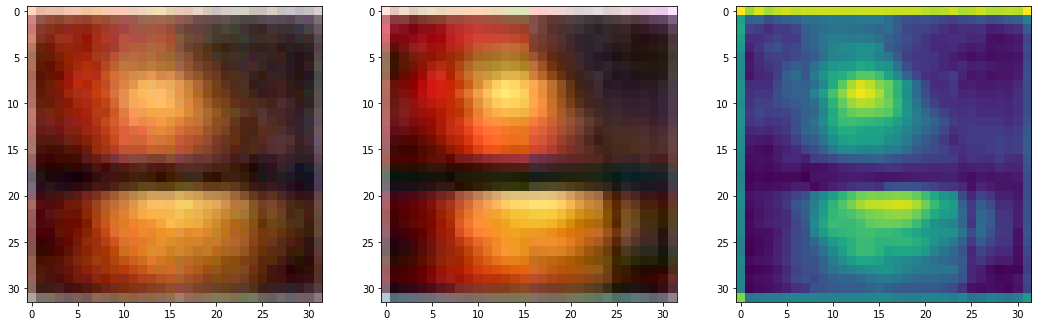

Step 800, Total loss 0.003651


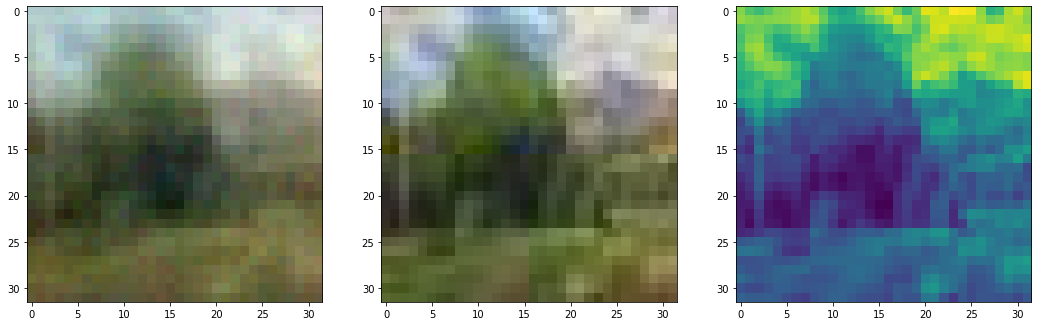

Step 810, Total loss 0.004140


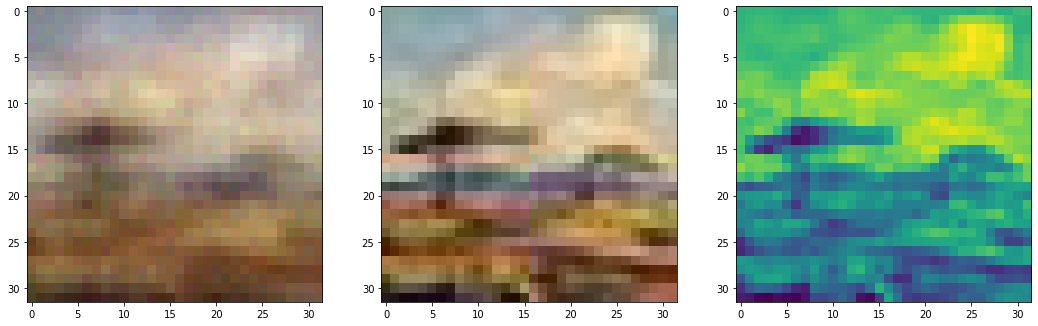

Step 820, Total loss 0.004019


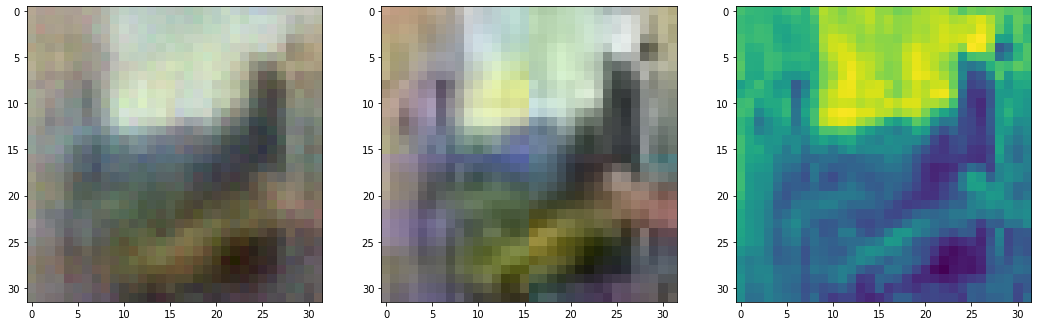

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 830, Total loss 0.003756


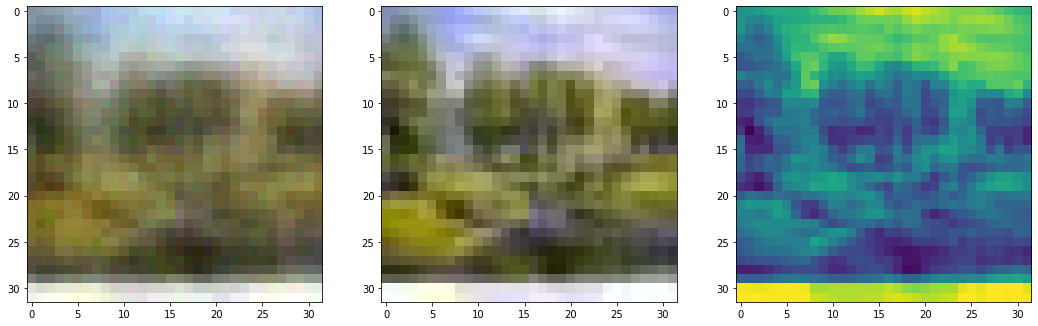

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 840, Total loss 0.003822


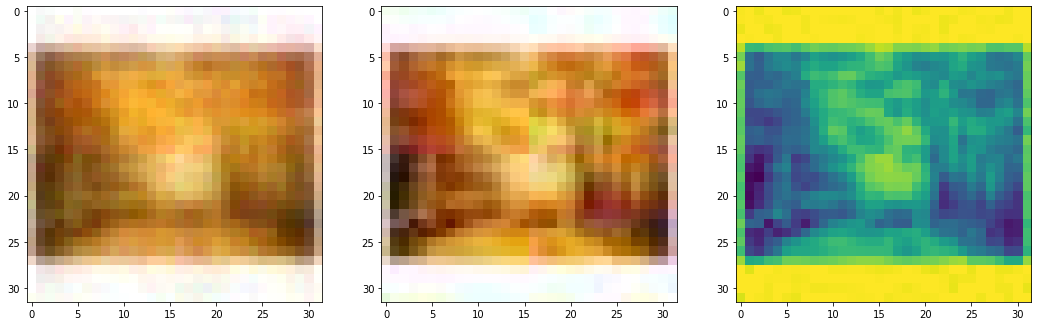

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 850, Total loss 0.003867


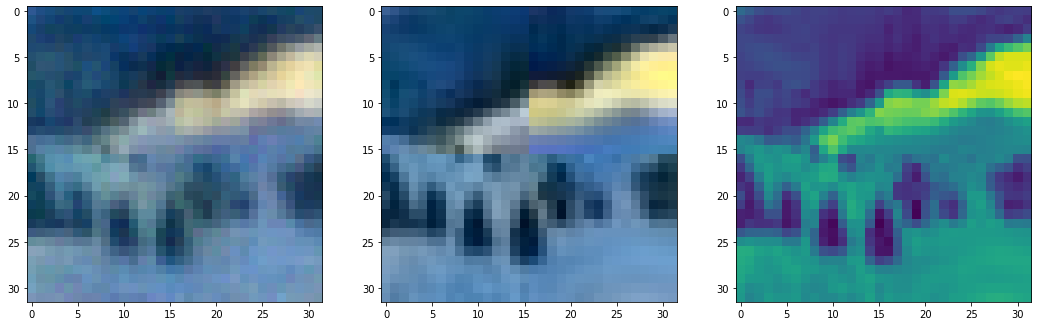

Step 860, Total loss 0.003338


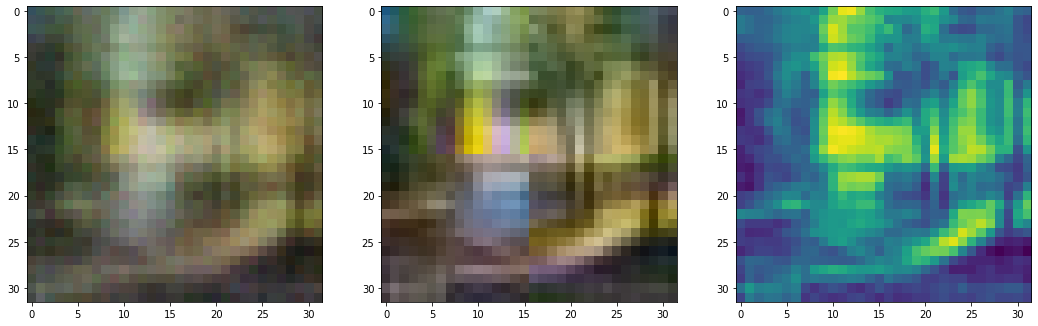

Step 870, Total loss 0.004481


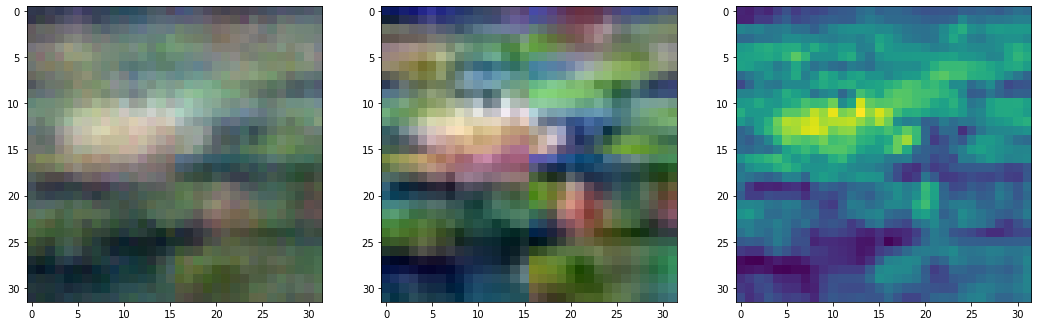

Step 880, Total loss 0.003670


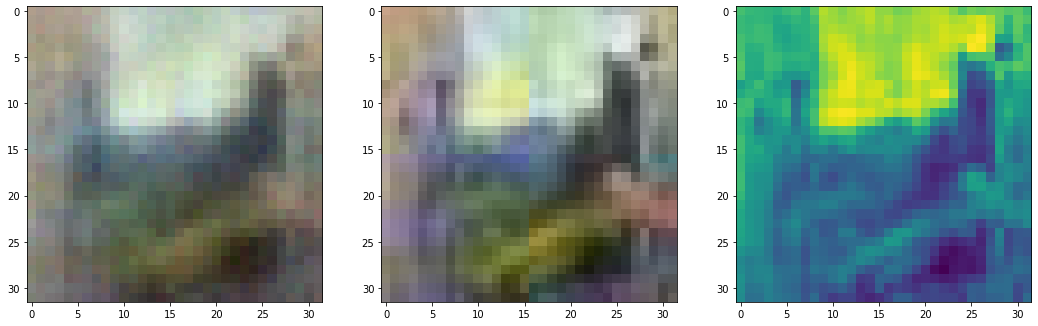

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 890, Total loss 0.003611


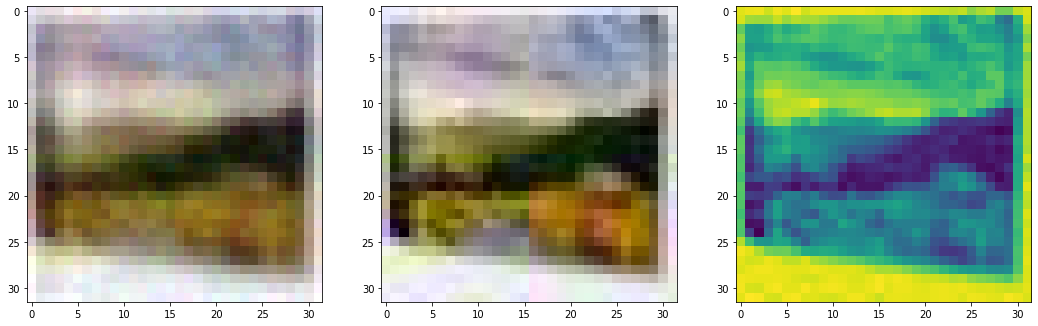

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 900, Total loss 0.003711


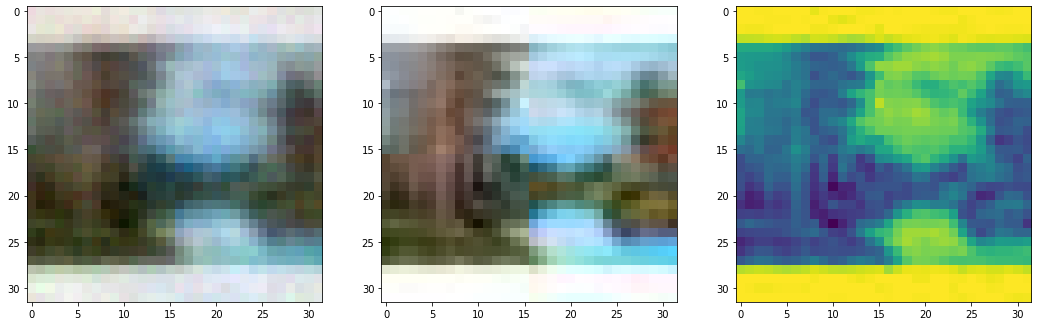

Step 910, Total loss 0.003835


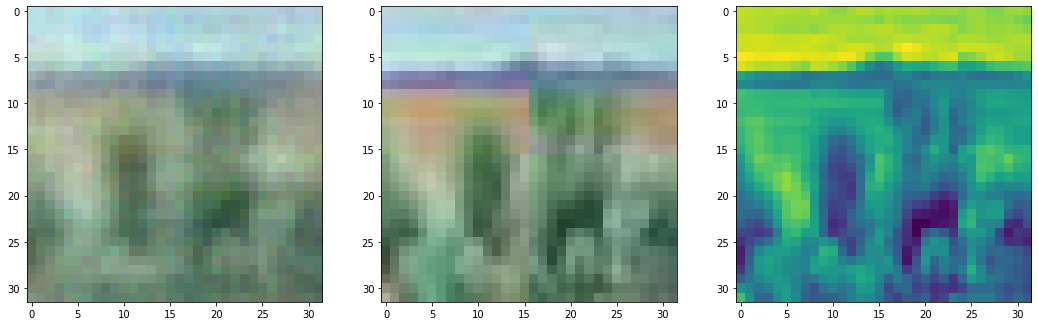

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 920, Total loss 0.003661


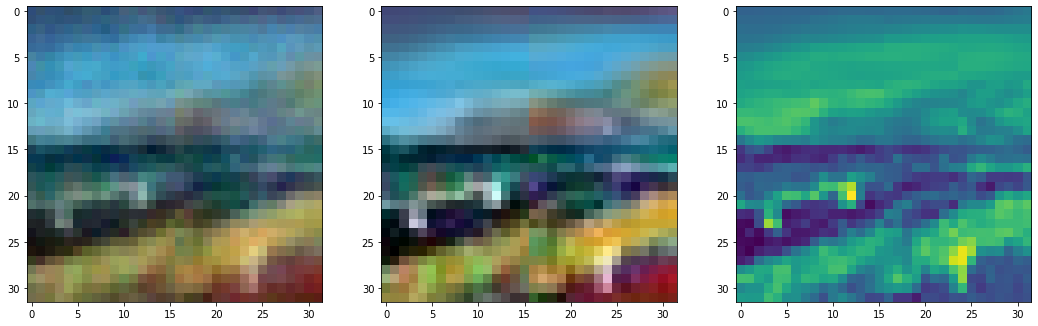

Step 930, Total loss 0.003750


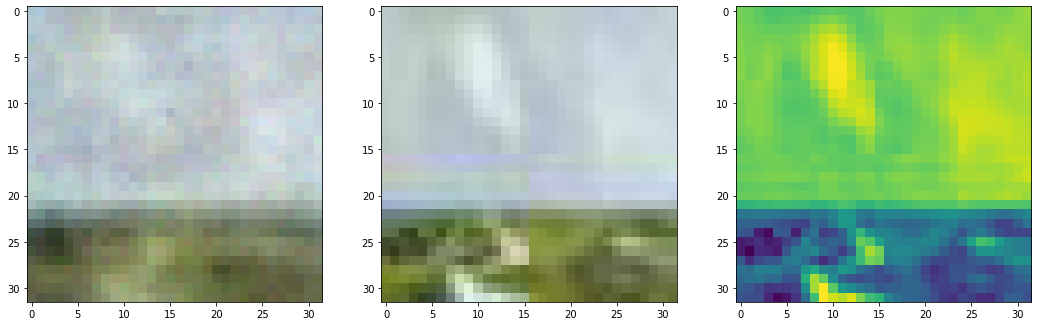

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 940, Total loss 0.003821


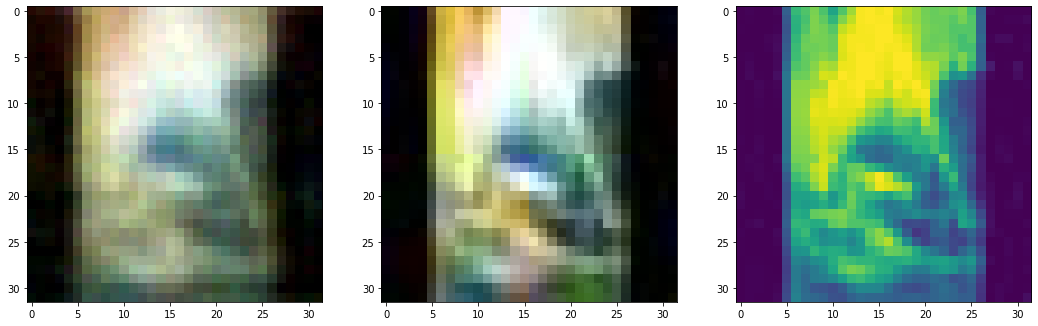

Step 950, Total loss 0.003566


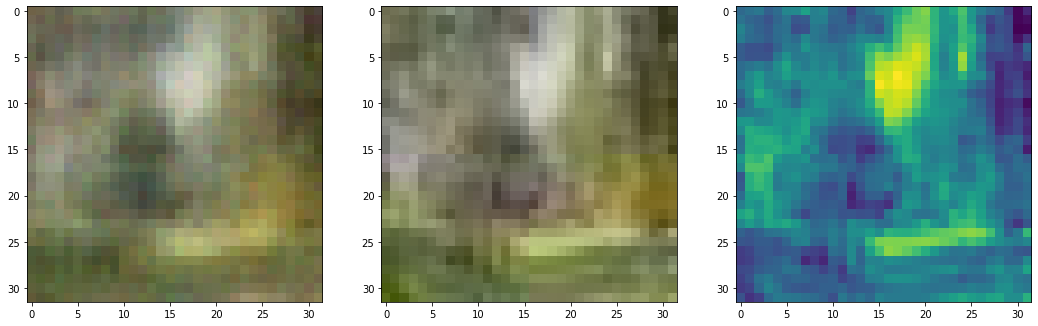

Step 960, Total loss 0.003595


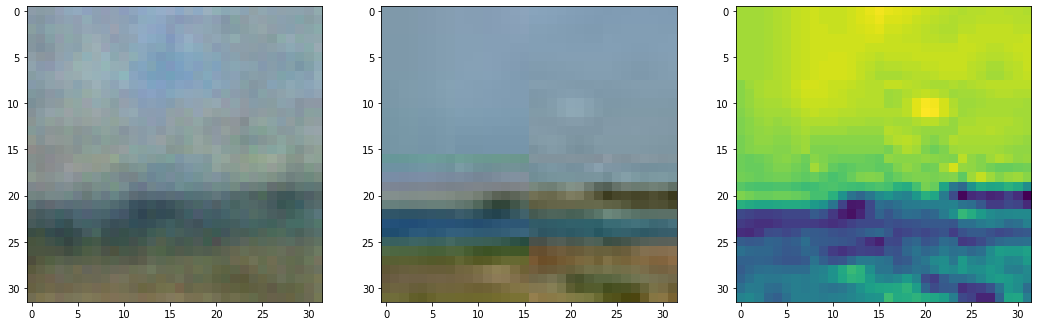

Step 970, Total loss 0.003582


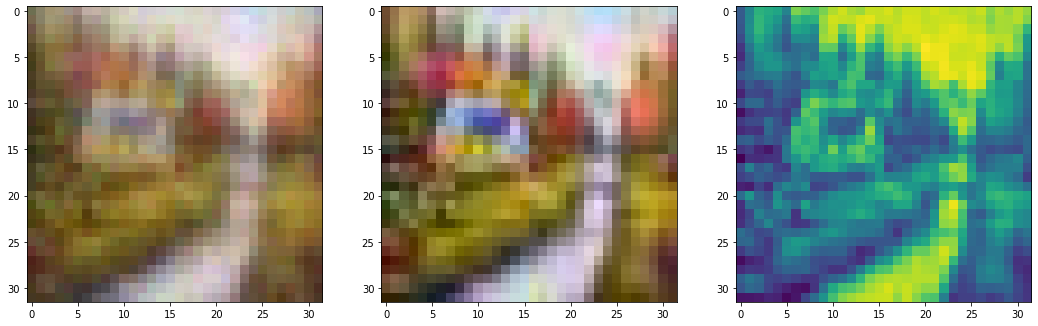

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 980, Total loss 0.003010


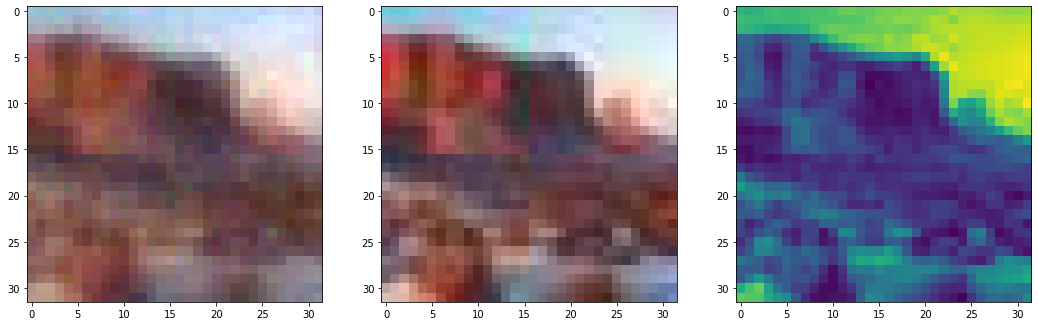

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 990, Total loss 0.003283


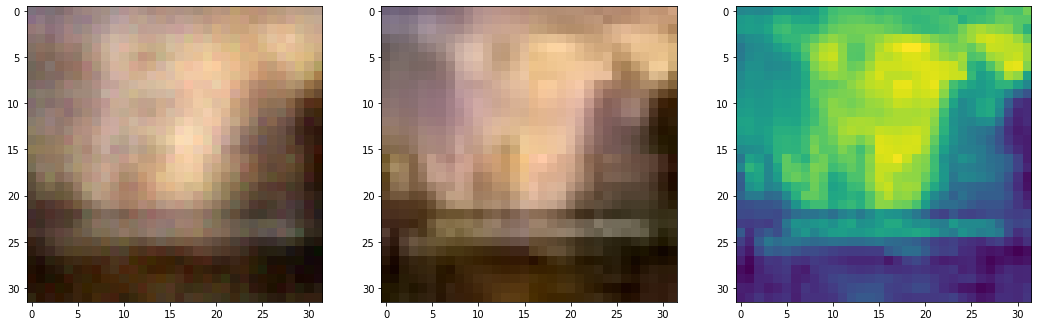

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000, Total loss 0.003912


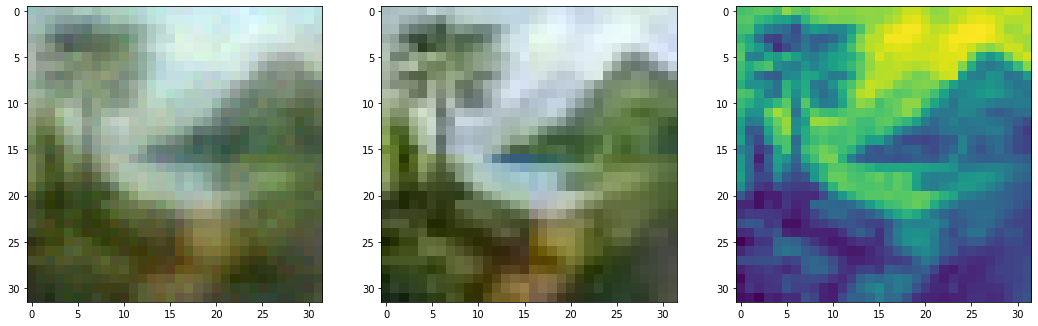

Step 1010, Total loss 0.003343


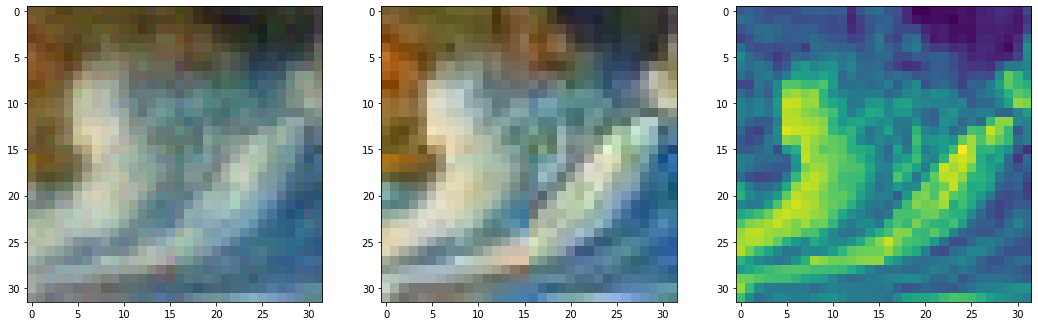

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1020, Total loss 0.003277


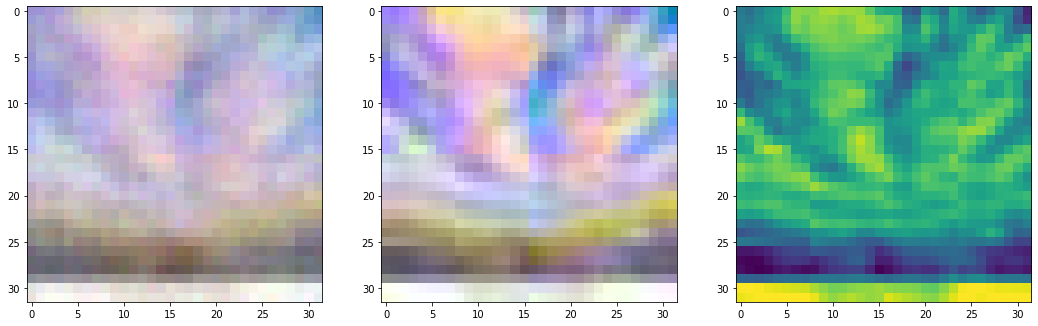

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1030, Total loss 0.003207


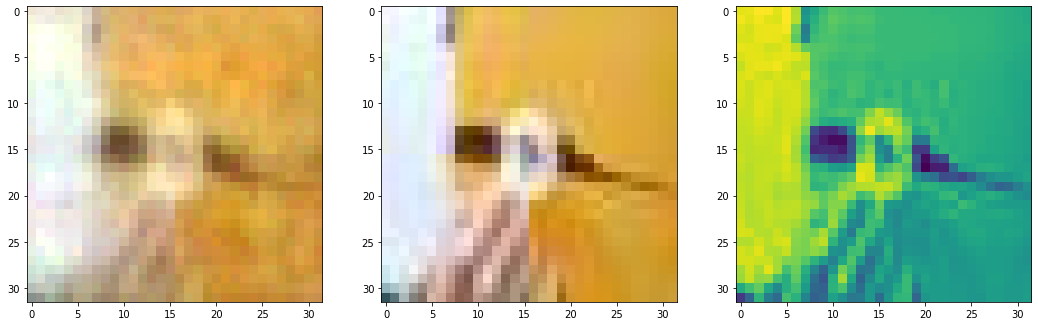

Step 1040, Total loss 0.003423


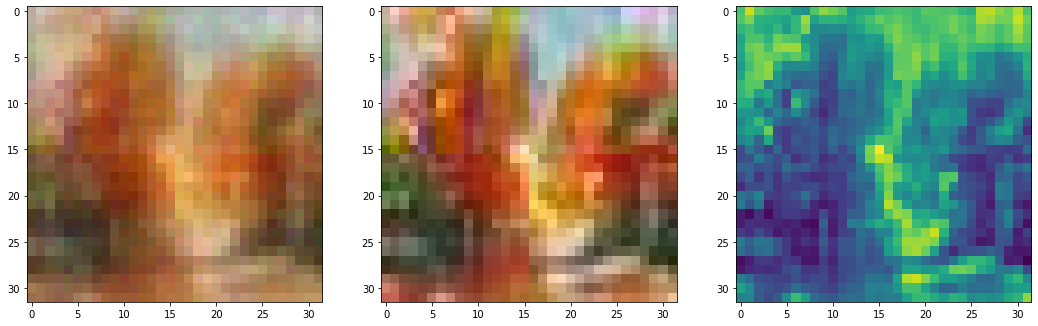

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1050, Total loss 0.003045


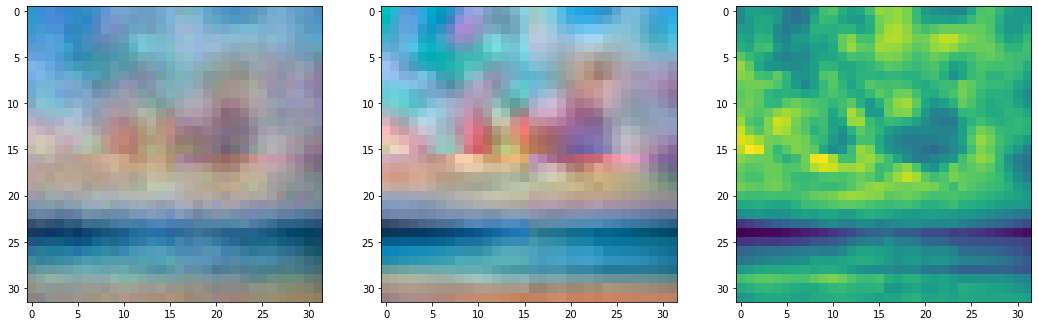

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1060, Total loss 0.003141


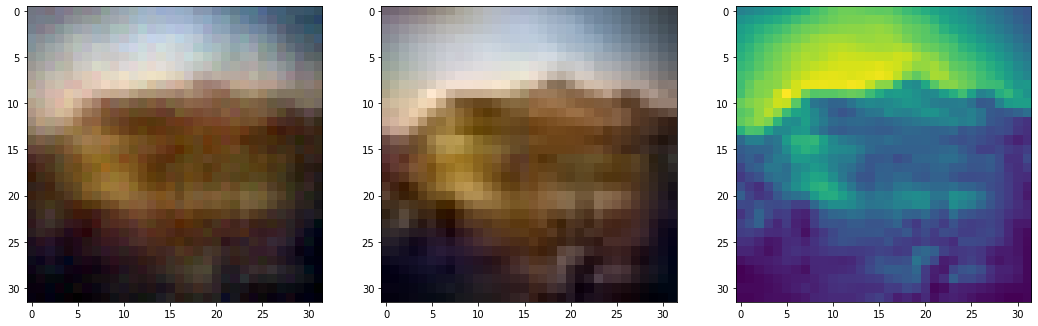

Step 1070, Total loss 0.002972


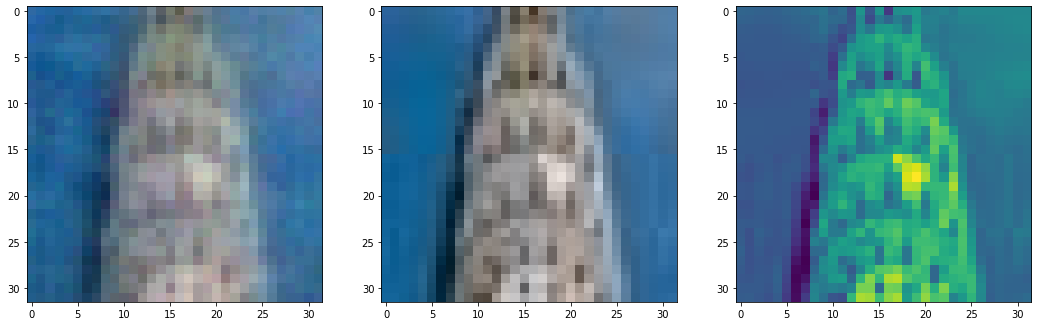

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1080, Total loss 0.003524


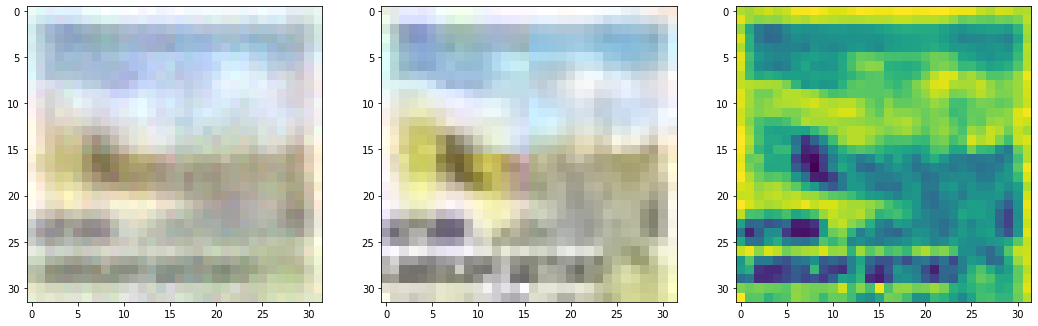

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1090, Total loss 0.003073


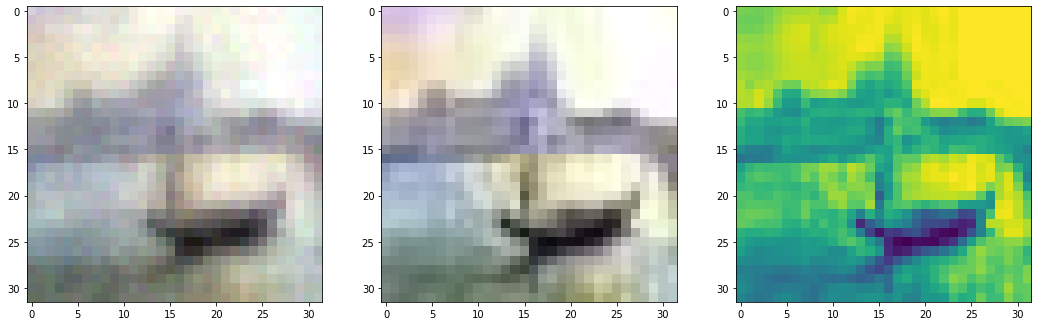

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1100, Total loss 0.003059


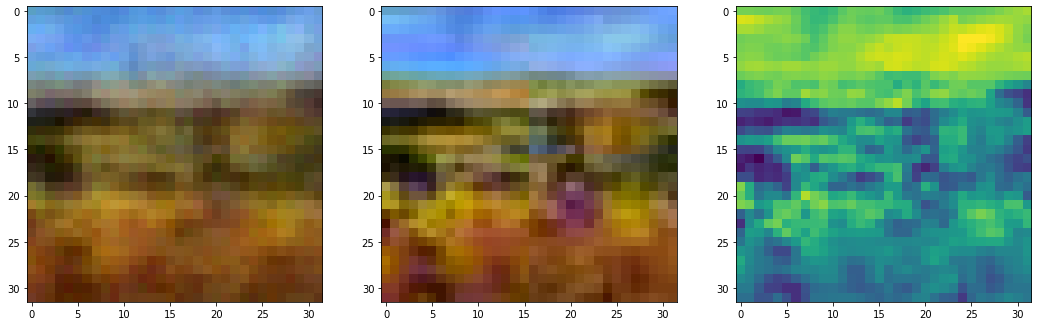

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1110, Total loss 0.003169


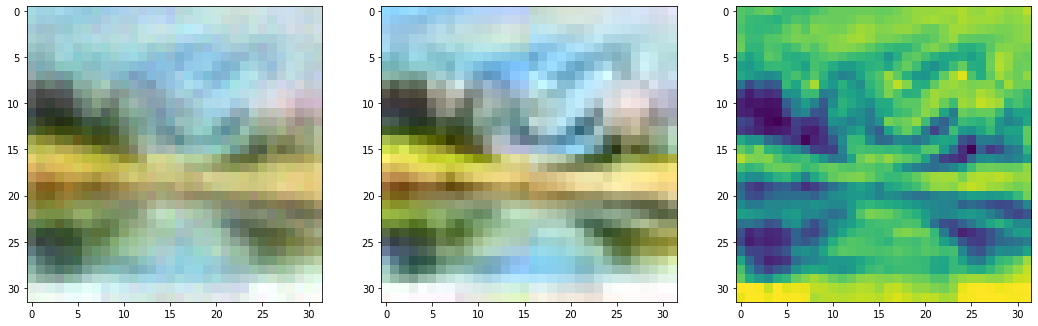

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1120, Total loss 0.003125


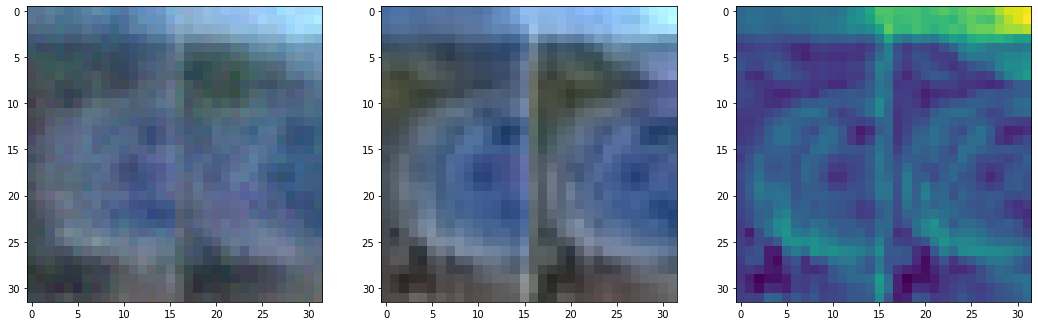

Step 1130, Total loss 0.003031


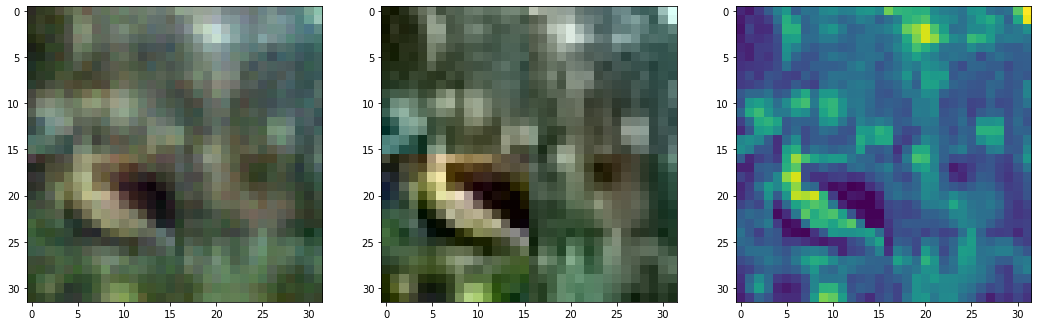

Step 1140, Total loss 0.003256


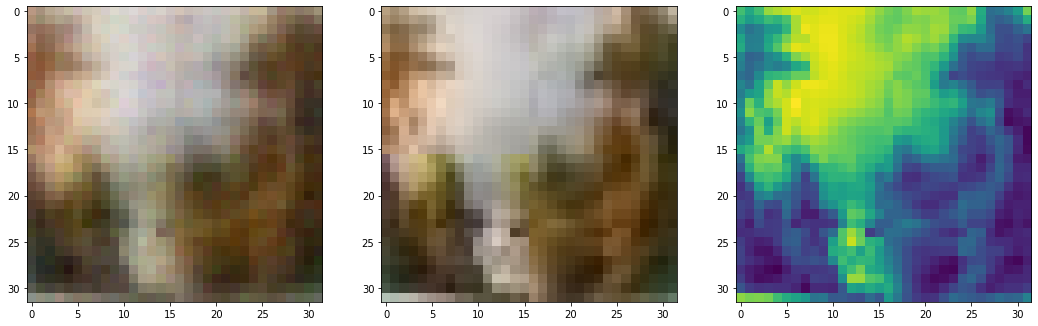

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1150, Total loss 0.003493


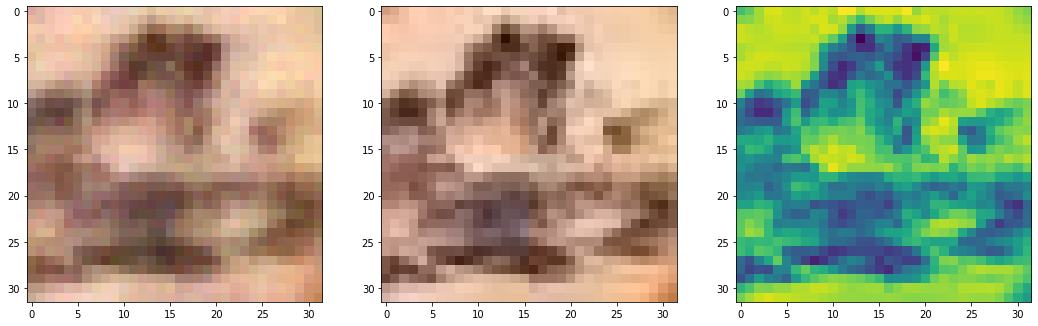

Step 1160, Total loss 0.004061


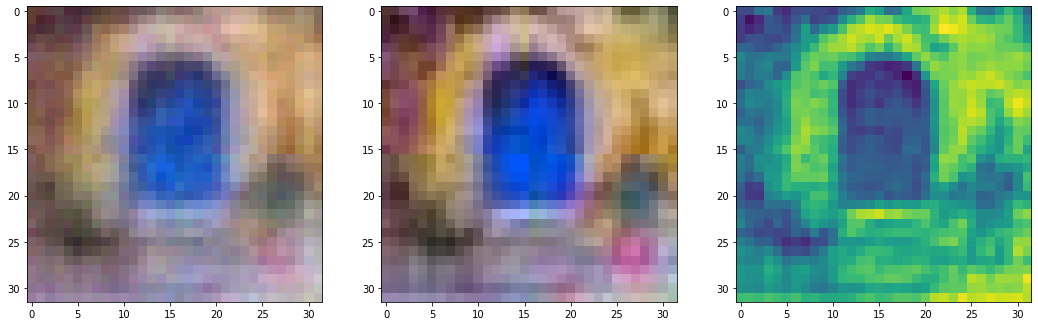

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1170, Total loss 0.002841


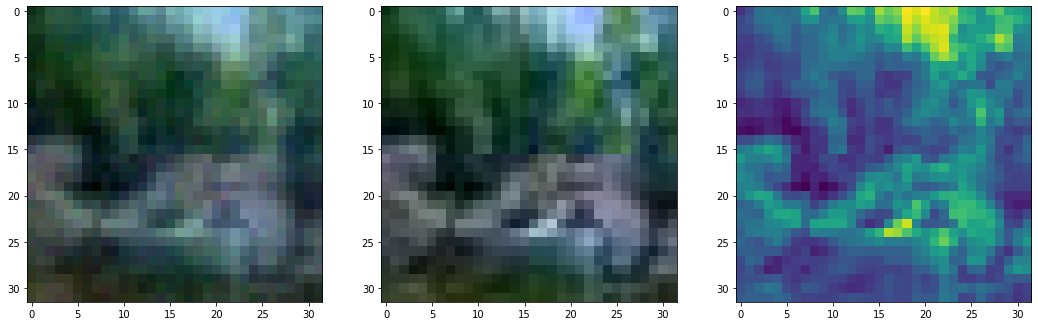

Step 1180, Total loss 0.003101


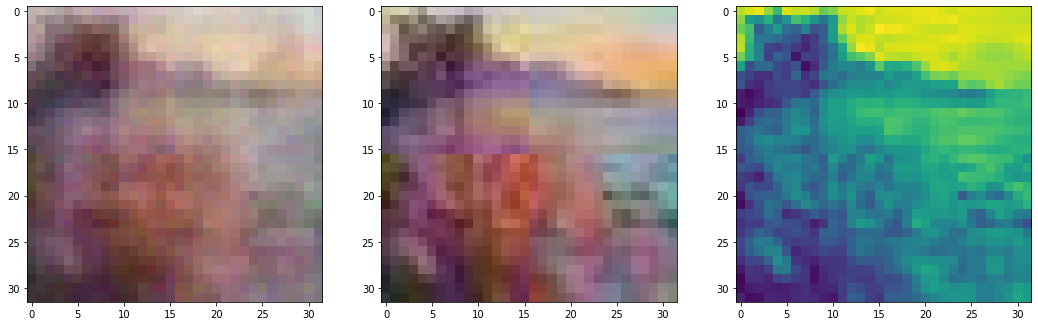

Step 1190, Total loss 0.002888


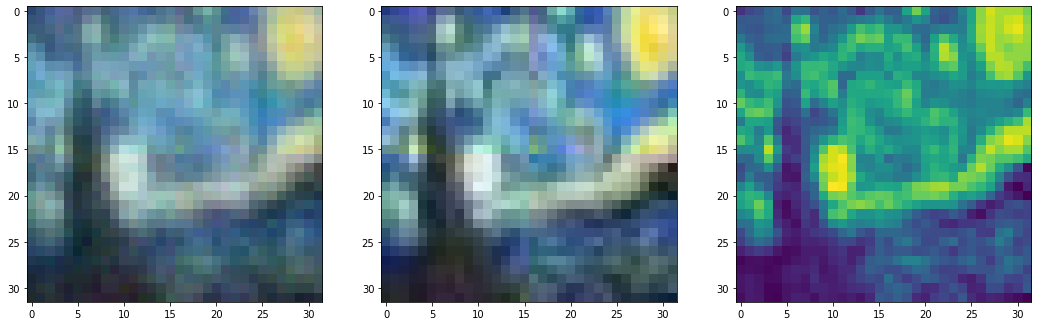

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1200, Total loss 0.002647


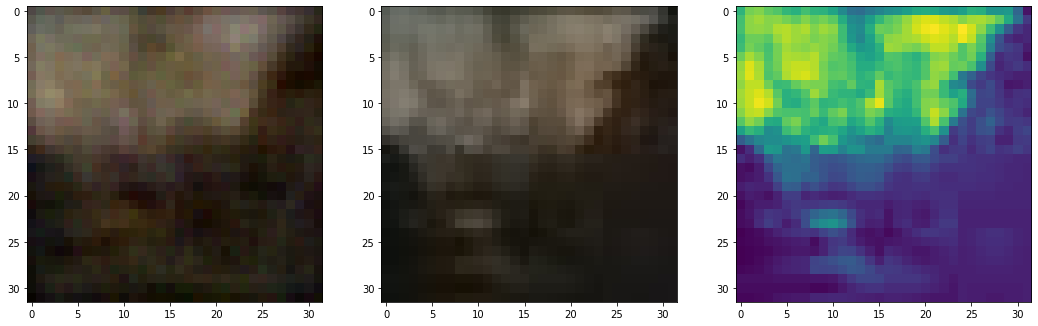

Step 1210, Total loss 0.002864


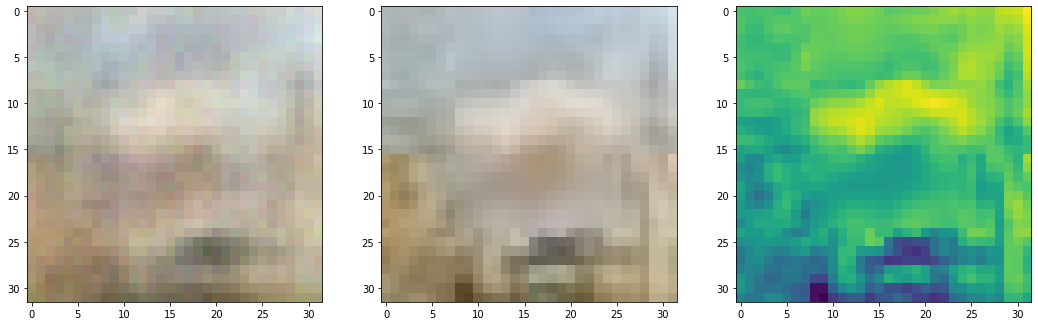

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1220, Total loss 0.002910


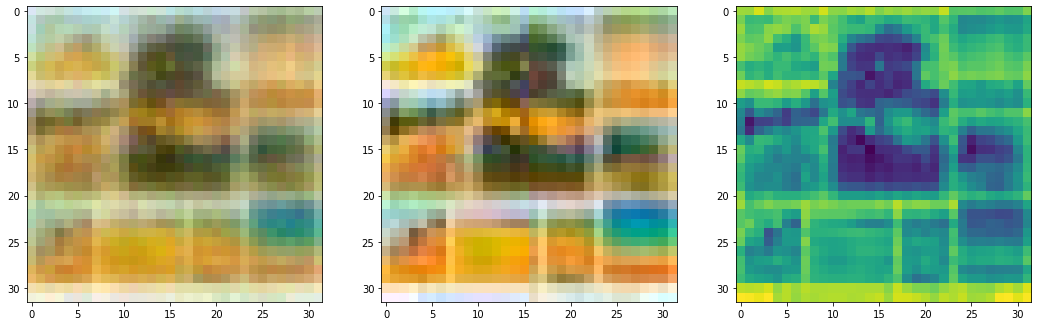

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1230, Total loss 0.003131


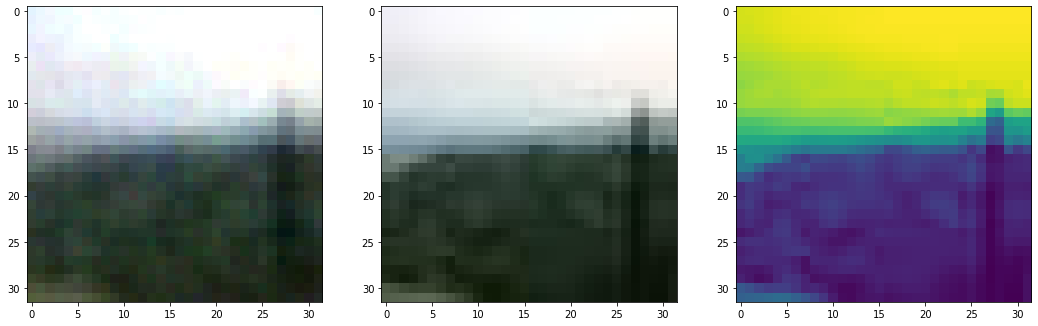

Step 1240, Total loss 0.002947


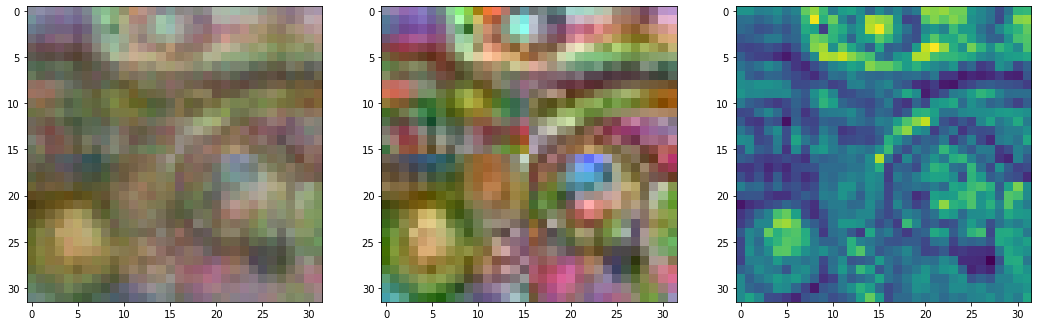

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1250, Total loss 0.002827


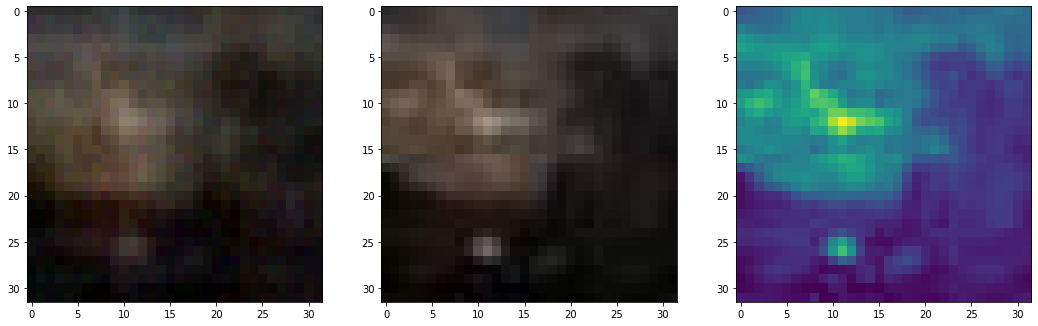

Step 1260, Total loss 0.002334


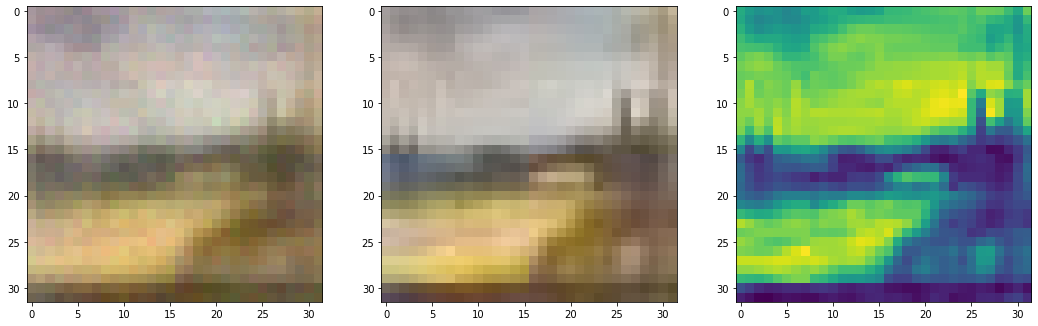

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1270, Total loss 0.002462


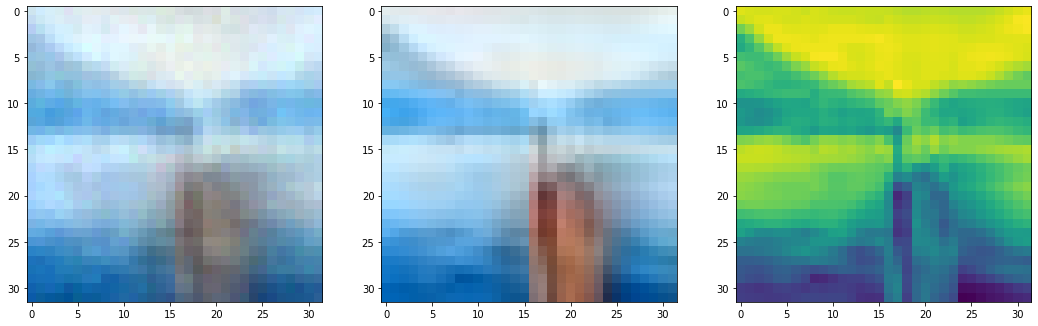

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1280, Total loss 0.002688


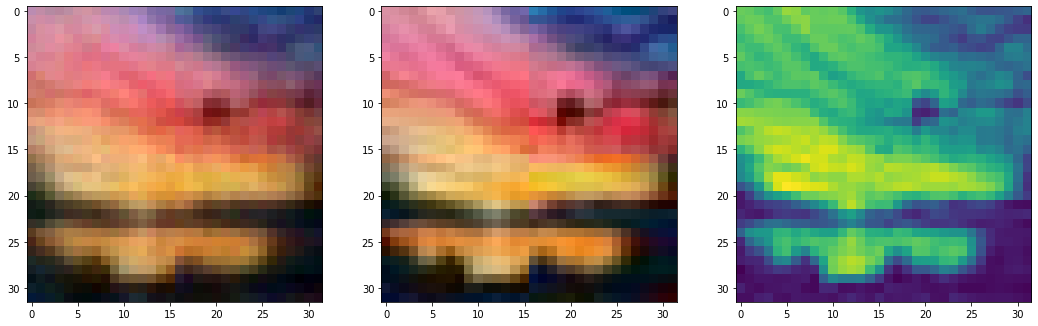

Step 1290, Total loss 0.002768


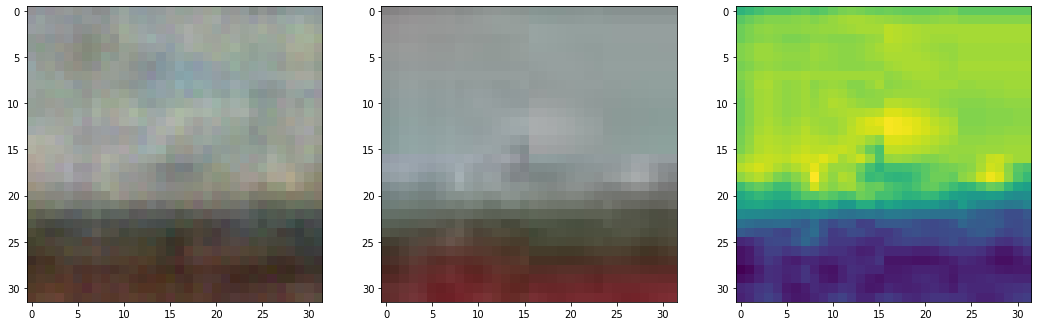

Step 1300, Total loss 0.002568


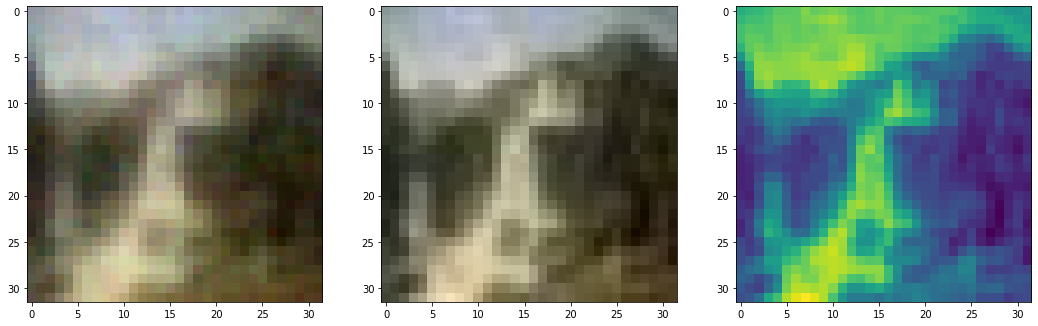

Step 1310, Total loss 0.002311


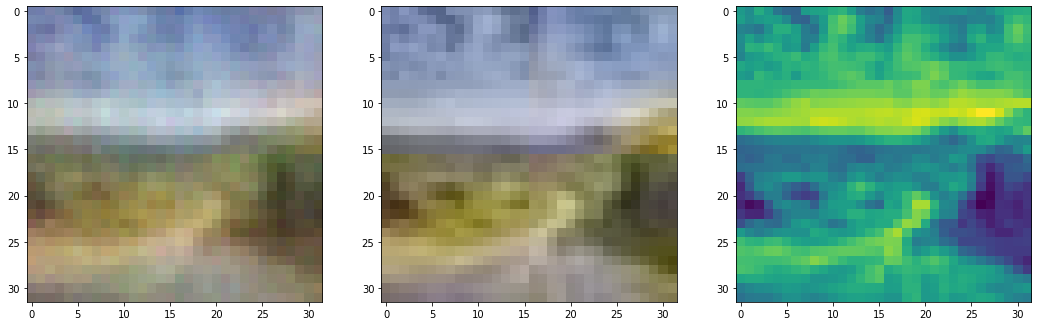

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1320, Total loss 0.002476


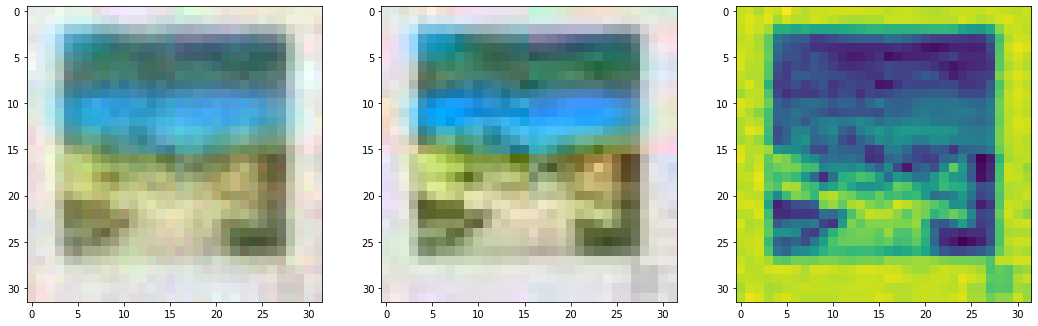

Step 1330, Total loss 0.002505


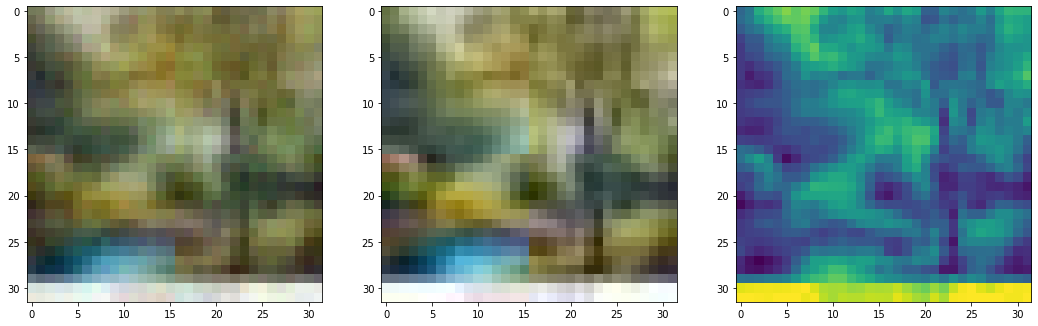

Step 1340, Total loss 0.002135


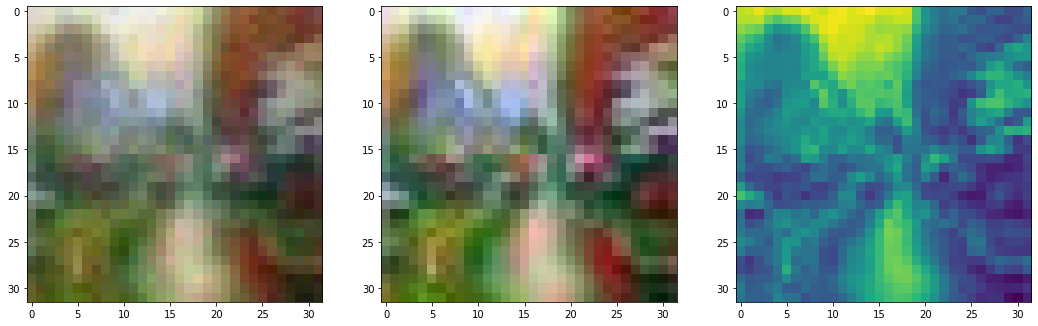

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1350, Total loss 0.002050


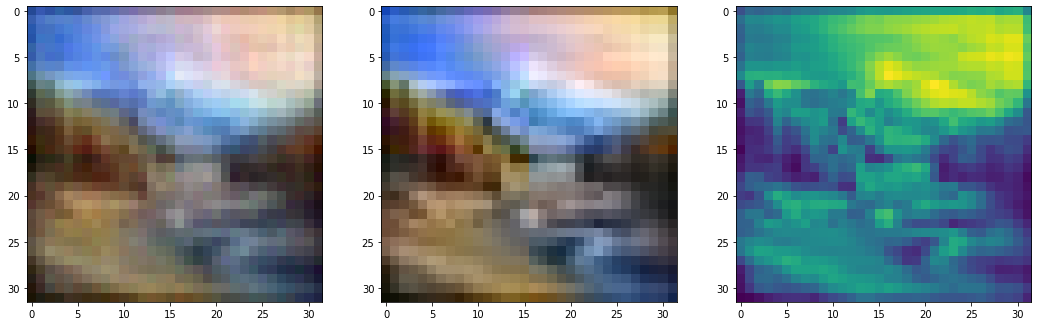

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1360, Total loss 0.002196


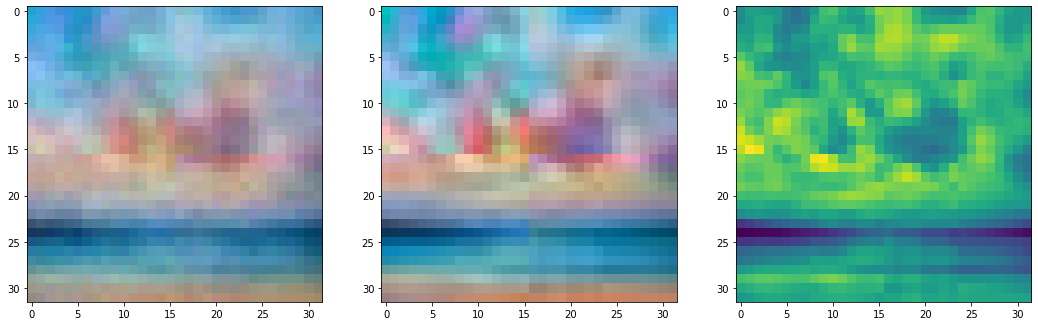

Step 1370, Total loss 0.002297


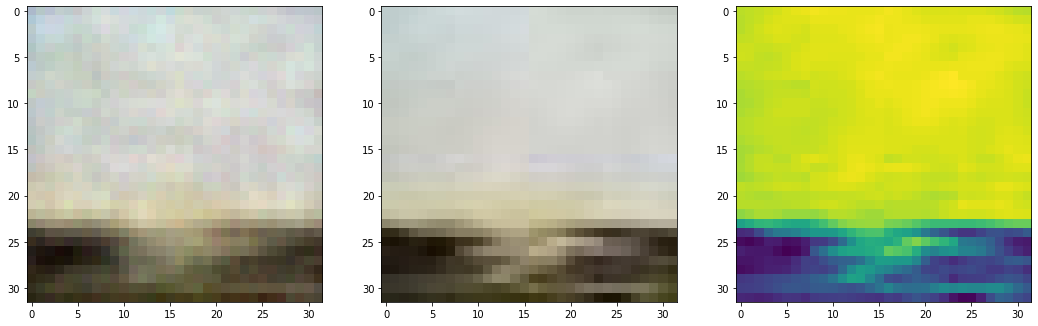

Step 1380, Total loss 0.002315


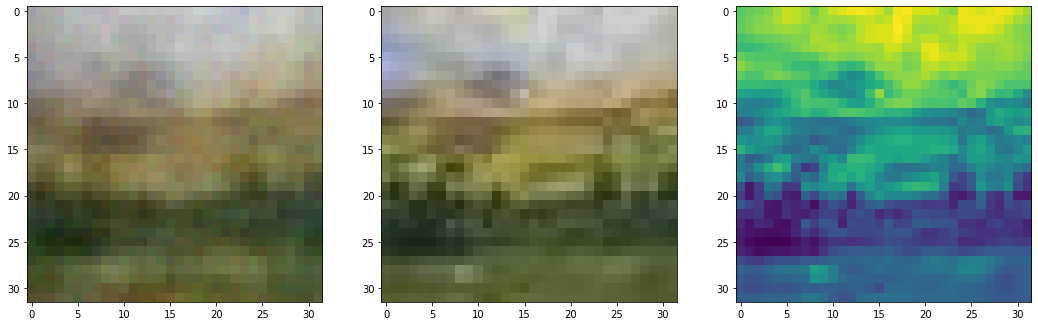

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1390, Total loss 0.001995


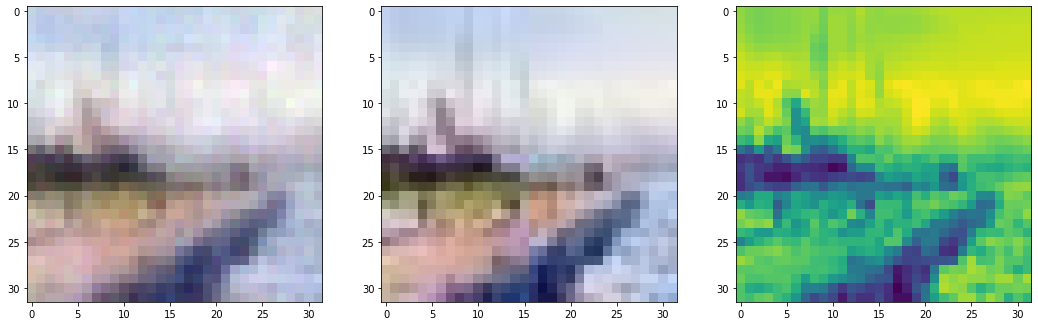

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1400, Total loss 0.001967


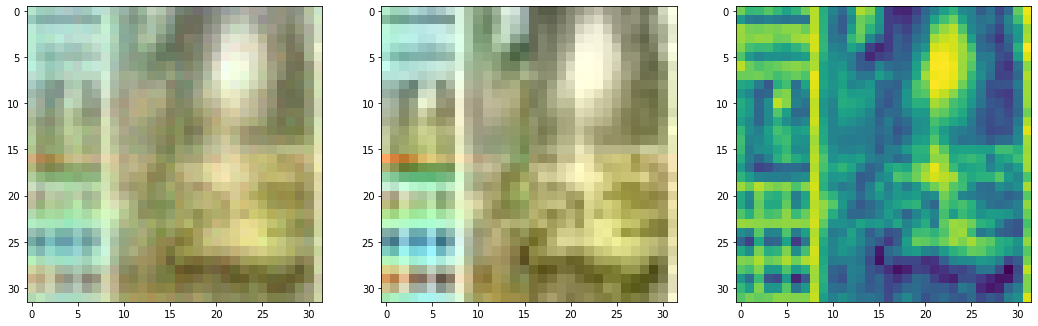

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1410, Total loss 0.001983


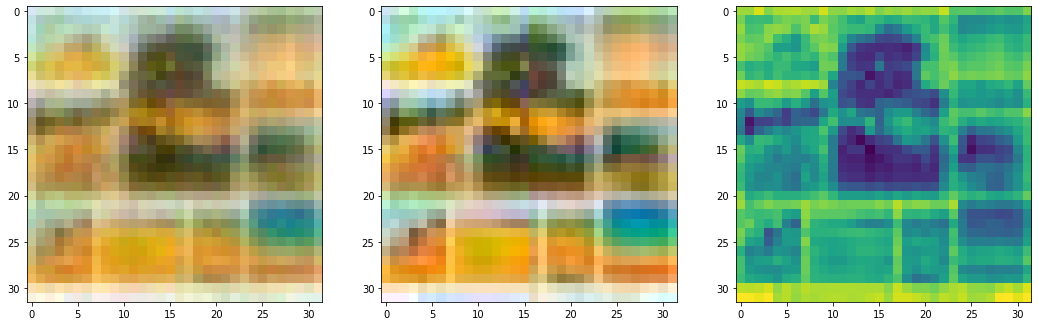

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1420, Total loss 0.002131


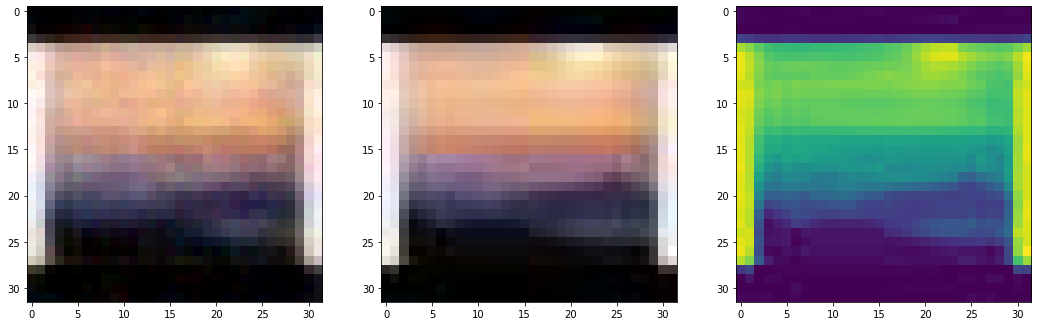

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1430, Total loss 0.001776


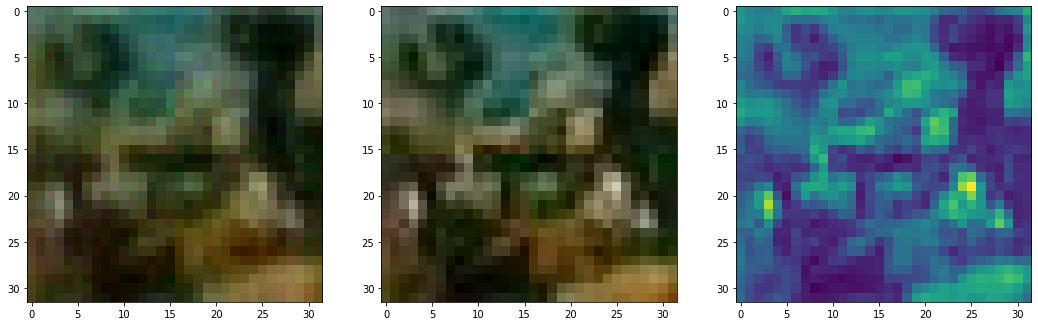

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1440, Total loss 0.002074


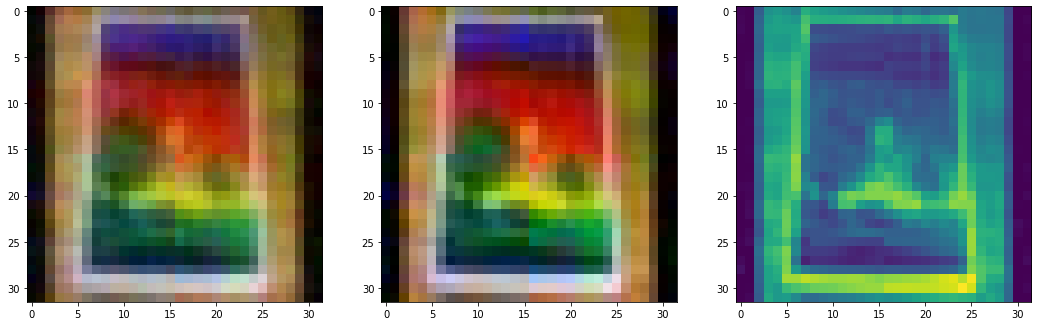

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1450, Total loss 0.002220


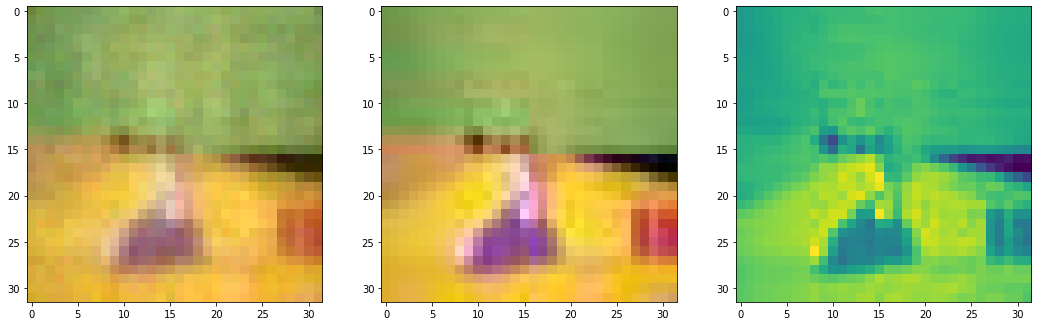

Step 1460, Total loss 0.001862


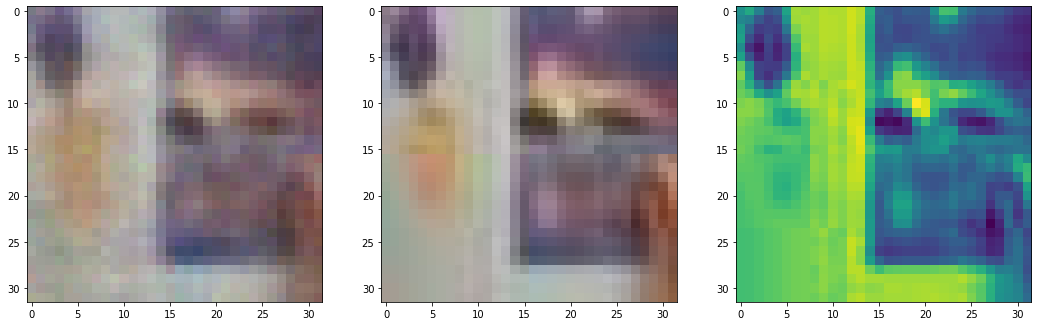

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1470, Total loss 0.001820


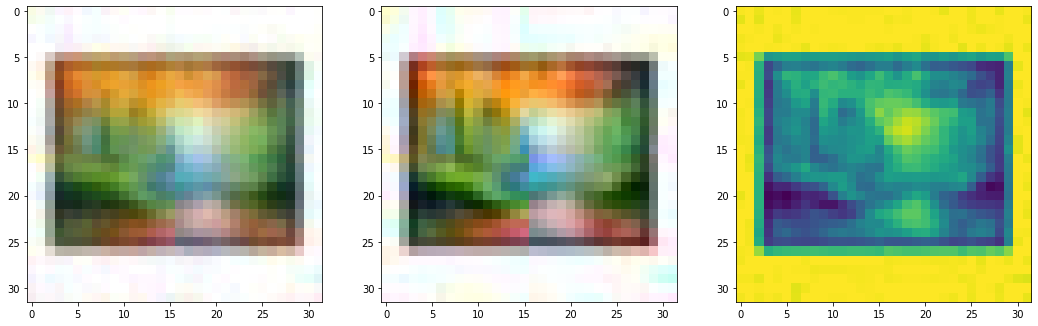

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1480, Total loss 0.001790


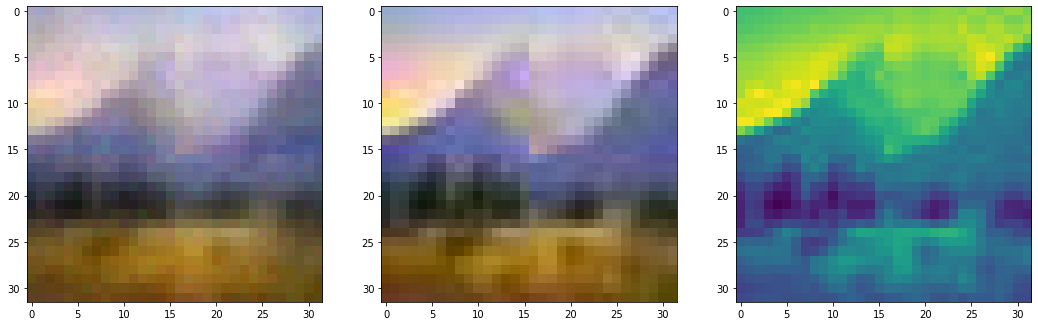

Step 1490, Total loss 0.002133


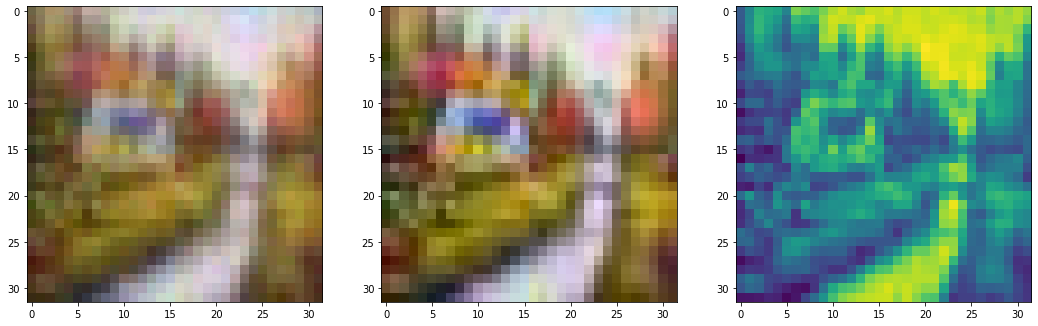

Step 1500, Total loss 0.001921


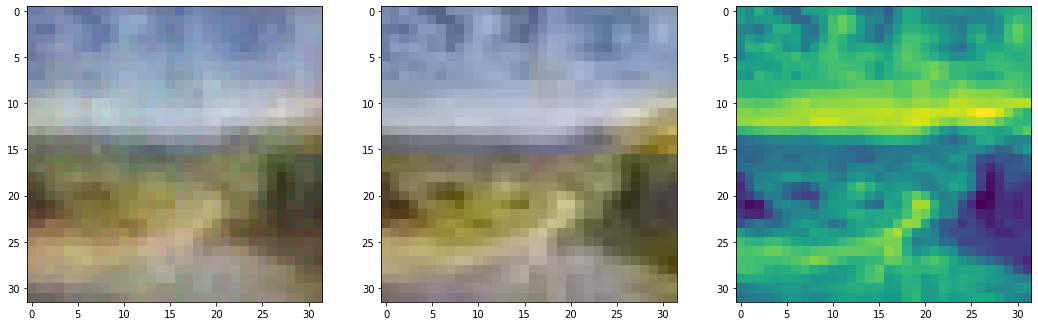

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1510, Total loss 0.002142


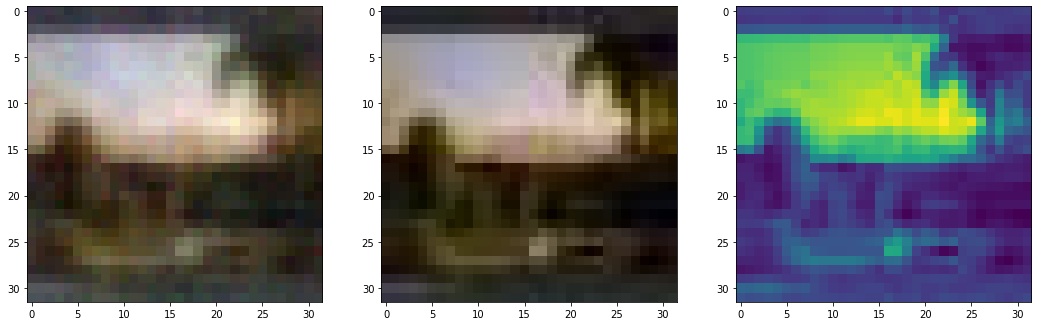

Step 1520, Total loss 0.001939


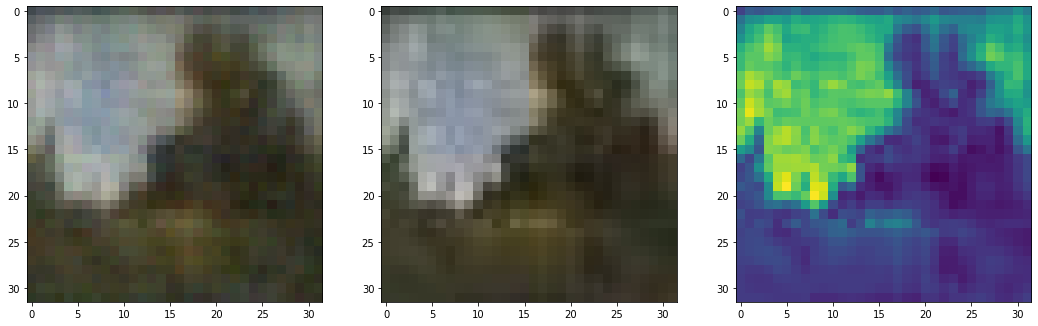

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1530, Total loss 0.001941


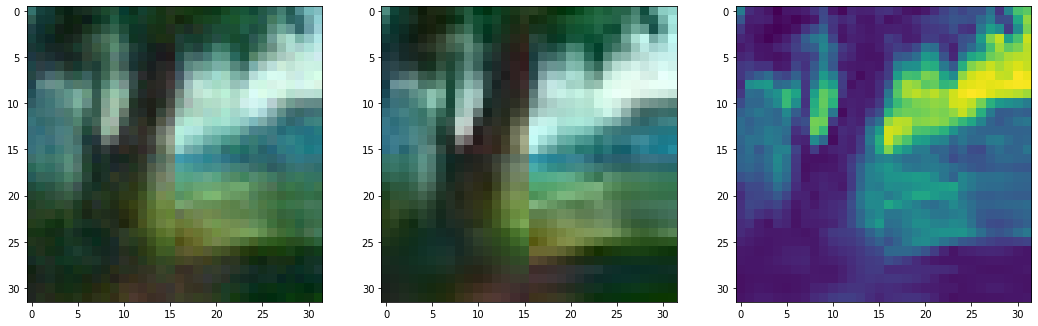

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1540, Total loss 0.002010


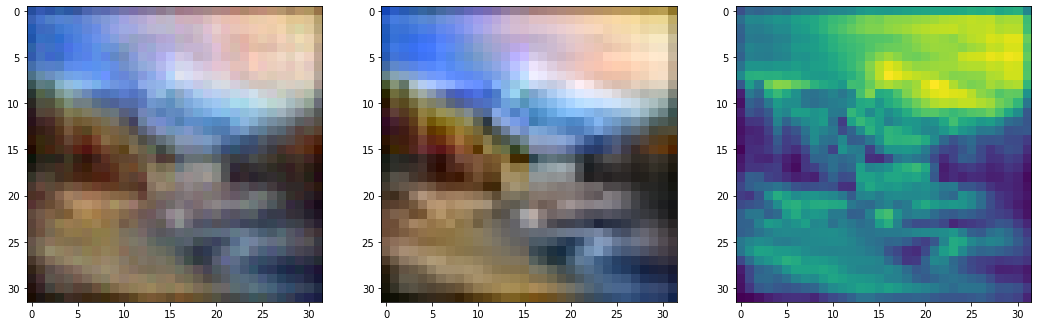

Step 1550, Total loss 0.001970


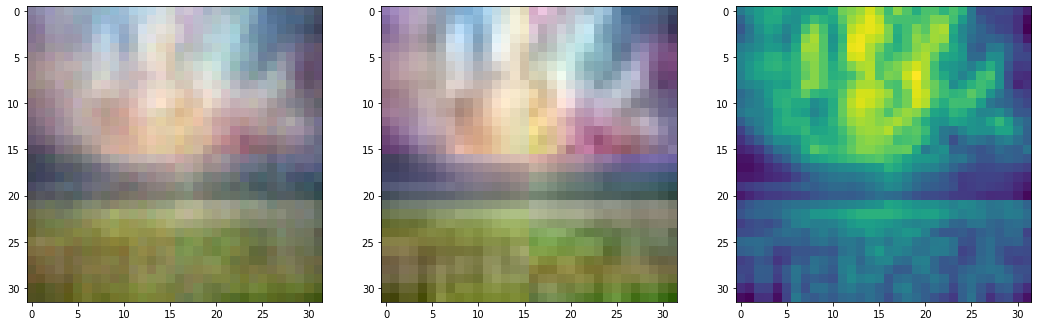

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1560, Total loss 0.001996


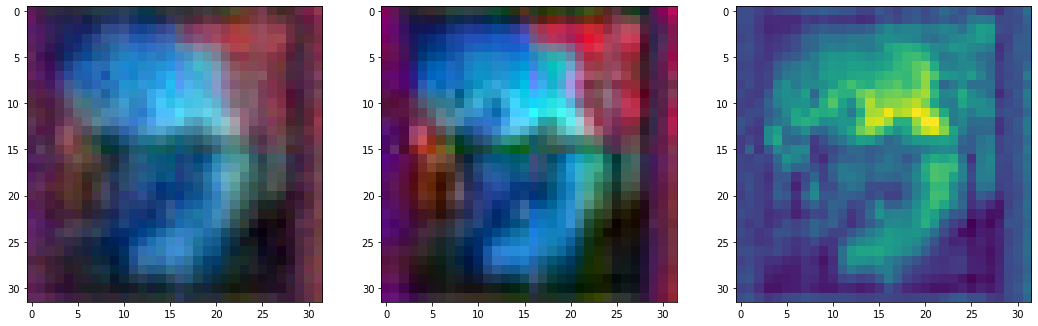

Step 1570, Total loss 0.001898


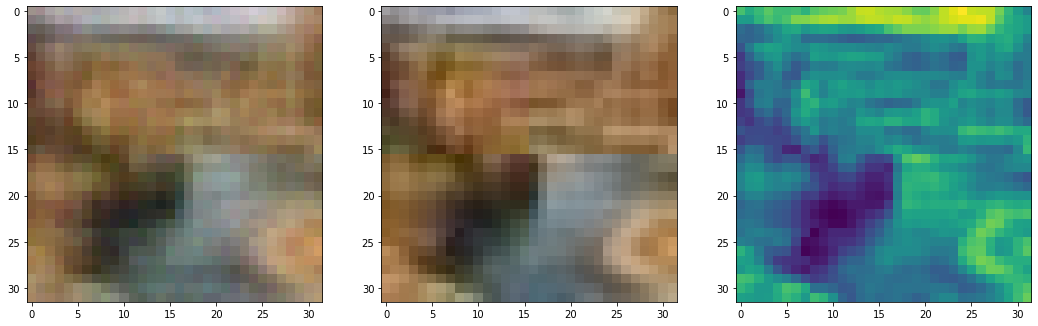

Step 1580, Total loss 0.001716


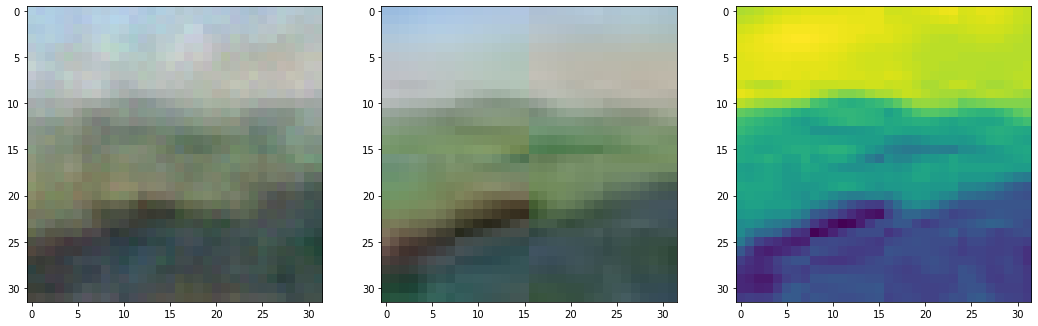

Step 1590, Total loss 0.001960


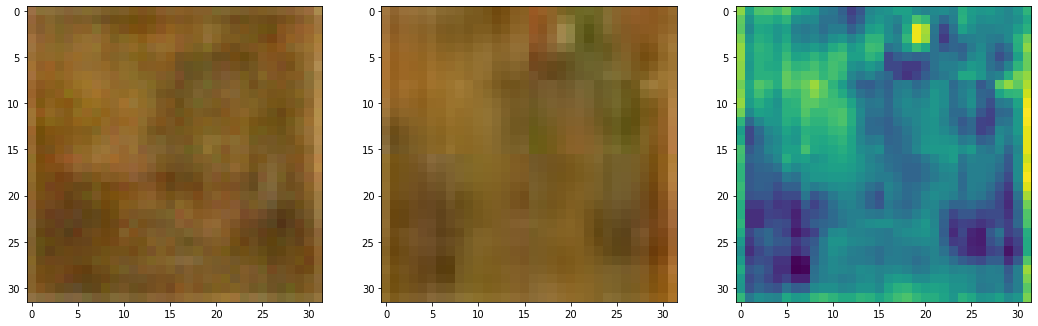

Step 1600, Total loss 0.002301


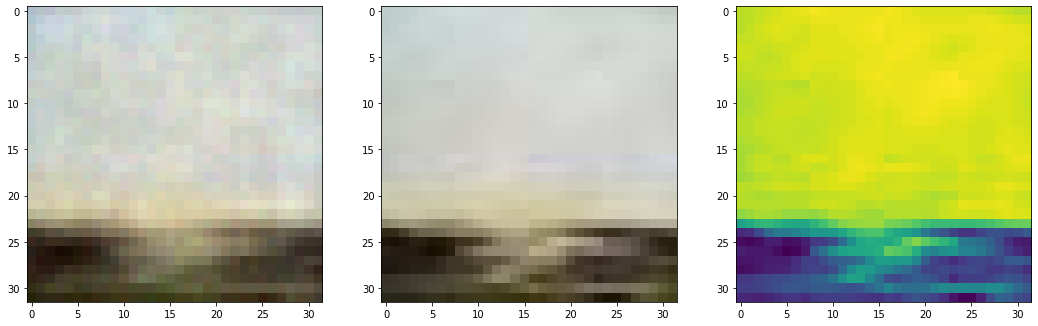

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1610, Total loss 0.002067


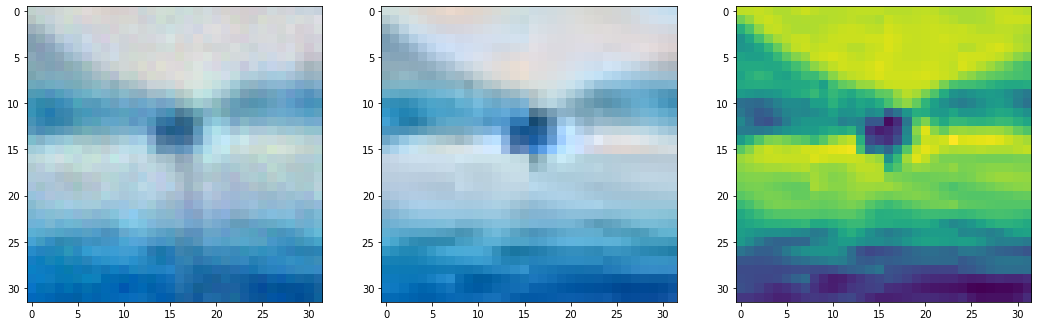

Step 1620, Total loss 0.001926


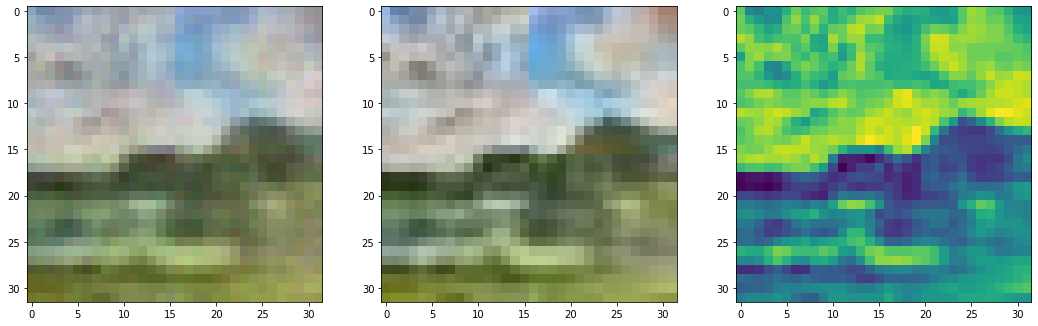

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1630, Total loss 0.002007


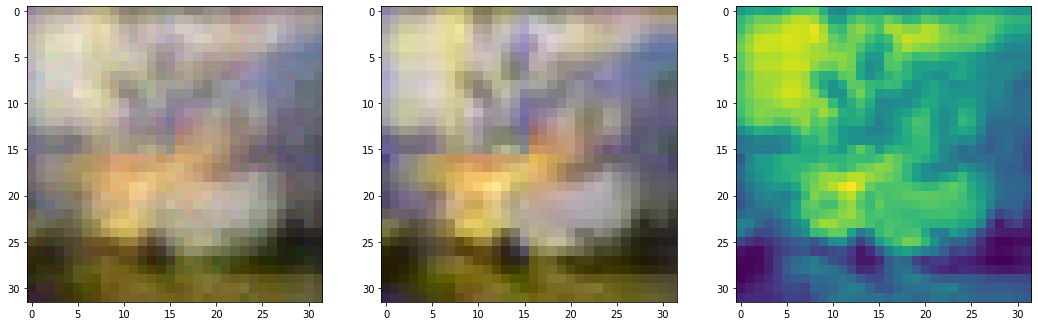

Step 1640, Total loss 0.001687


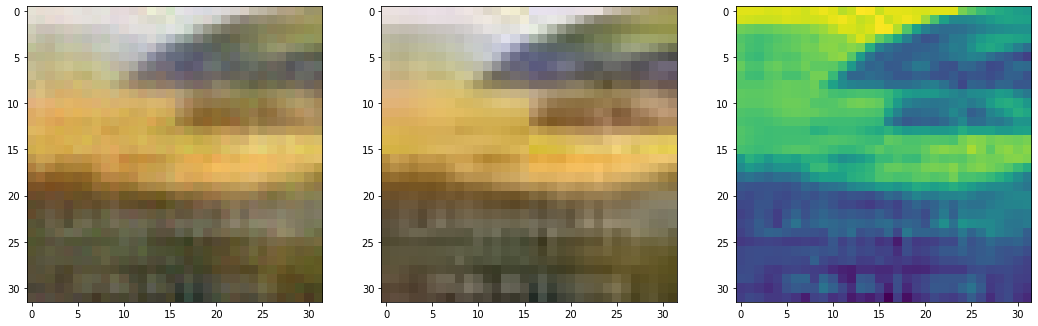

Step 1650, Total loss 0.001581


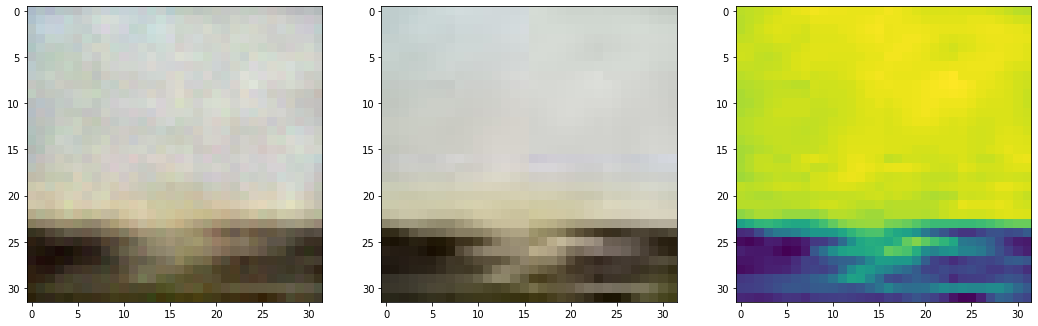

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1660, Total loss 0.001886


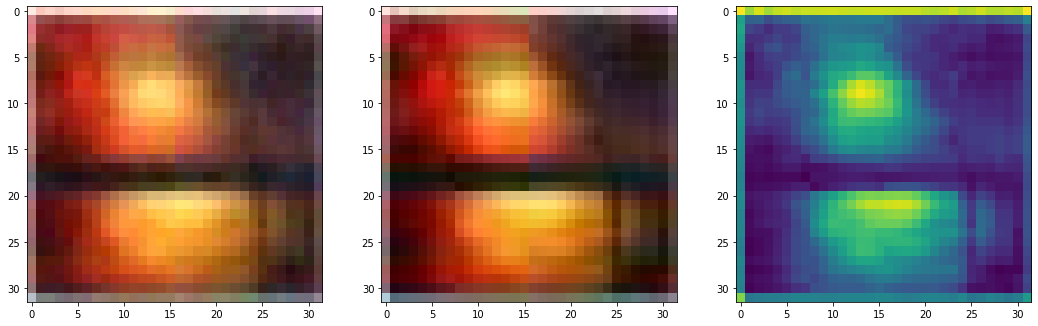

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1670, Total loss 0.001828


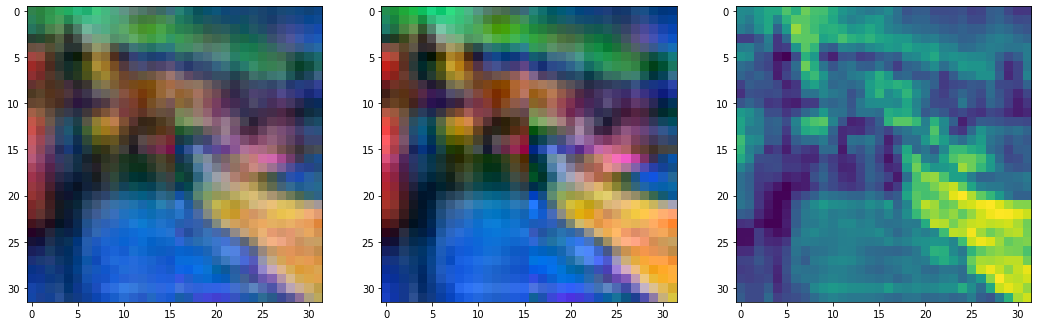

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1680, Total loss 0.001889


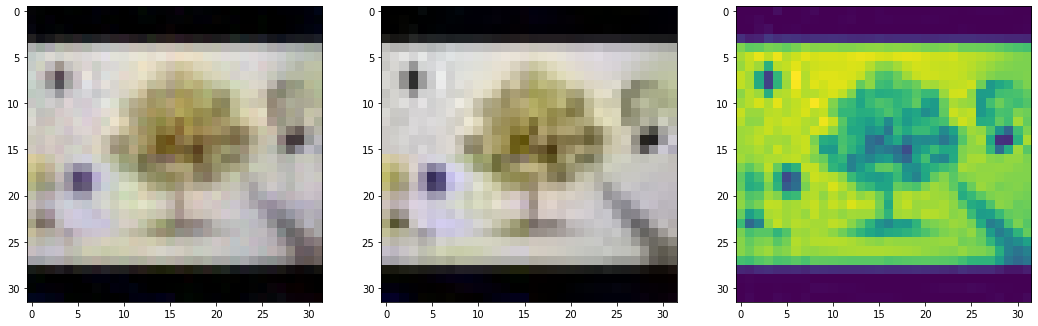

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1690, Total loss 0.001822


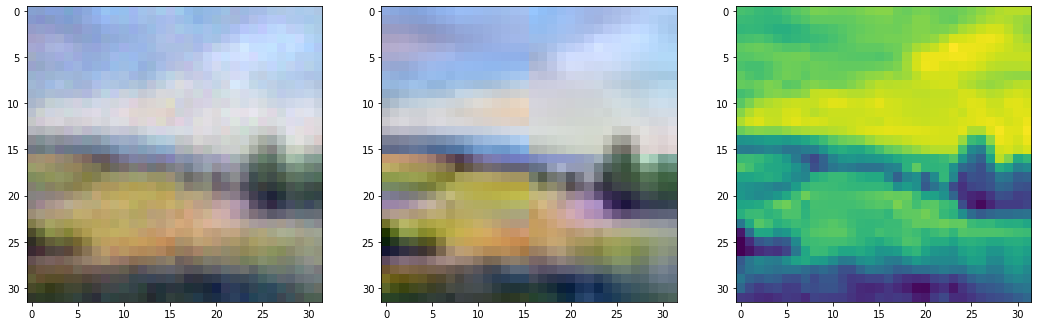

Step 1700, Total loss 0.001811


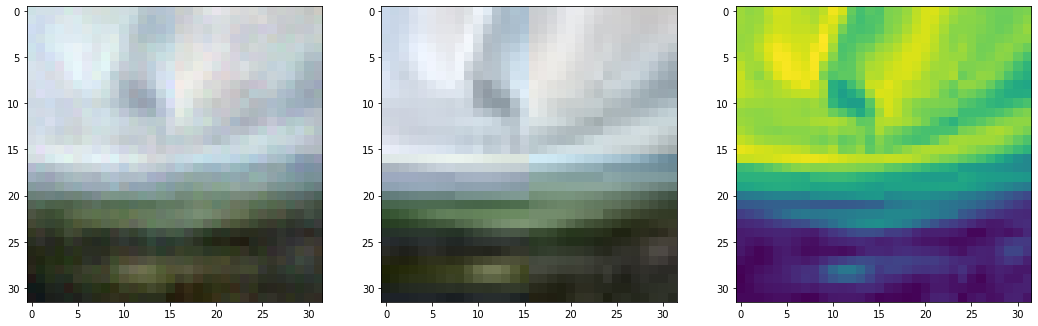

Step 1710, Total loss 0.001690


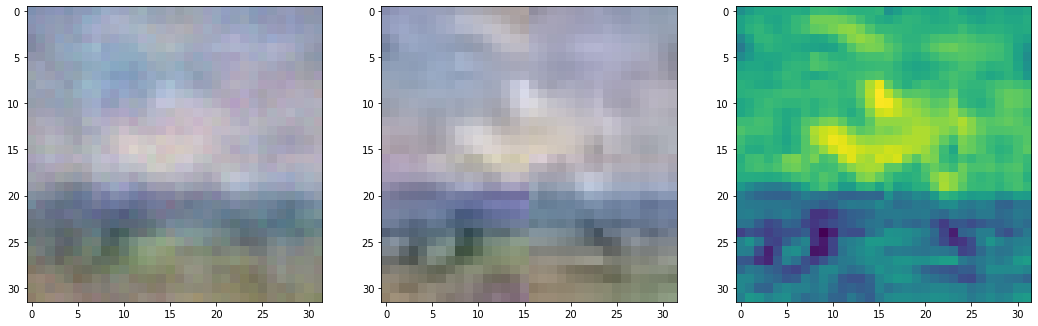

Step 1720, Total loss 0.001529


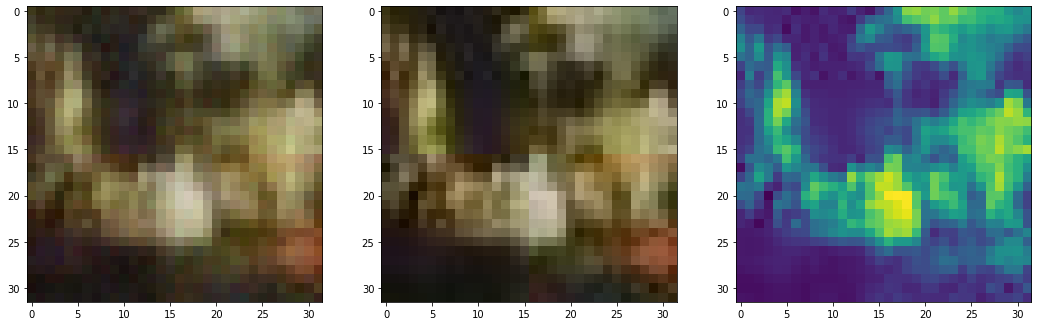

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1730, Total loss 0.001597


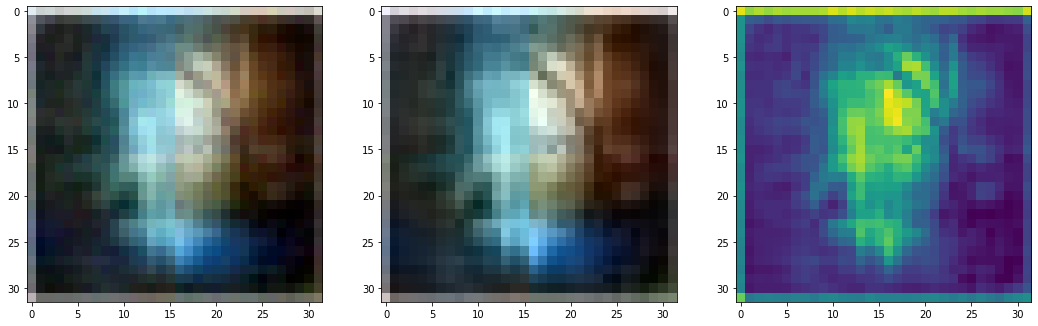

Step 1740, Total loss 0.001464


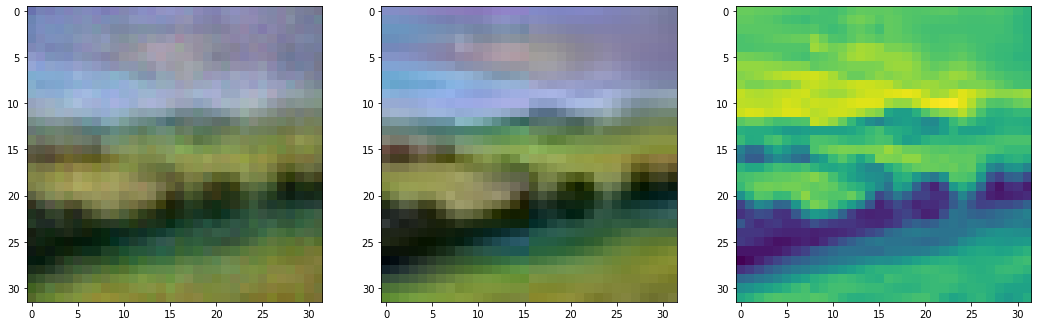

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1750, Total loss 0.001554


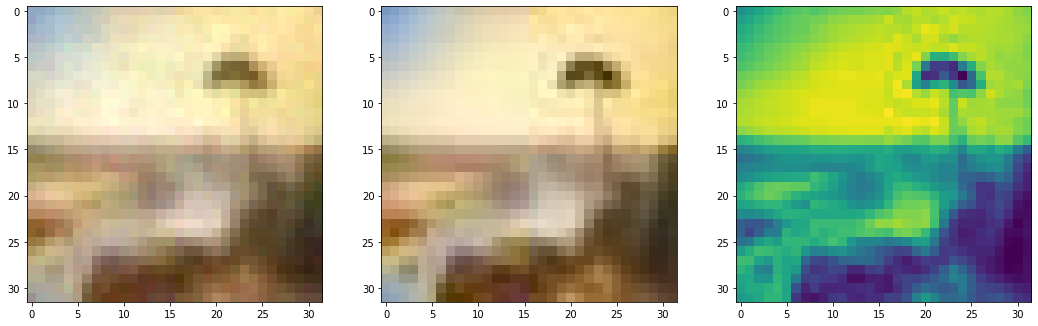

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1760, Total loss 0.001795


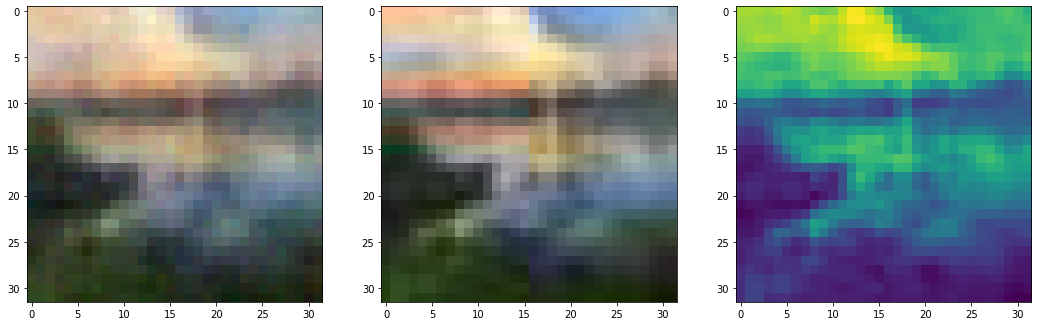

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1770, Total loss 0.001425


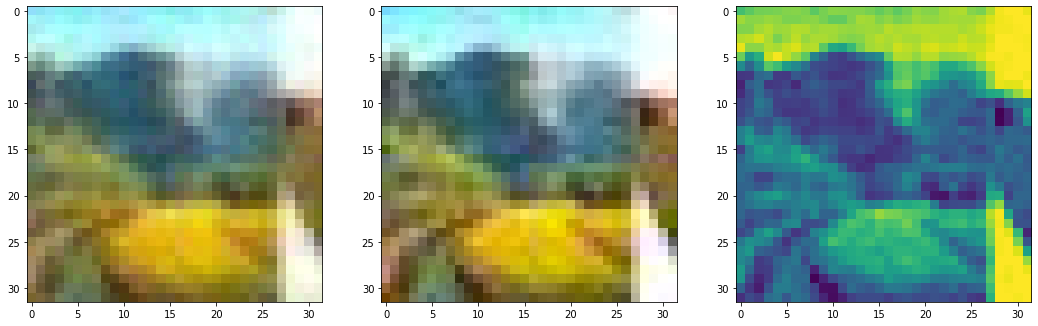

Step 1780, Total loss 0.001827


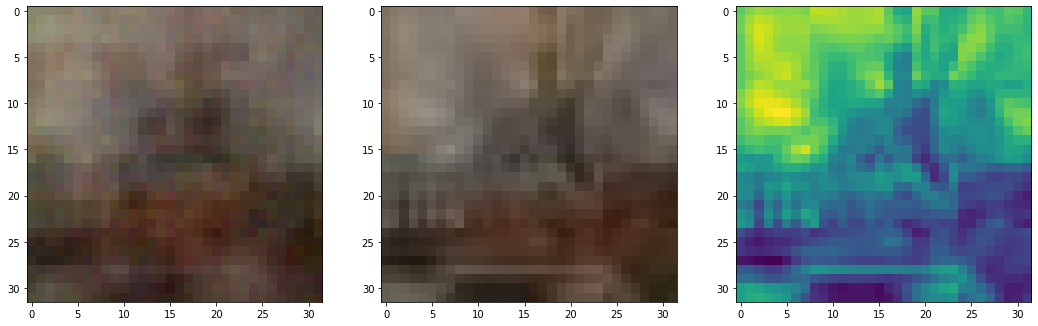

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1790, Total loss 0.001498


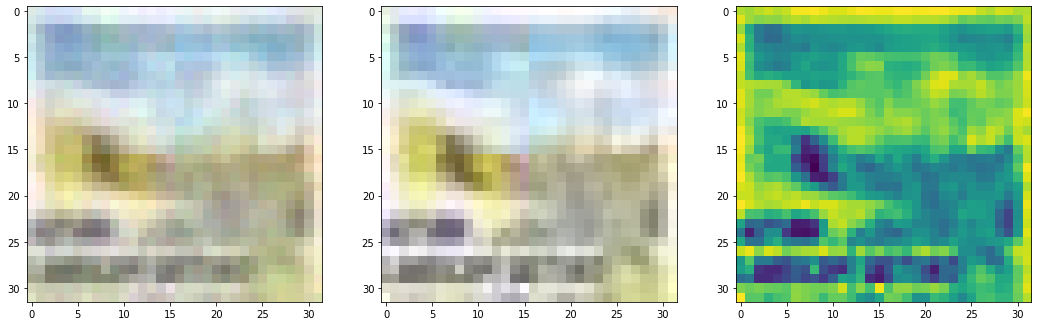

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1800, Total loss 0.001424


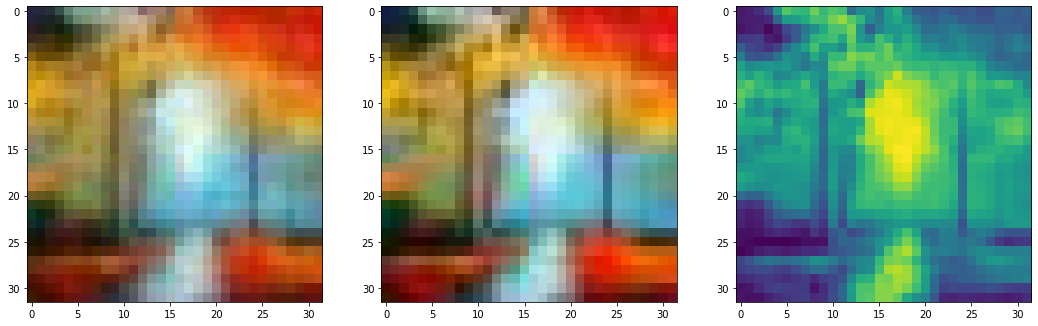

Step 1810, Total loss 0.001540


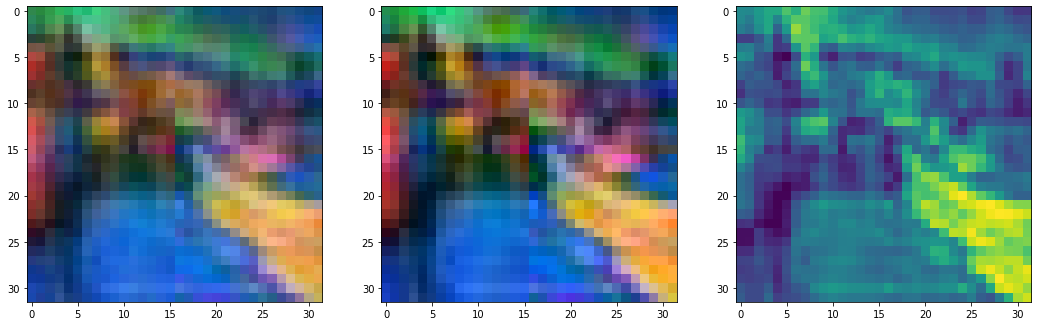

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1820, Total loss 0.001399


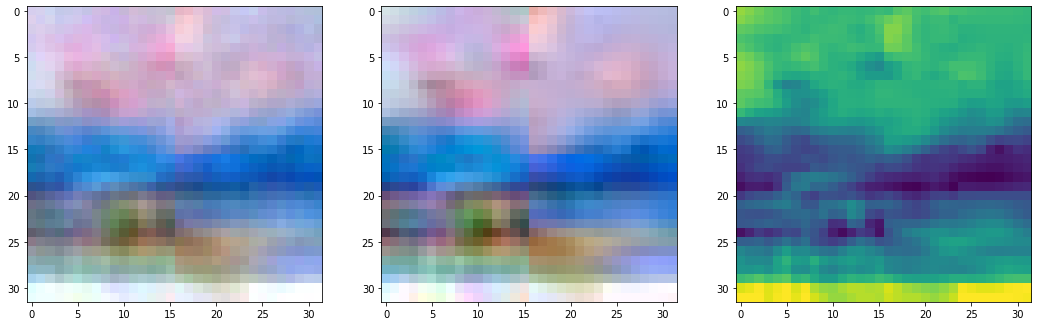

Step 1830, Total loss 0.001364


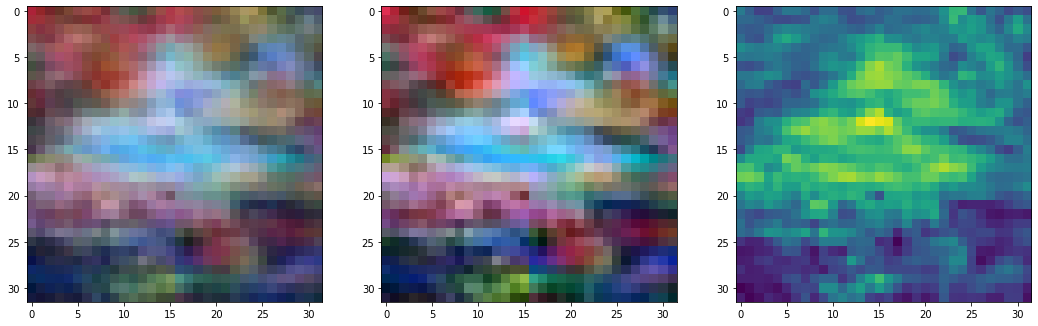

Step 1840, Total loss 0.001359


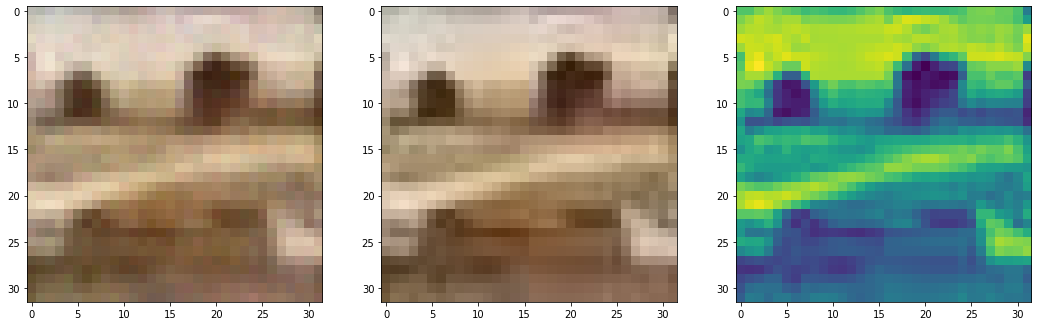

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1850, Total loss 0.001654


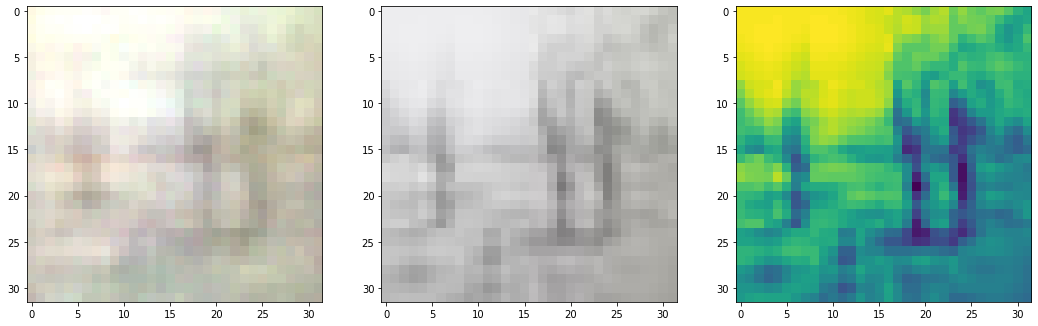

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1860, Total loss 0.001344


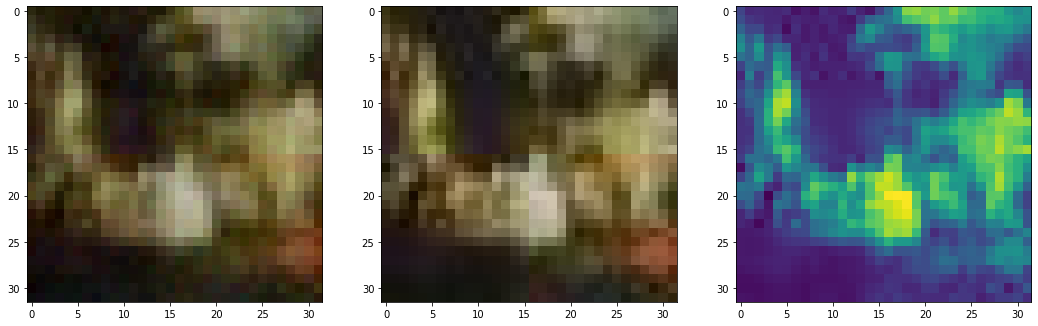

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1870, Total loss 0.001508


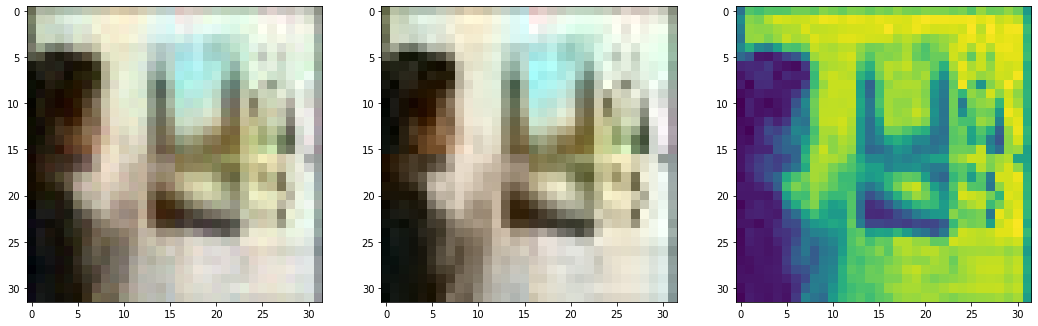

Step 1880, Total loss 0.001452


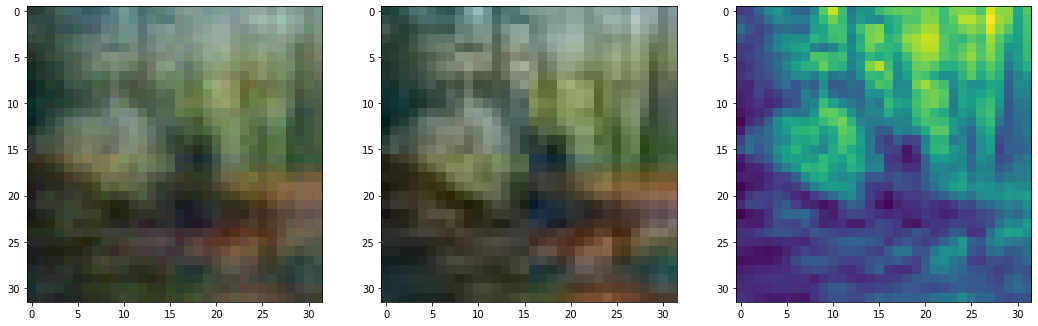

Step 1890, Total loss 0.001250


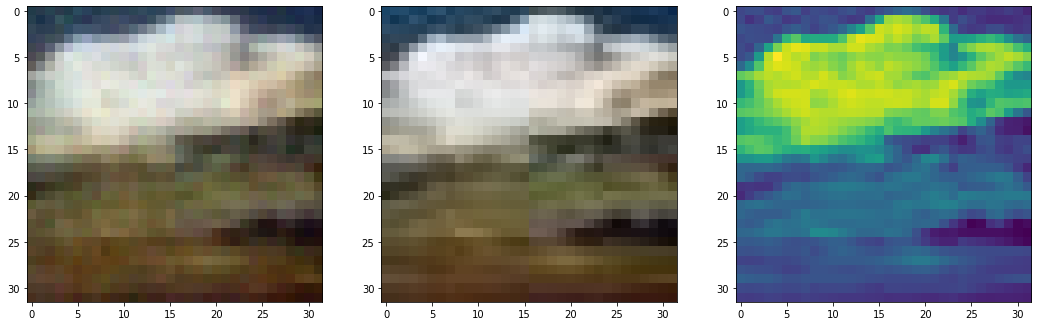

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1900, Total loss 0.001347


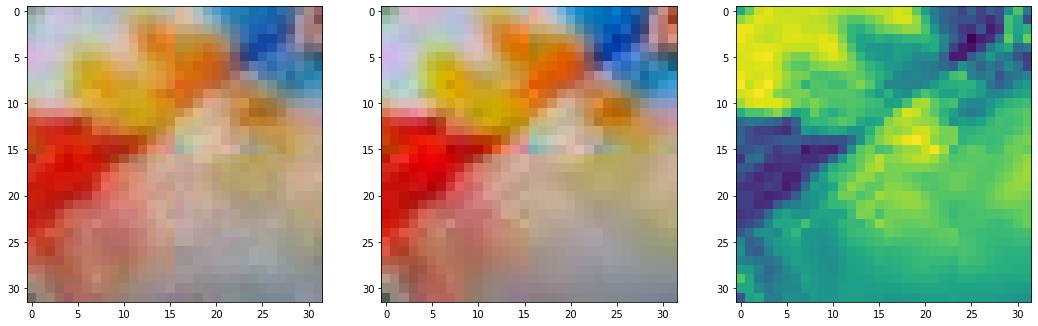

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1910, Total loss 0.001438


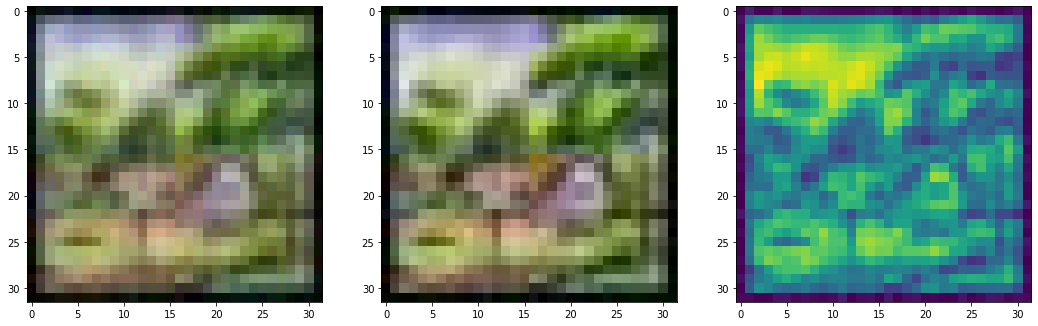

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1920, Total loss 0.001702


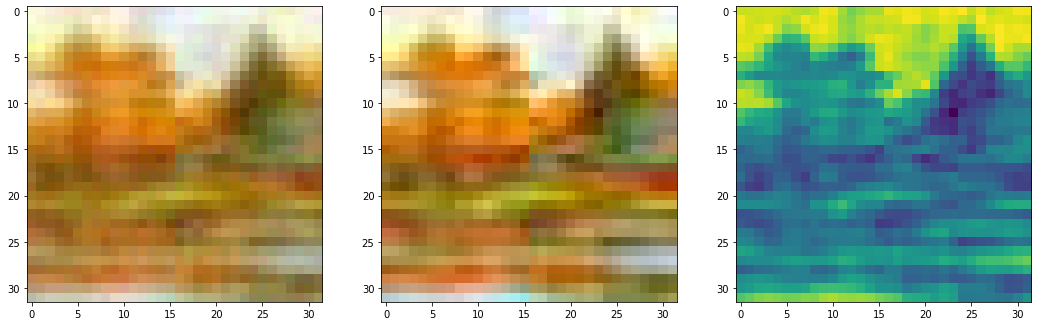

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1930, Total loss 0.001382


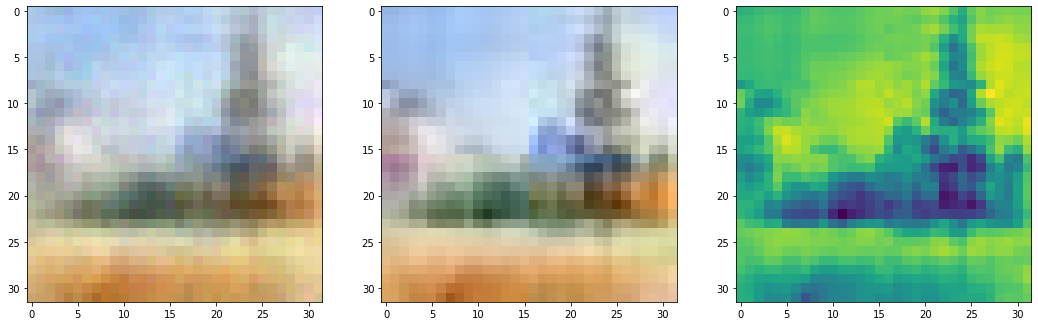

Step 1940, Total loss 0.001334


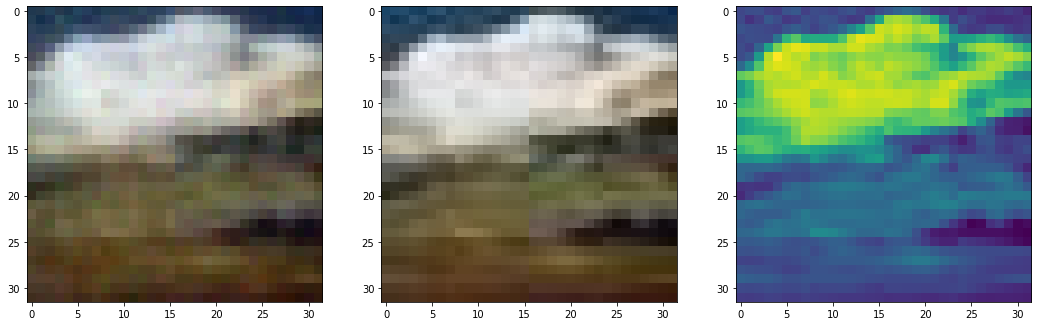

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1950, Total loss 0.001279


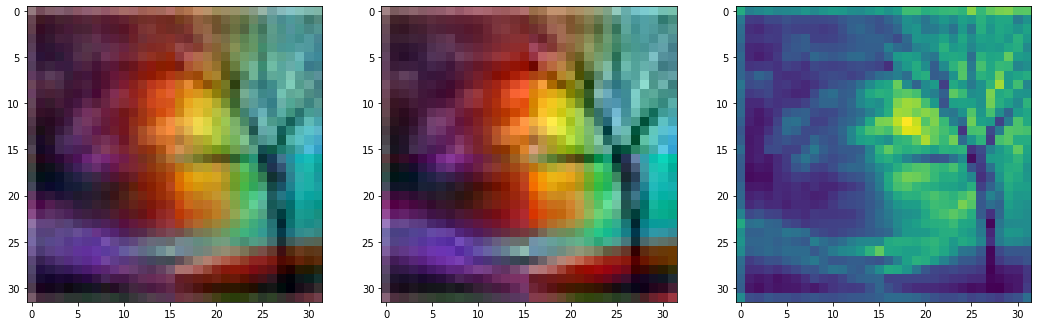

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1960, Total loss 0.001500


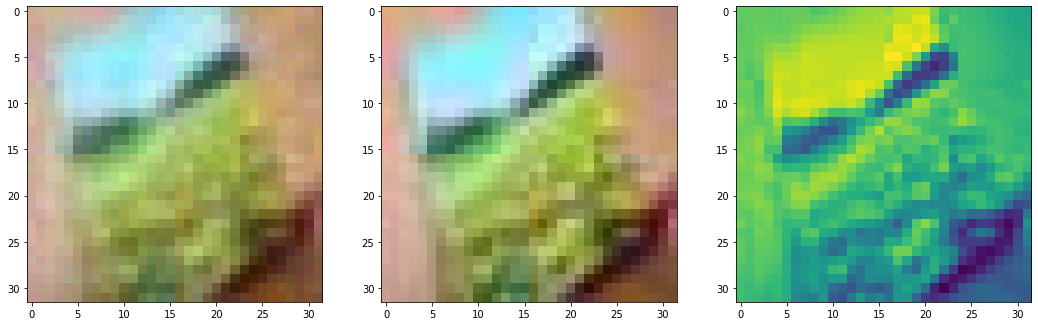

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1970, Total loss 0.001256


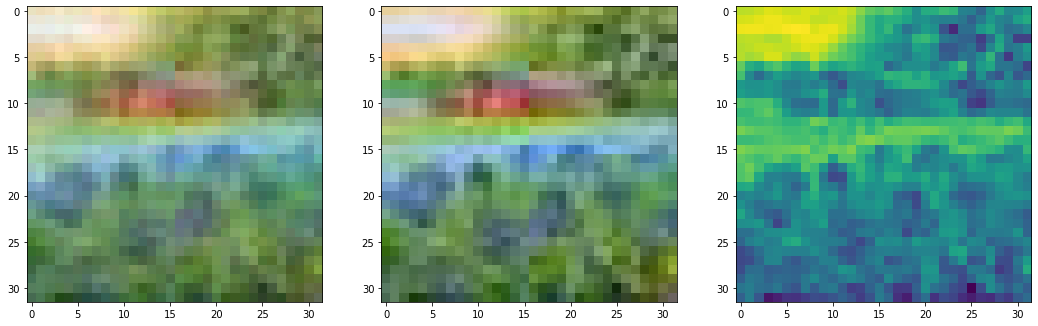

Step 1980, Total loss 0.001187


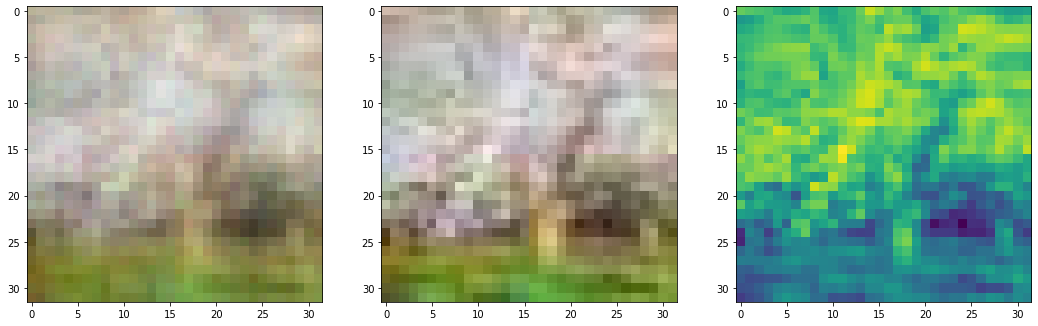

Step 1990, Total loss 0.001213


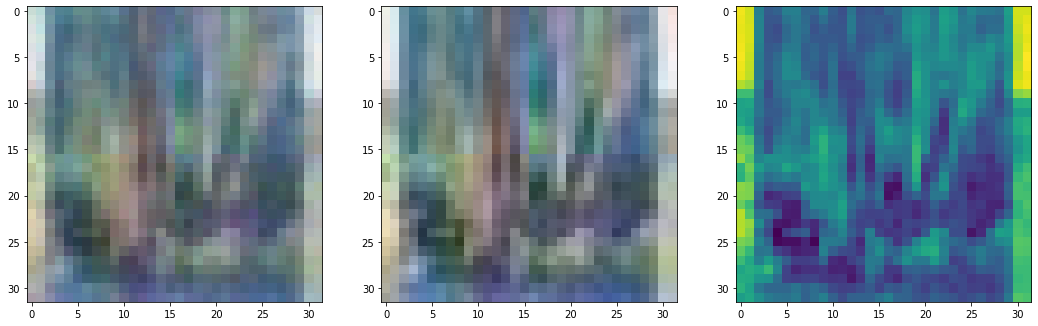

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000, Total loss 0.001085


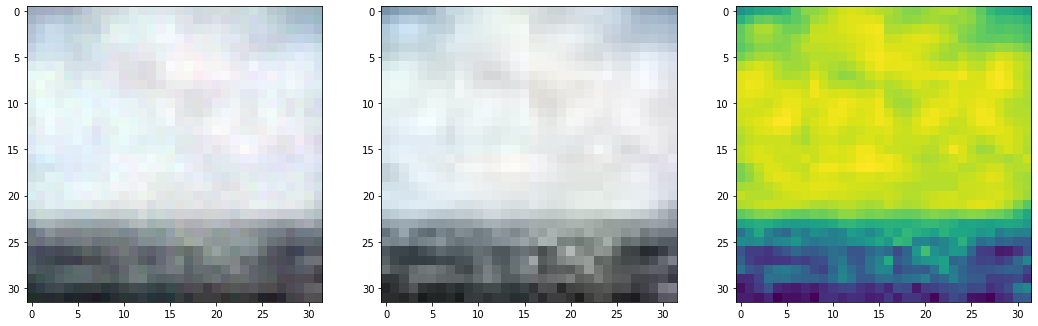

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2010, Total loss 0.001185


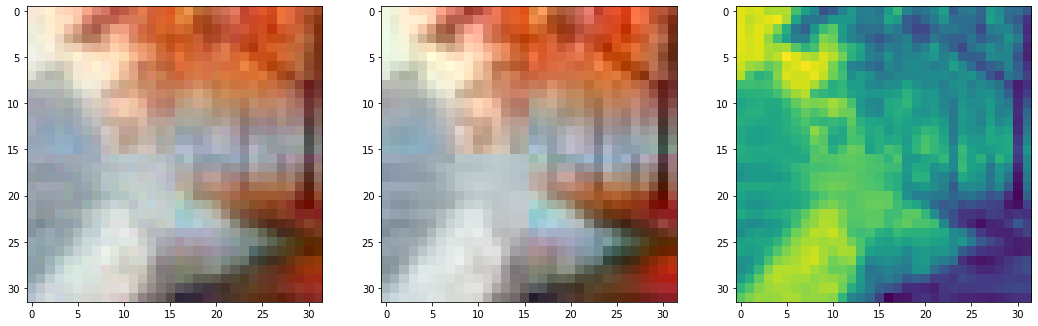

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2020, Total loss 0.001115


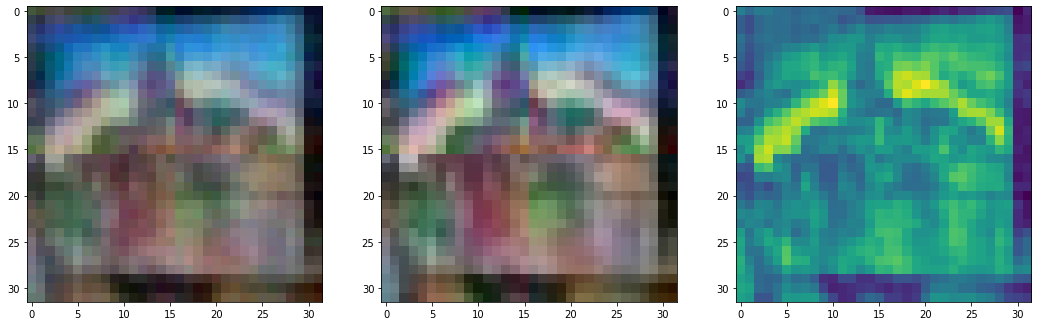

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2030, Total loss 0.001194


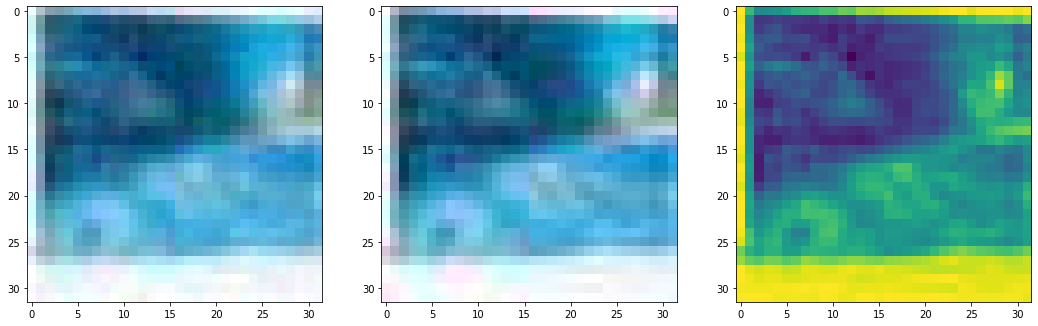

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2040, Total loss 0.001084


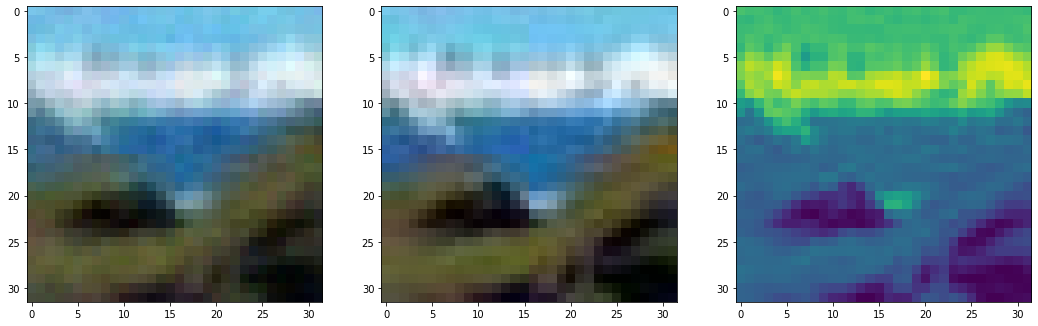

Step 2050, Total loss 0.001046


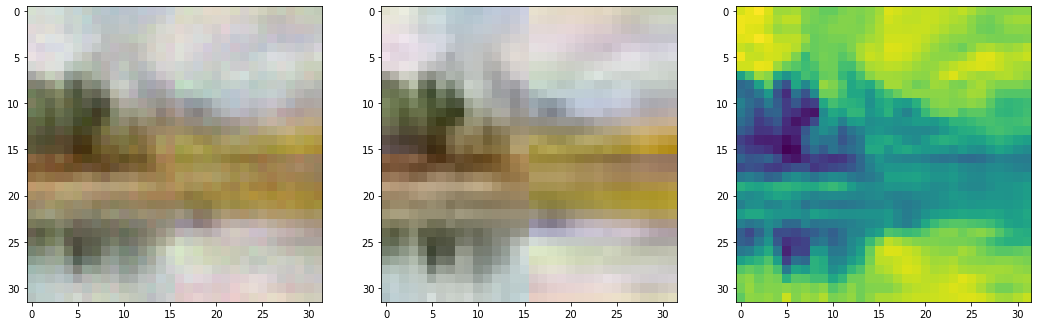

Step 2060, Total loss 0.001423


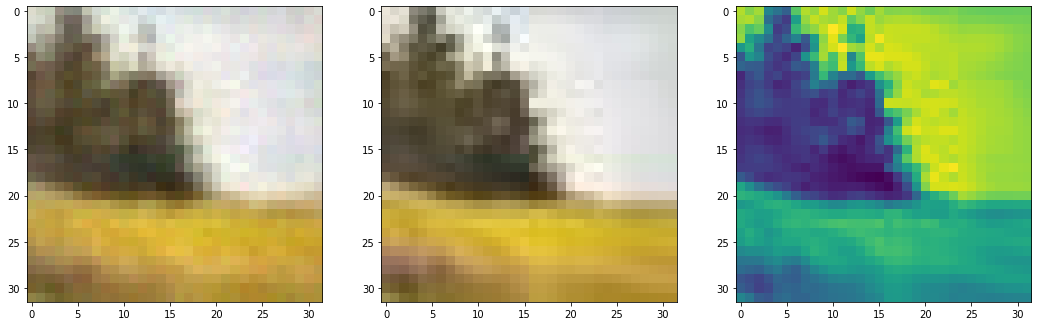

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2070, Total loss 0.001185


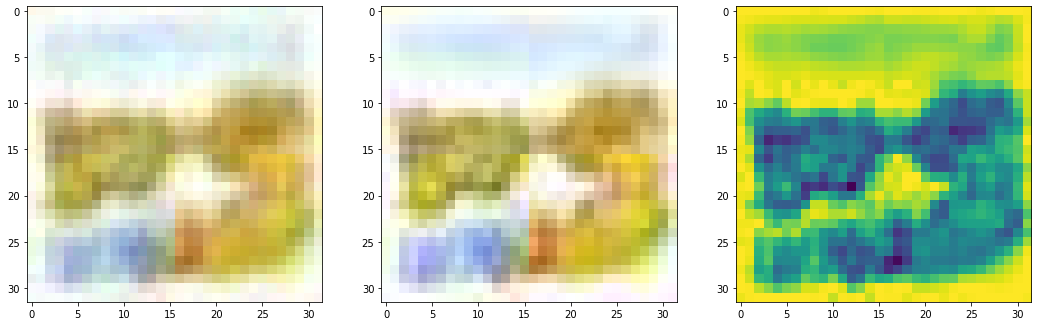

Step 2080, Total loss 0.001104


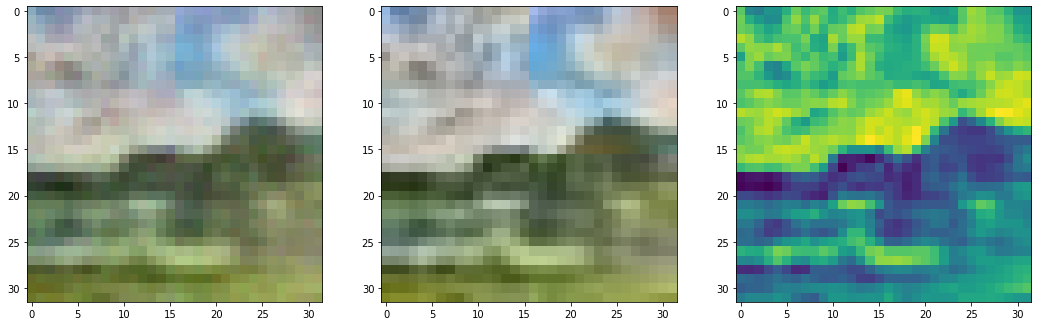

Step 2090, Total loss 0.001221


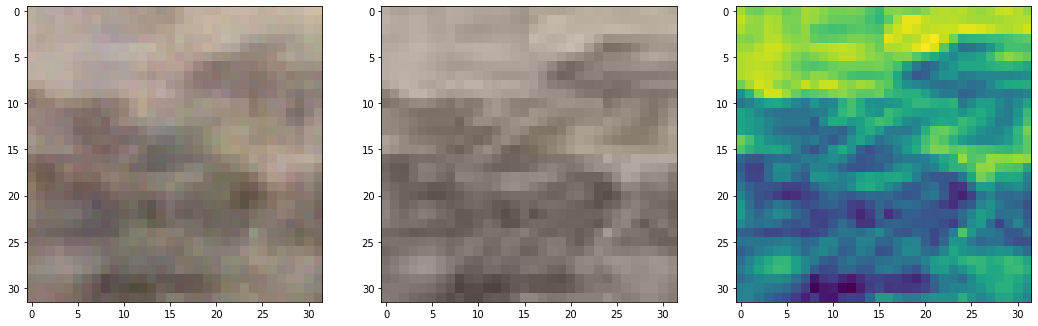

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2100, Total loss 0.001522


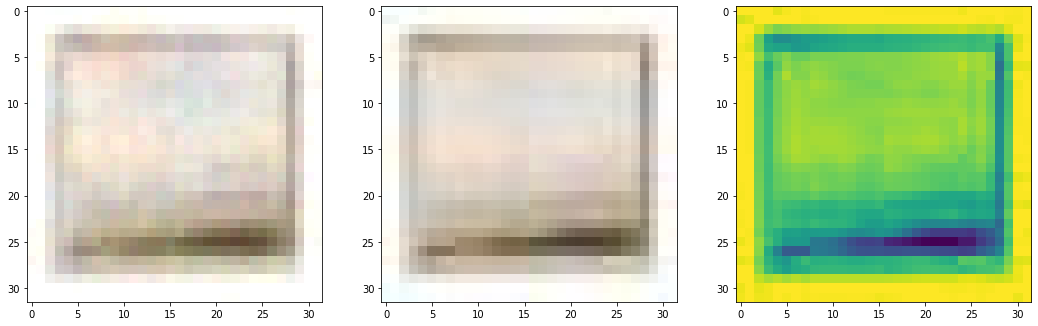

Step 2110, Total loss 0.001093


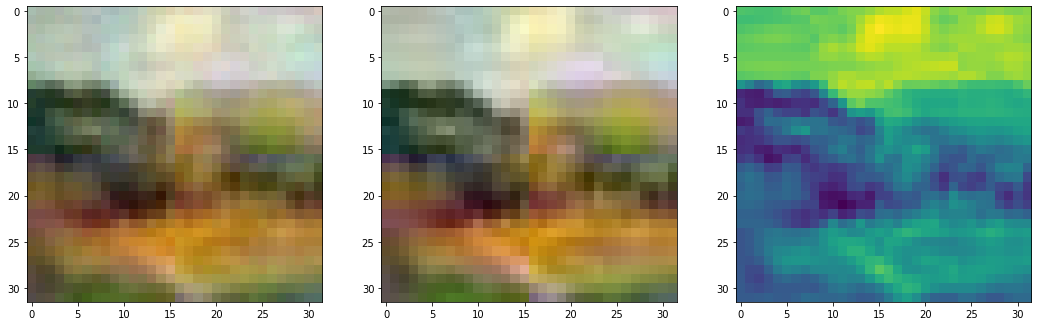

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2120, Total loss 0.001001


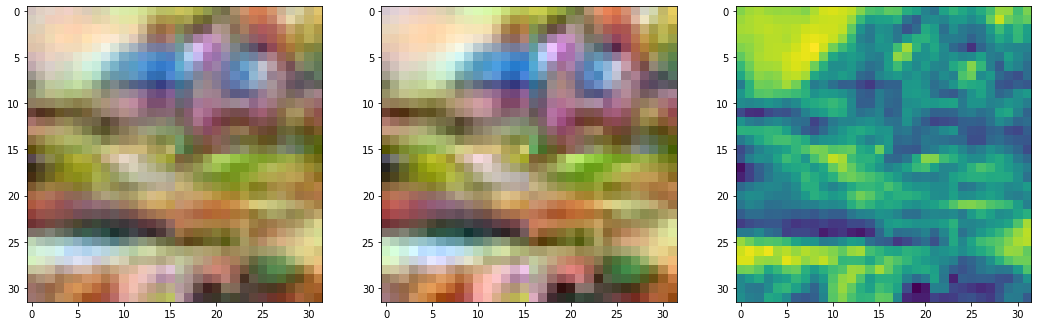

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2130, Total loss 0.001174


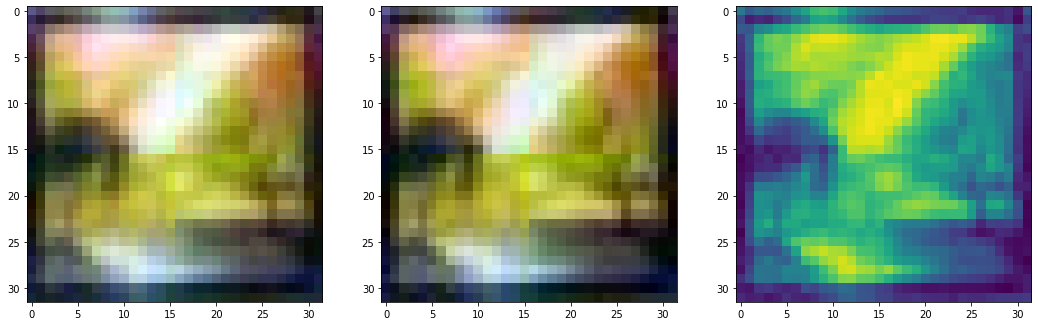

Step 2140, Total loss 0.001000


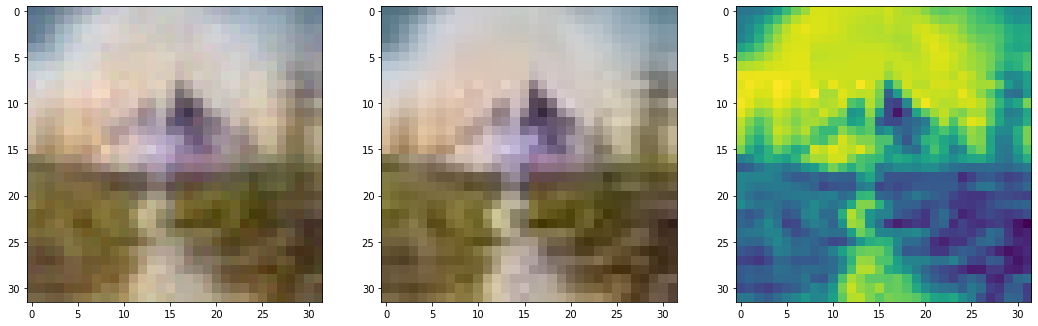

Step 2150, Total loss 0.000909


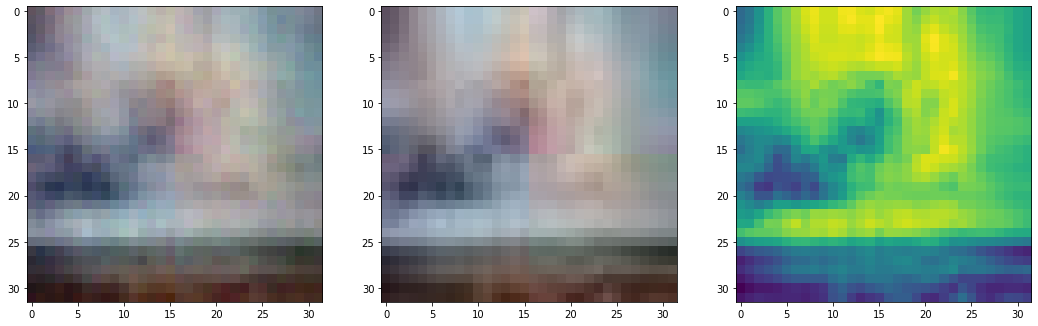

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2160, Total loss 0.000923


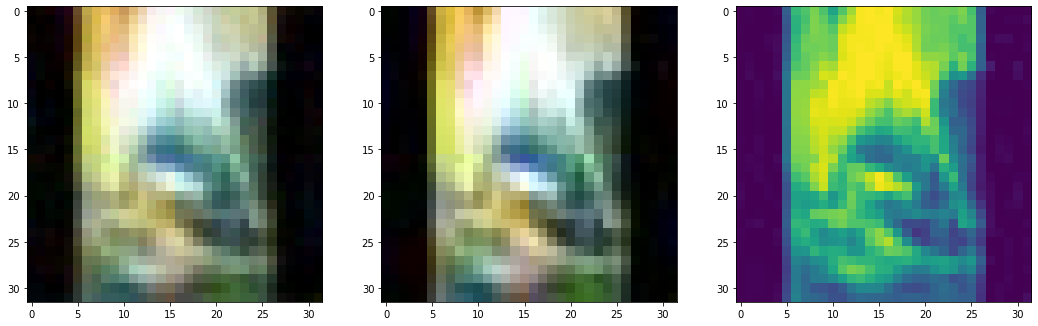

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2170, Total loss 0.000930


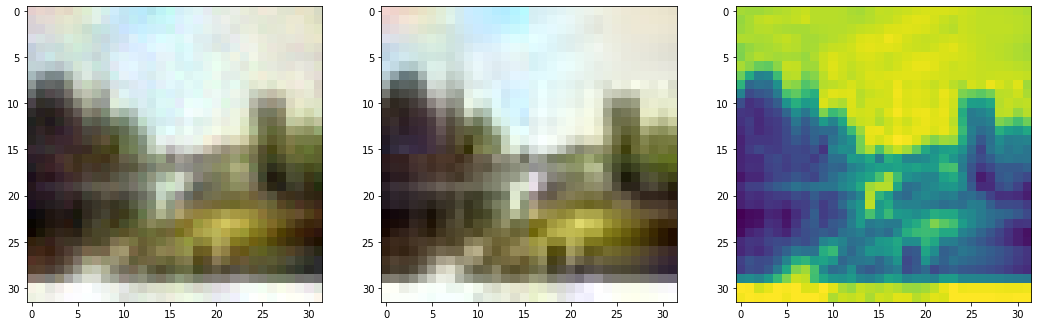

Step 2180, Total loss 0.000923


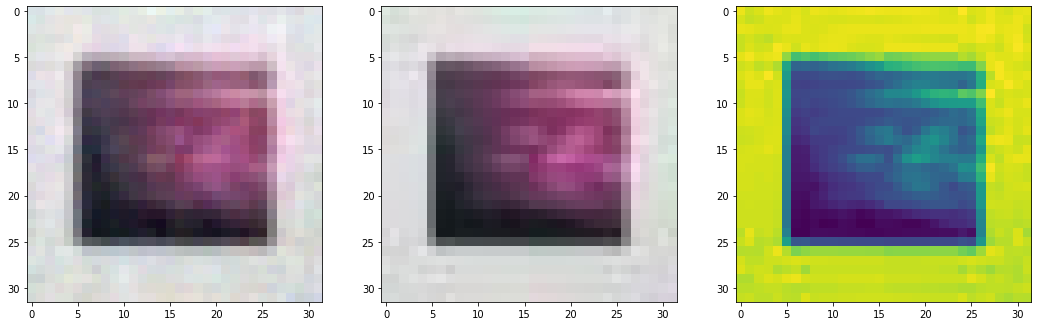

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2190, Total loss 0.000997


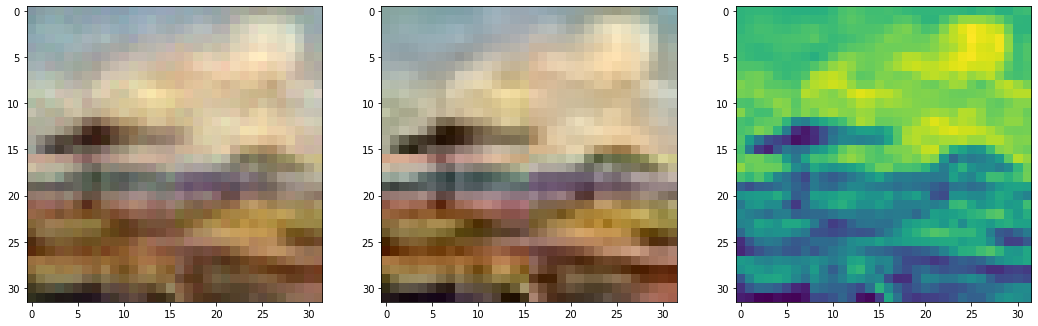

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2200, Total loss 0.000958


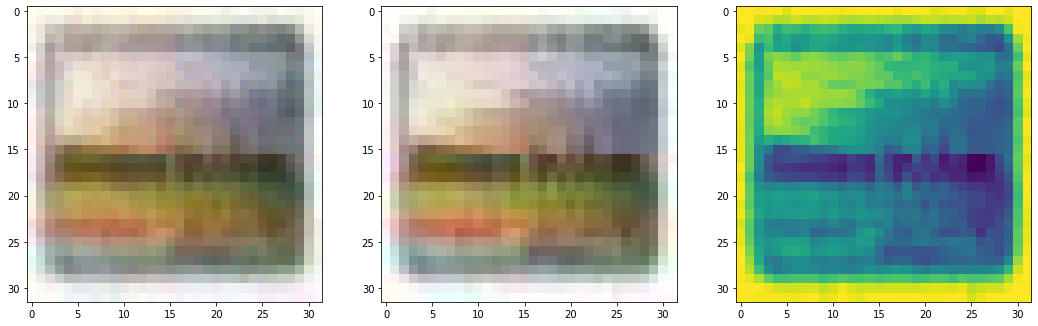

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2210, Total loss 0.000916


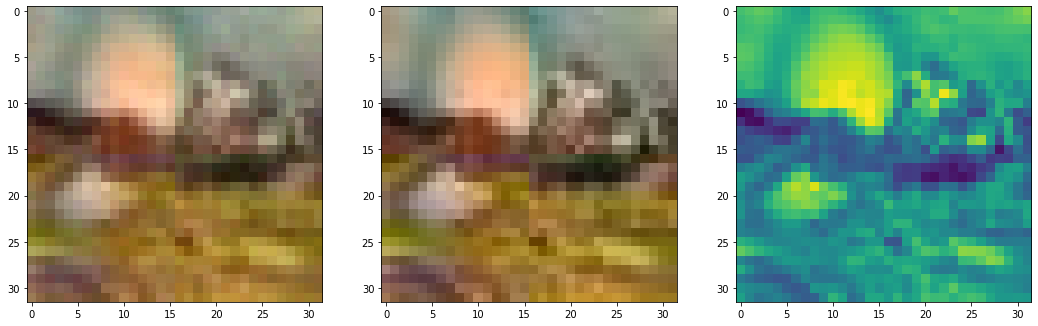

Step 2220, Total loss 0.000829


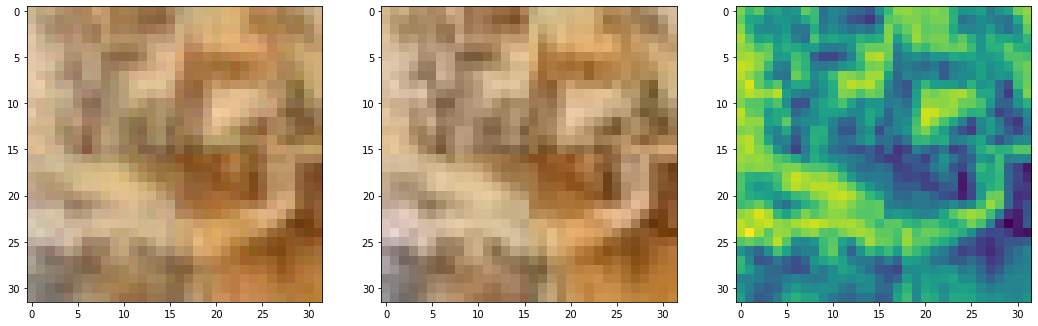

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2230, Total loss 0.000797


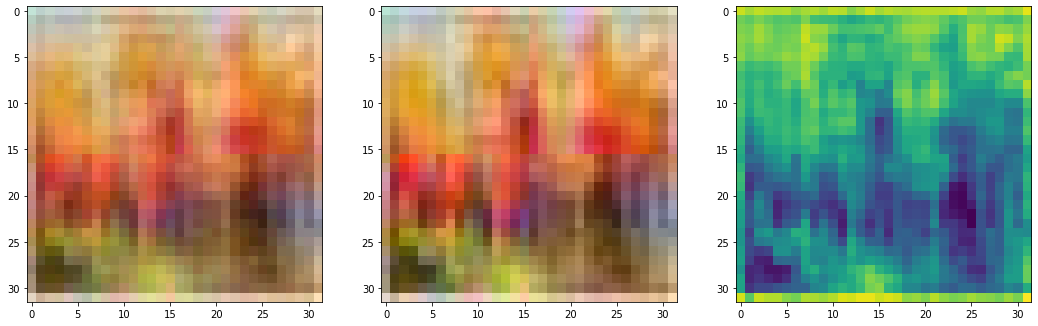

Step 2240, Total loss 0.000782


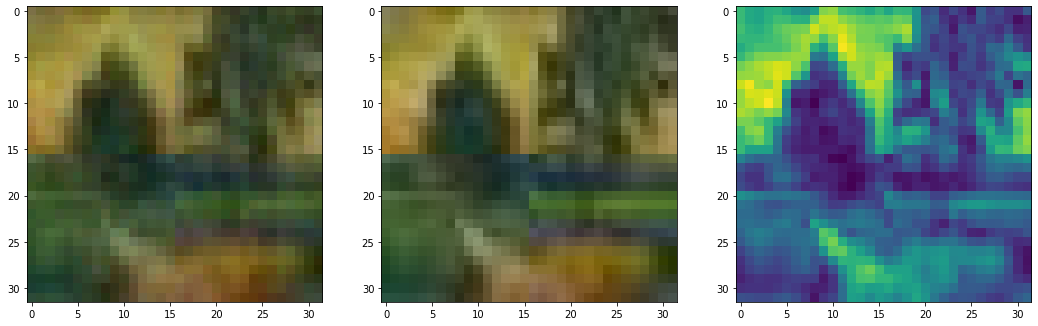

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2250, Total loss 0.000835


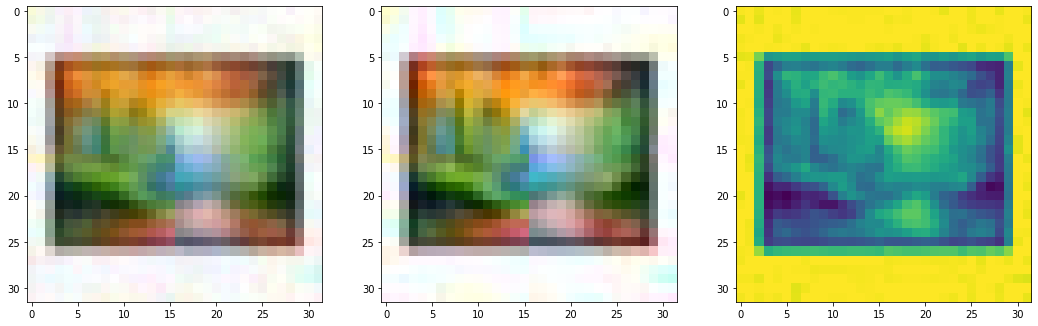

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2260, Total loss 0.000917


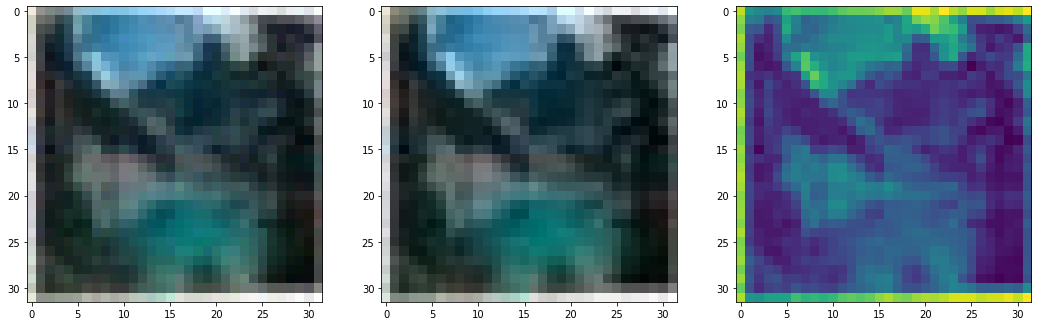

Step 2270, Total loss 0.000879


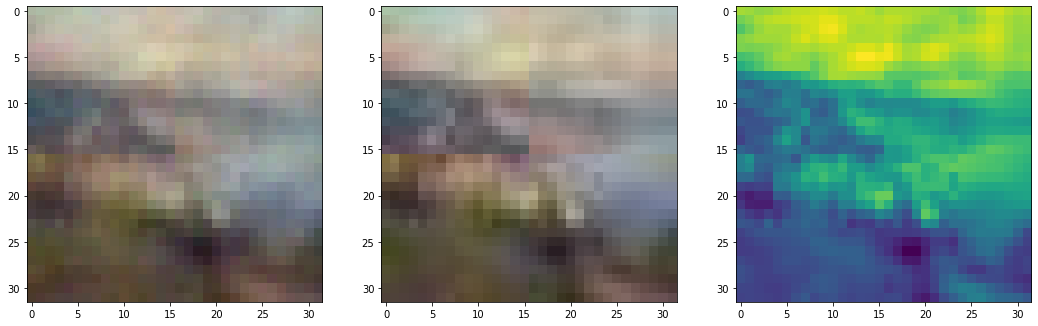

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2280, Total loss 0.000863


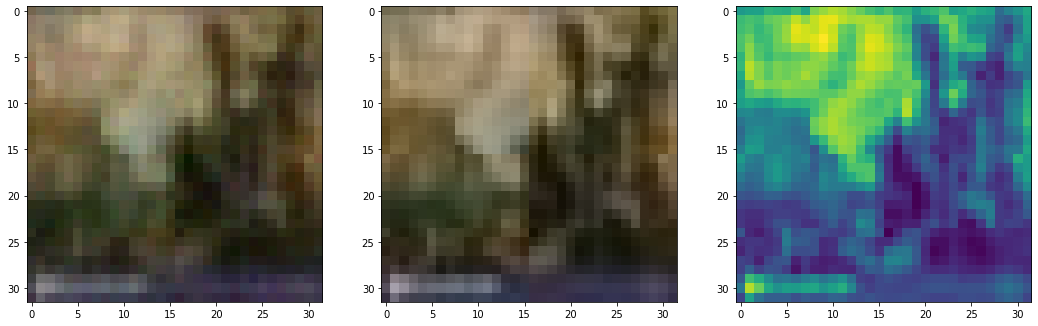

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2290, Total loss 0.000830


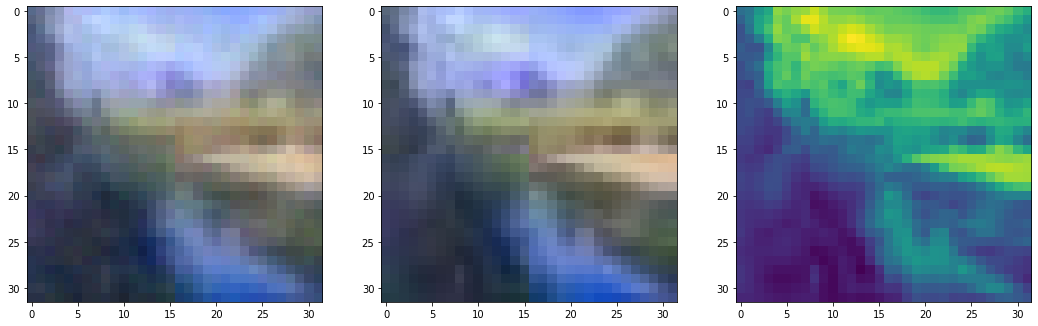

Step 2300, Total loss 0.000826


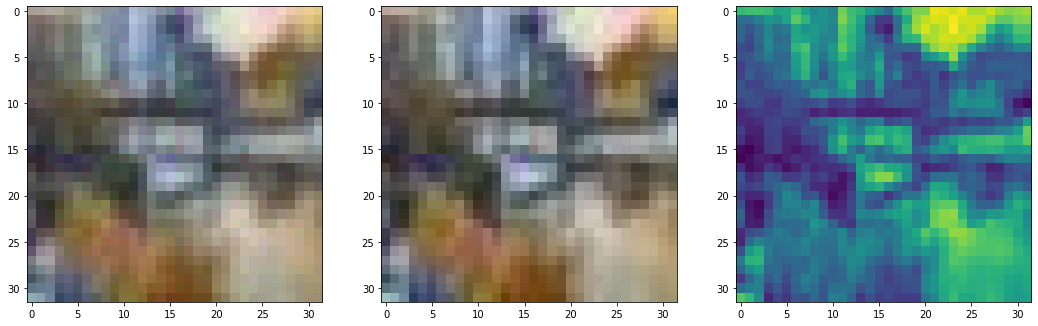

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2310, Total loss 0.000854


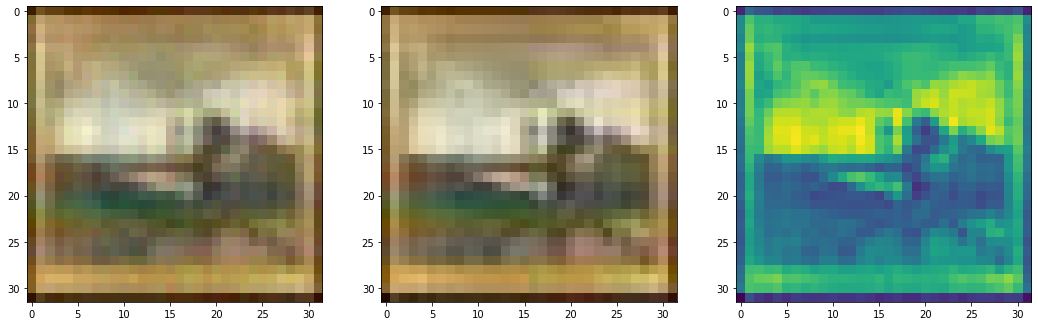

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2320, Total loss 0.000832


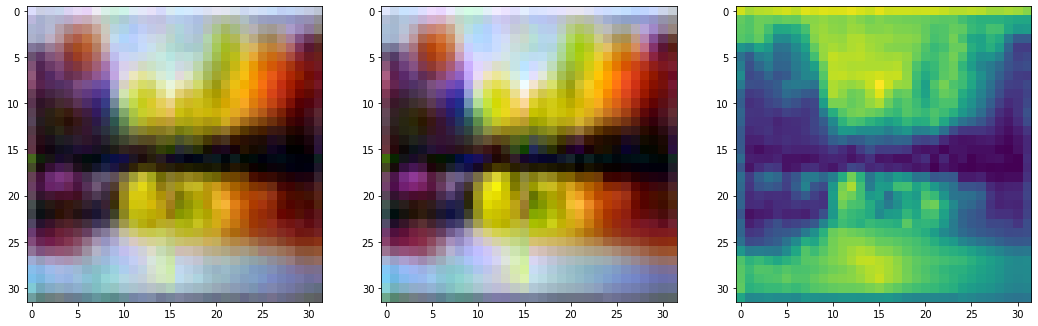

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2330, Total loss 0.000807


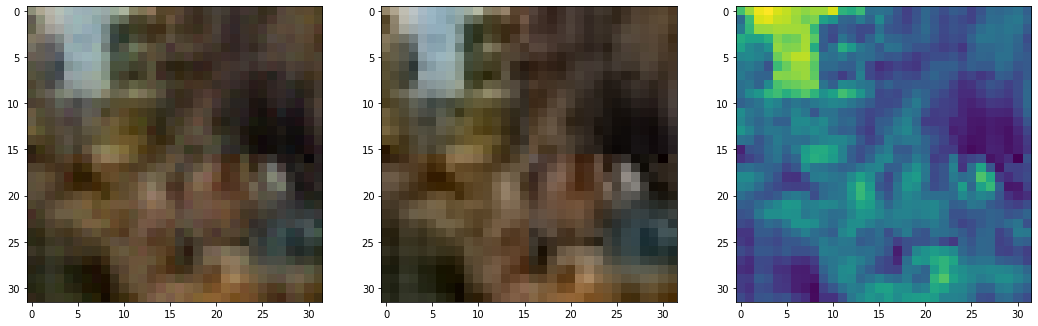

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2340, Total loss 0.000963


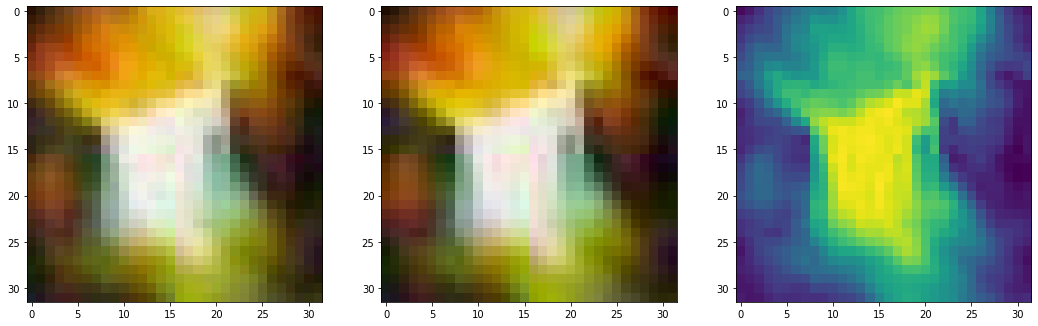

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2350, Total loss 0.000949


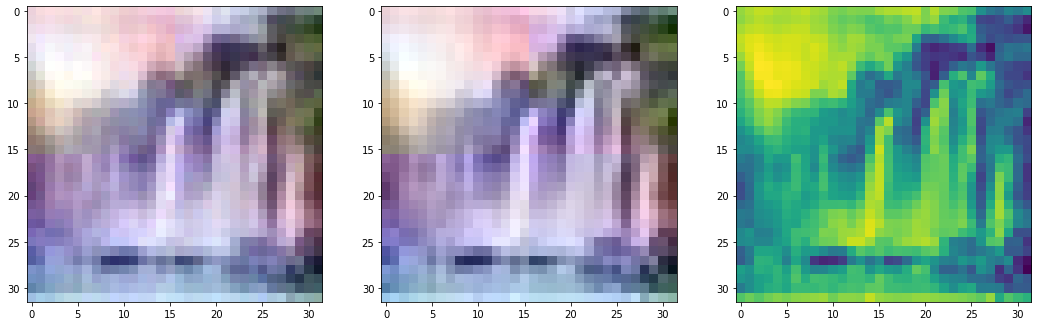

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2360, Total loss 0.000839


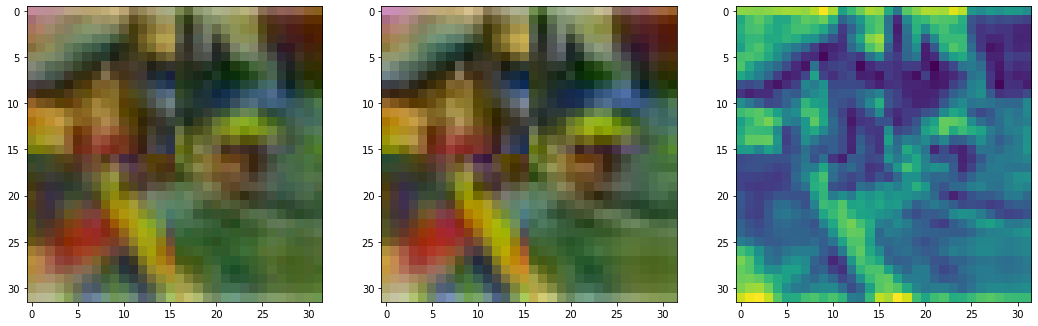

Step 2370, Total loss 0.000737


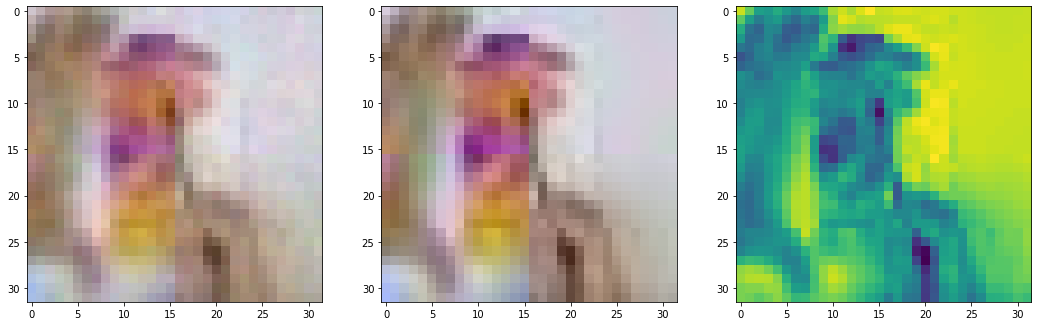

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2380, Total loss 0.000946


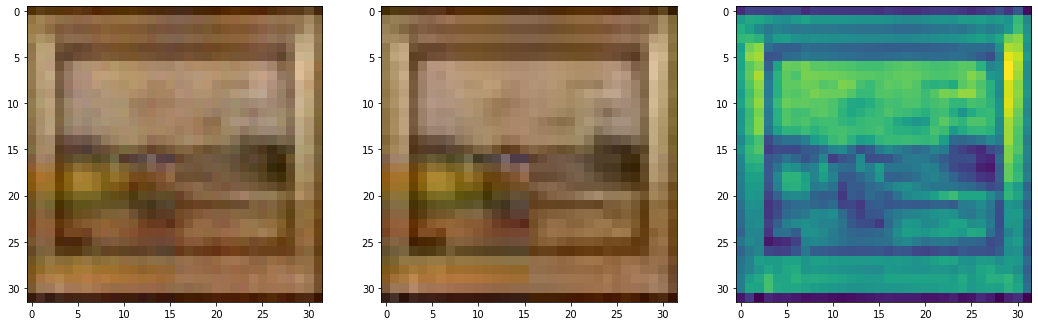

Step 2390, Total loss 0.000823


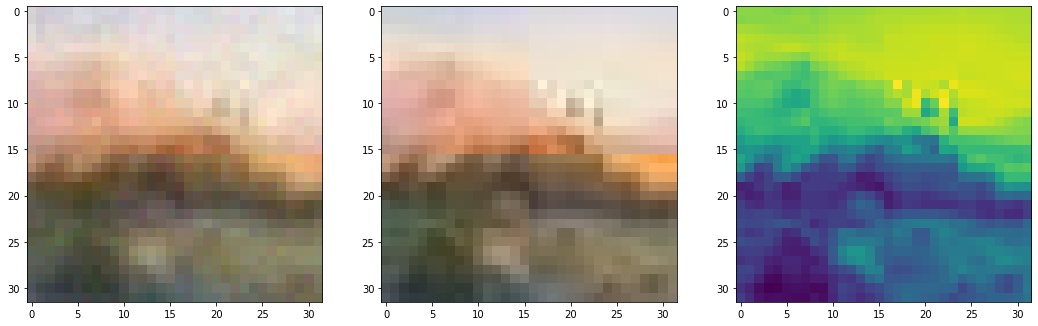

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2400, Total loss 0.000660


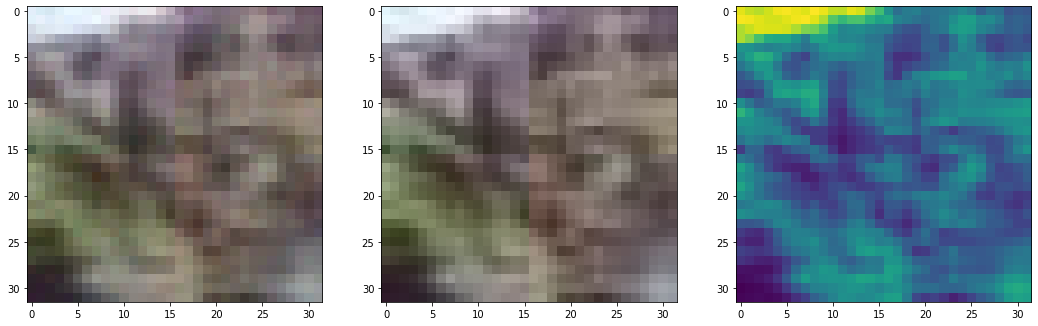

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2410, Total loss 0.000729


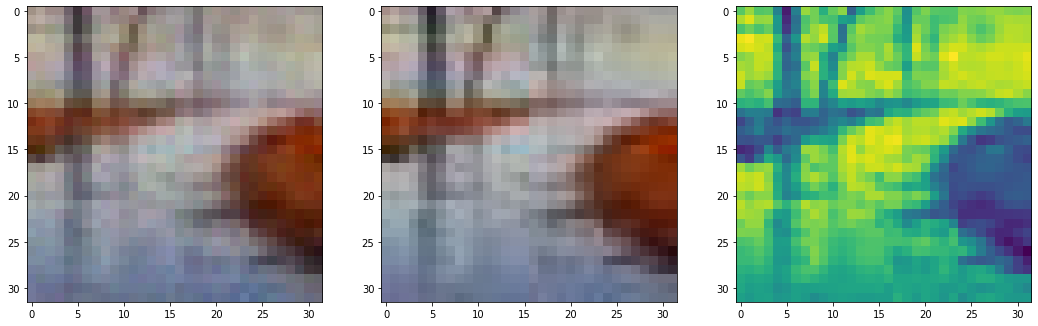

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2420, Total loss 0.000788


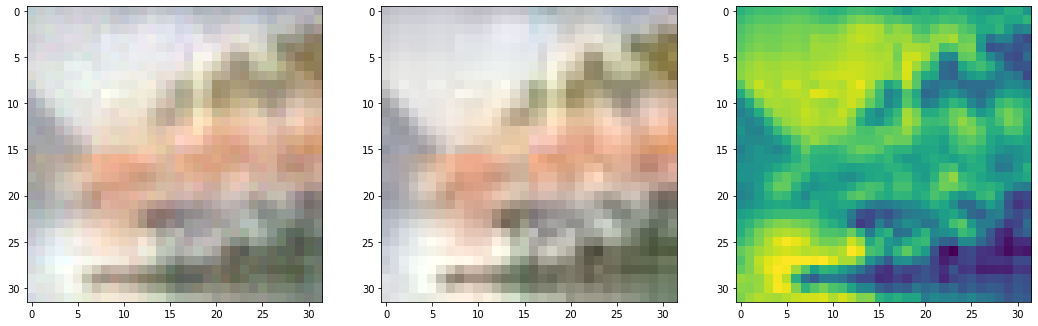

Step 2430, Total loss 0.000777


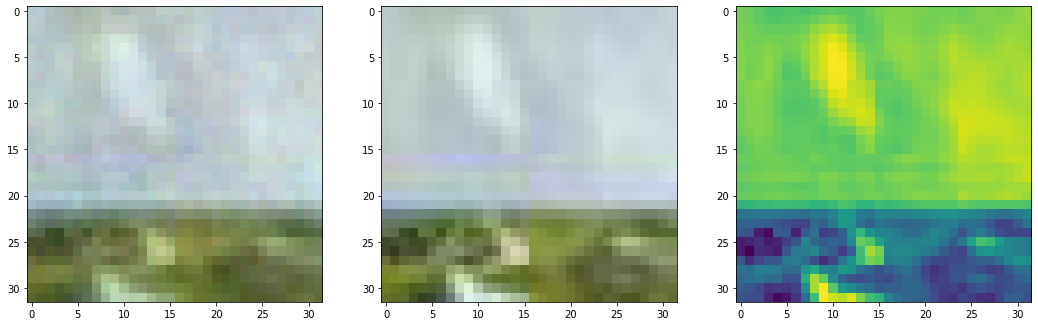

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2440, Total loss 0.000652


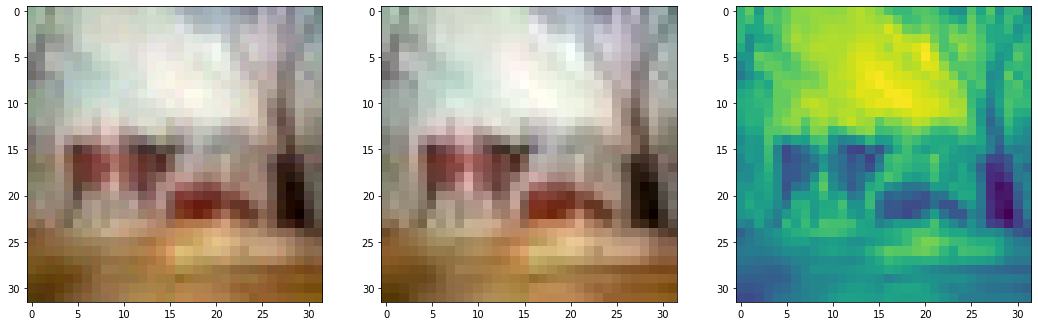

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2450, Total loss 0.000636


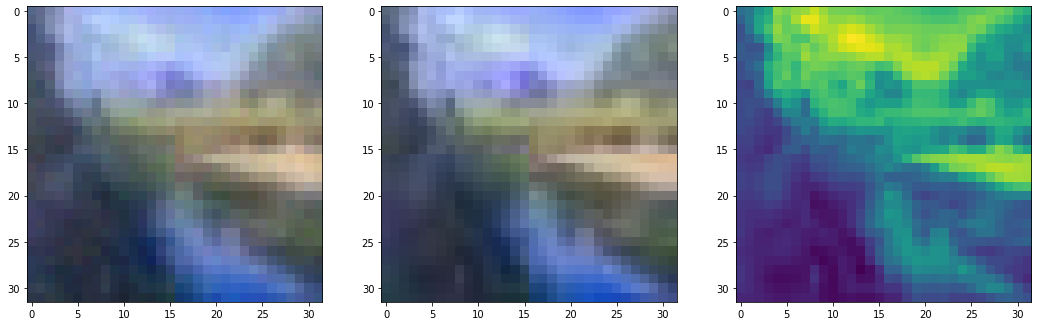

Step 2460, Total loss 0.000829


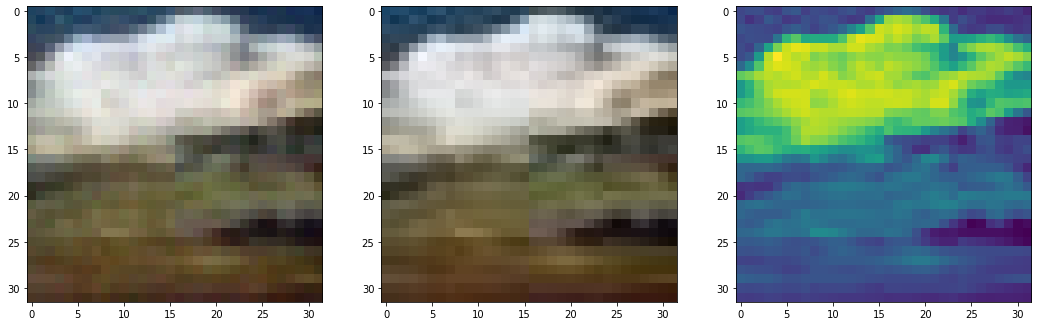

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2470, Total loss 0.000894


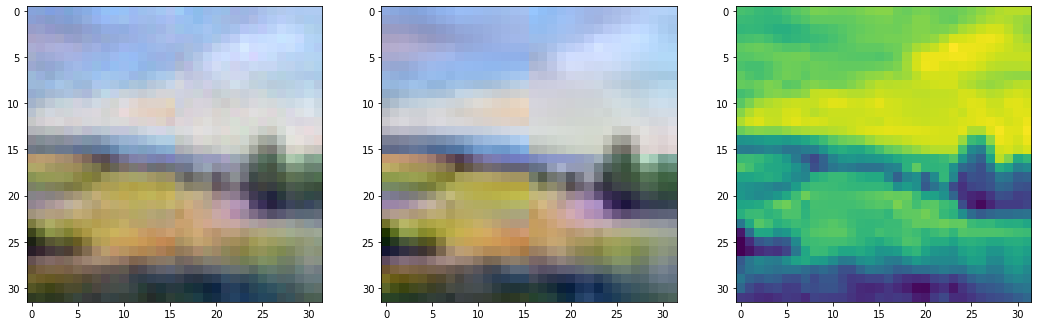

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2480, Total loss 0.000718


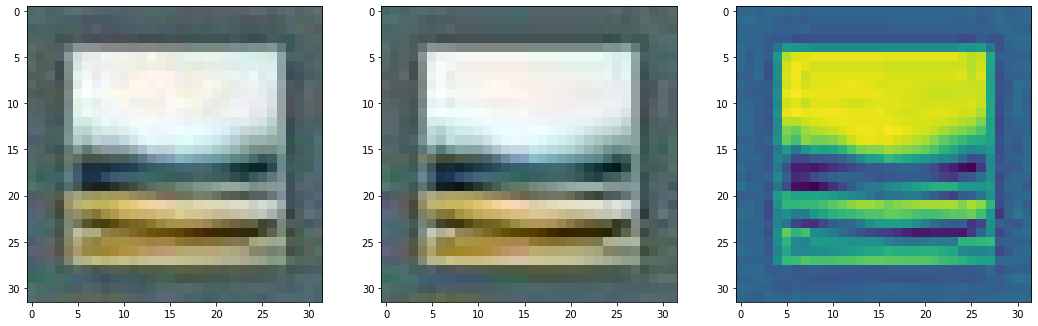

Step 2490, Total loss 0.000706


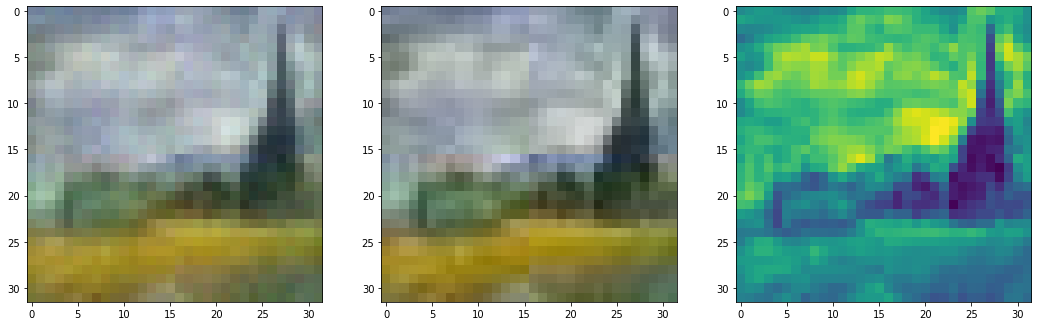

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500, Total loss 0.000754


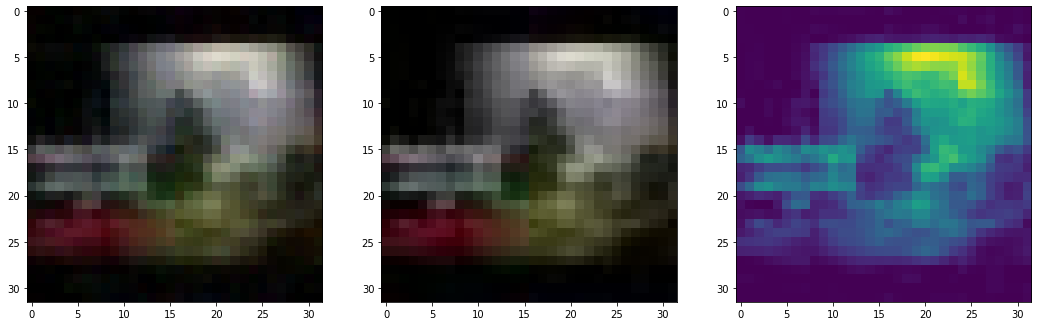

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2510, Total loss 0.000687


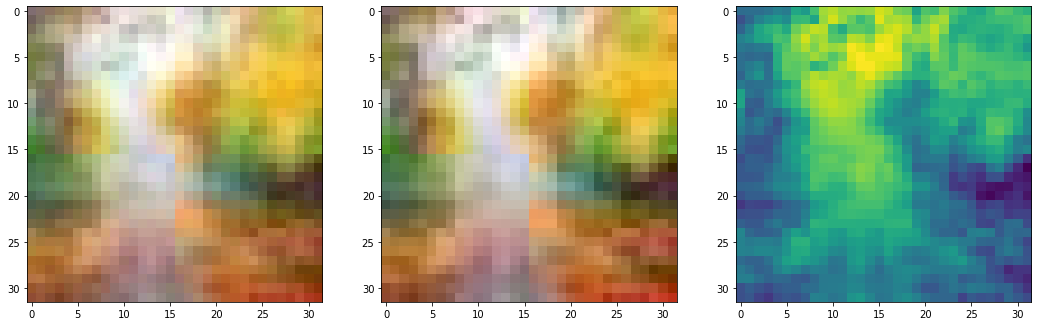

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2520, Total loss 0.000701


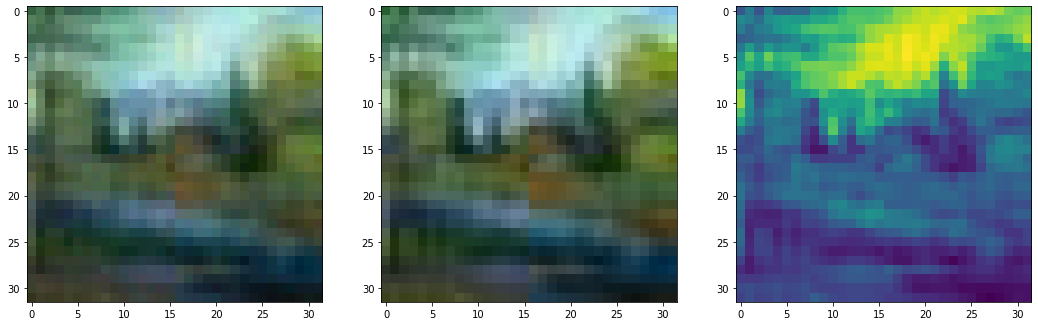

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2530, Total loss 0.000758


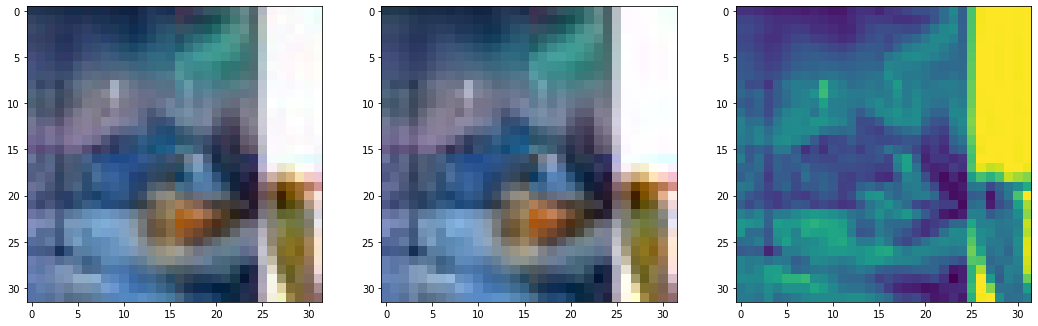

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2540, Total loss 0.000768


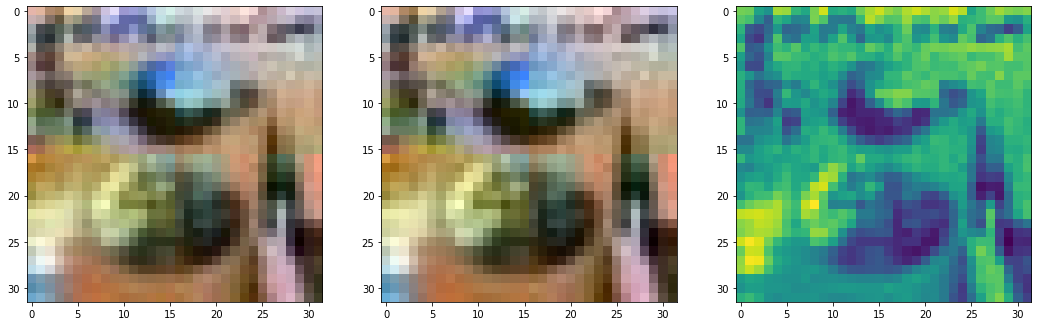

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2550, Total loss 0.000685


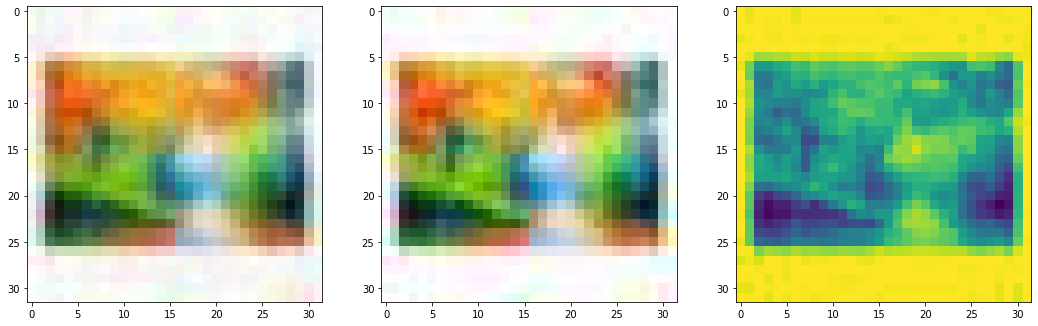

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2560, Total loss 0.000795


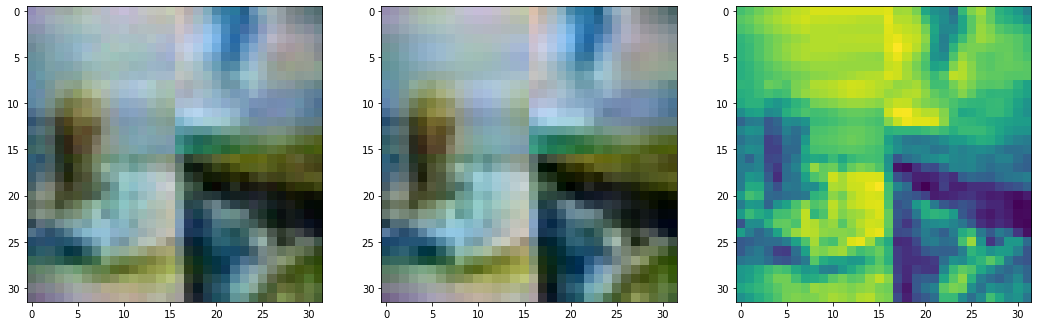

Step 2570, Total loss 0.000790


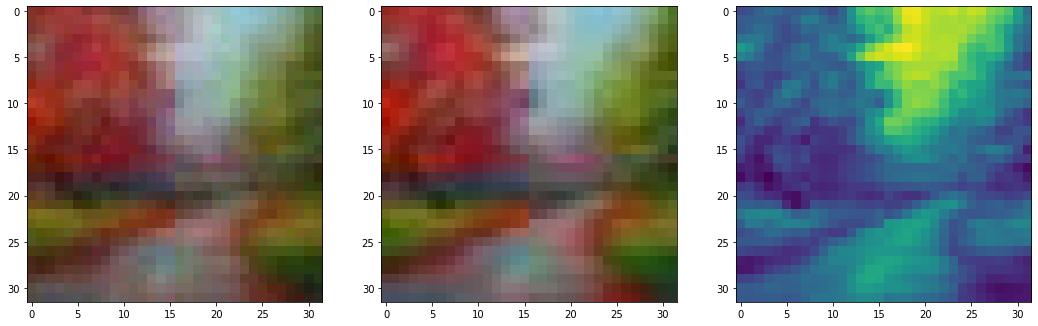

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2580, Total loss 0.000573


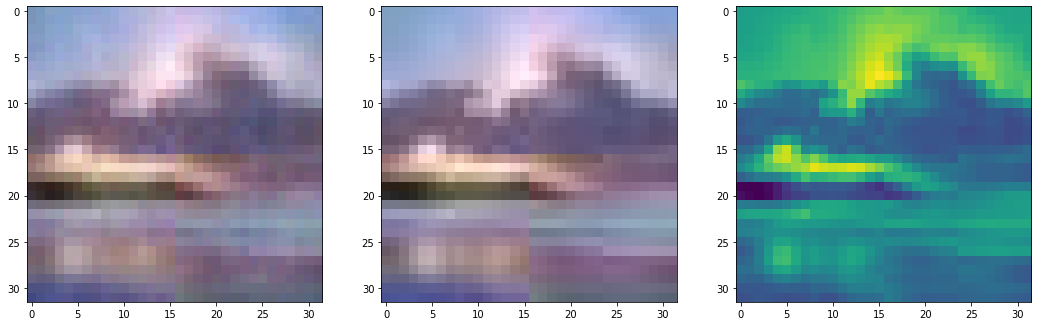

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2590, Total loss 0.000632


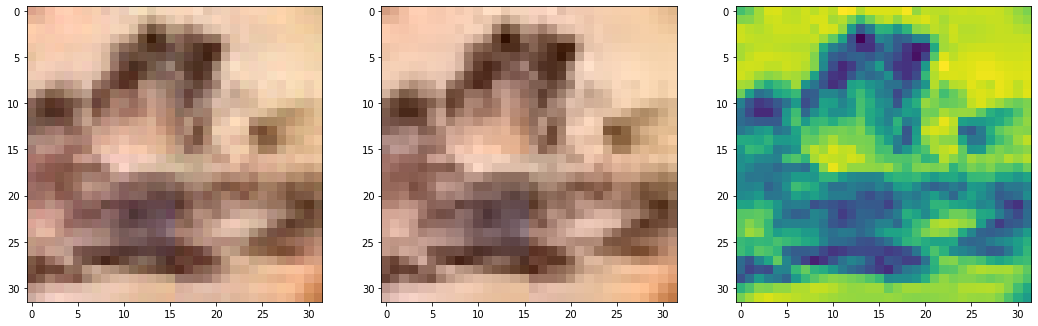

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2600, Total loss 0.000671


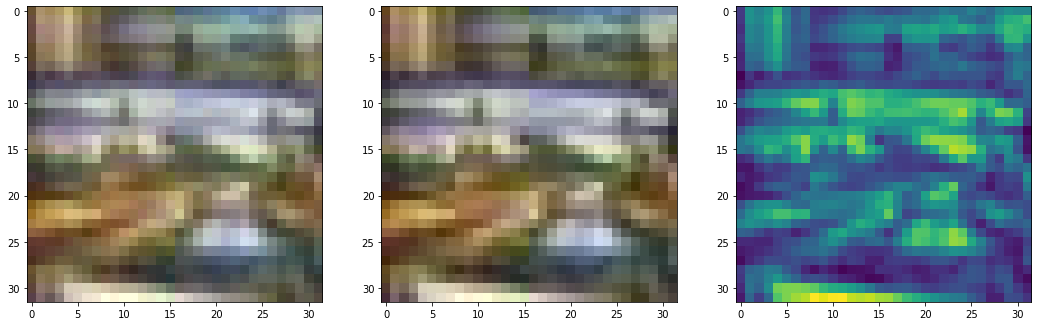

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2610, Total loss 0.000672


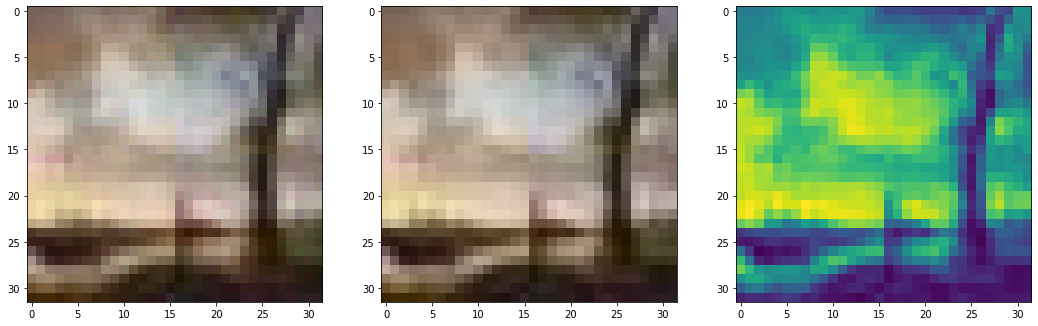

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2620, Total loss 0.000587


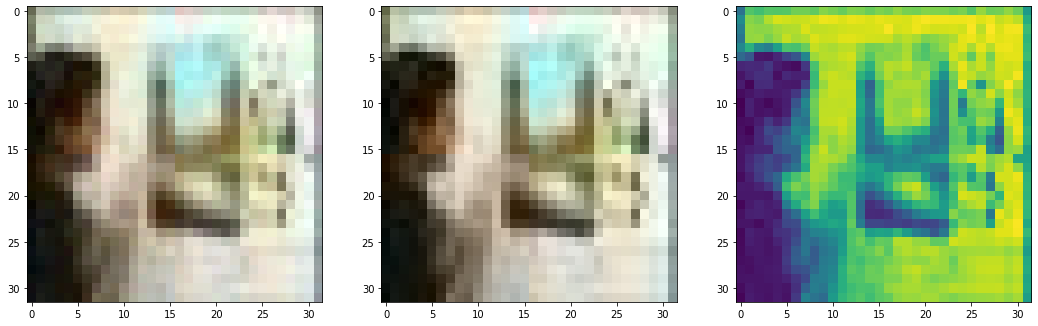

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2630, Total loss 0.000585


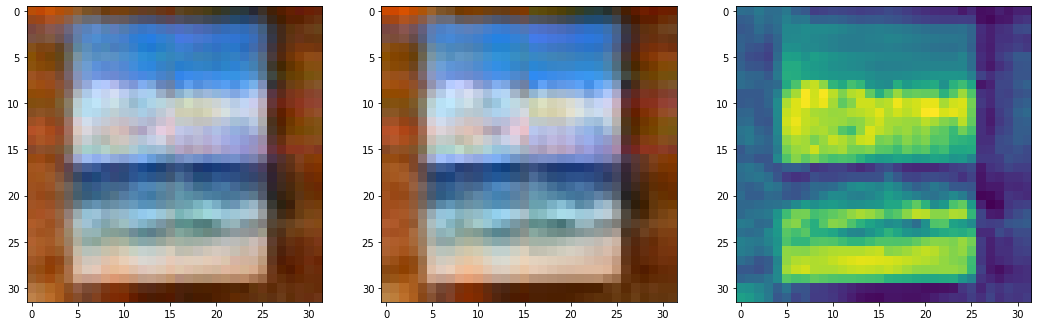

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2640, Total loss 0.000624


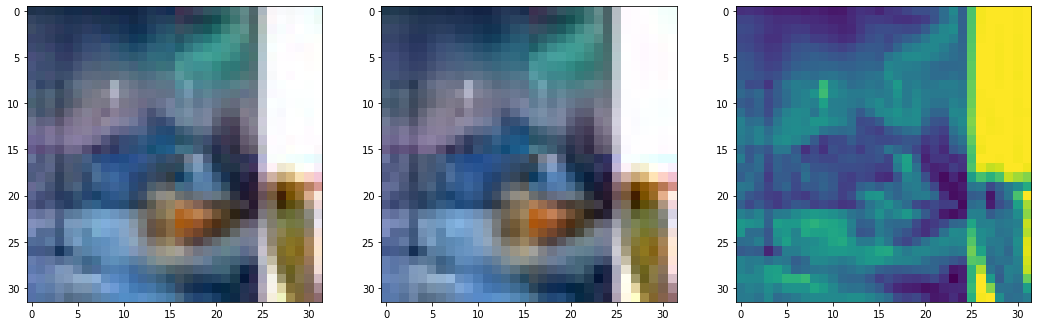

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2650, Total loss 0.000602


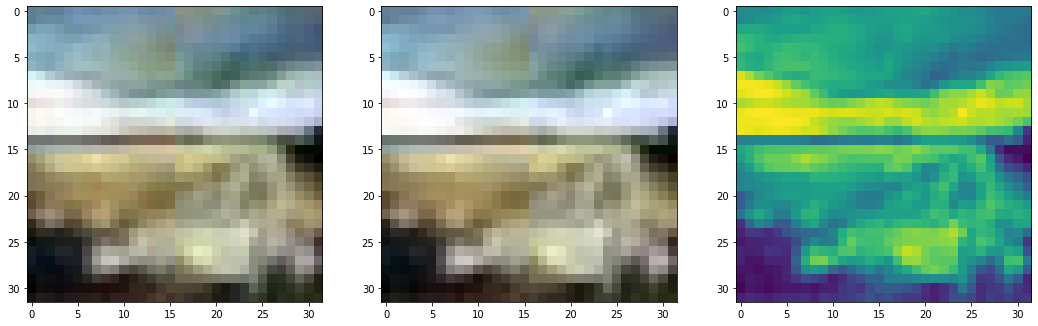

Step 2660, Total loss 0.000534


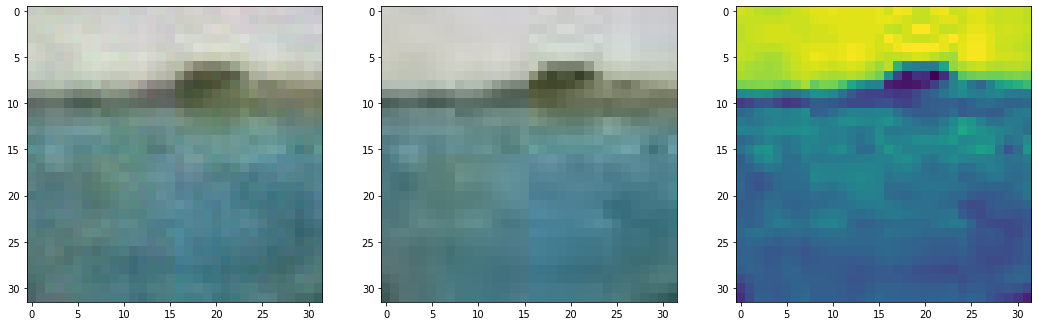

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2670, Total loss 0.000517


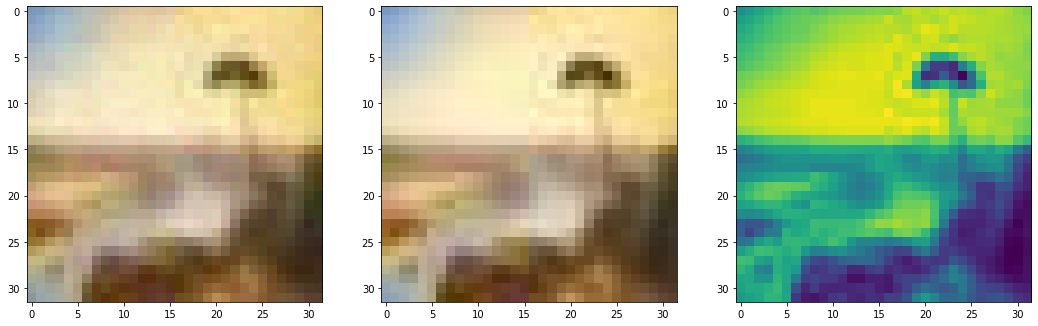

Step 2680, Total loss 0.000592


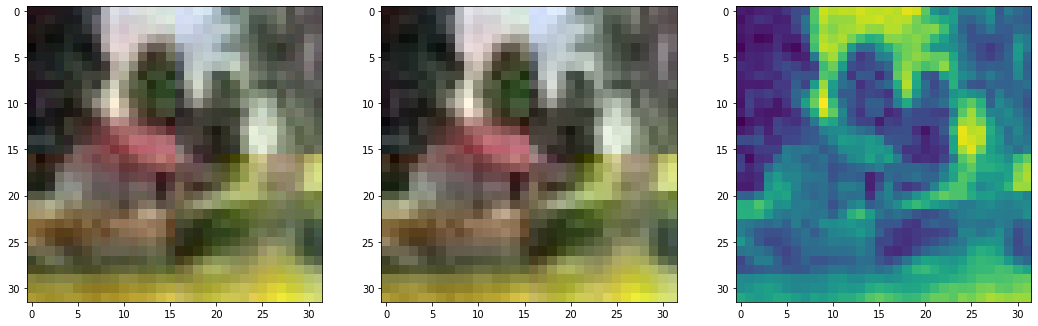

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2690, Total loss 0.000660


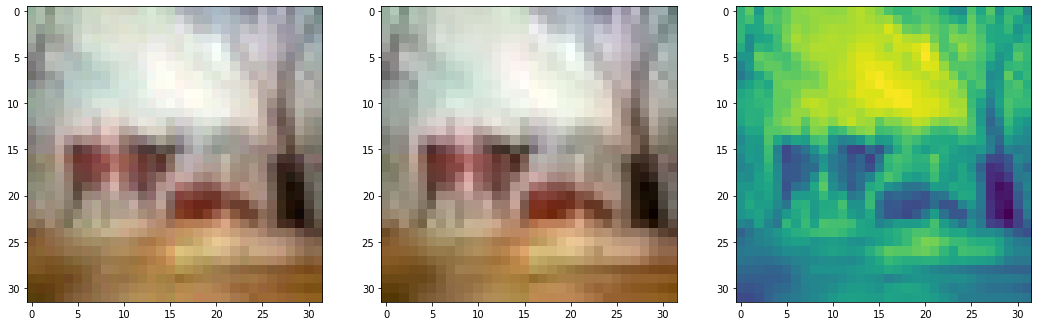

Step 2700, Total loss 0.000746


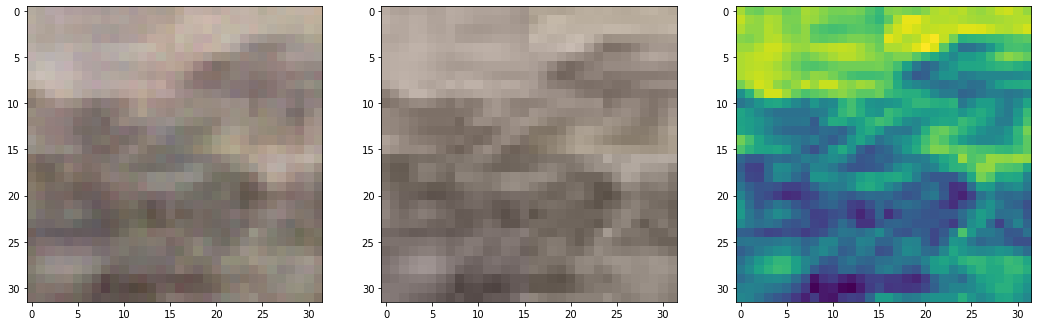

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2710, Total loss 0.000527


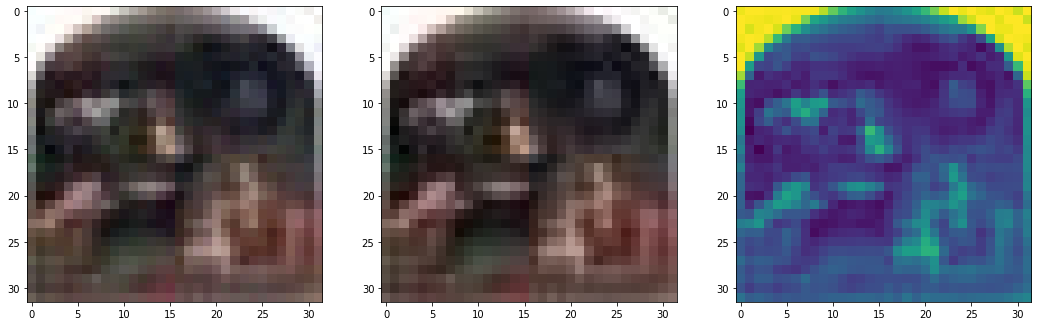

Step 2720, Total loss 0.000598


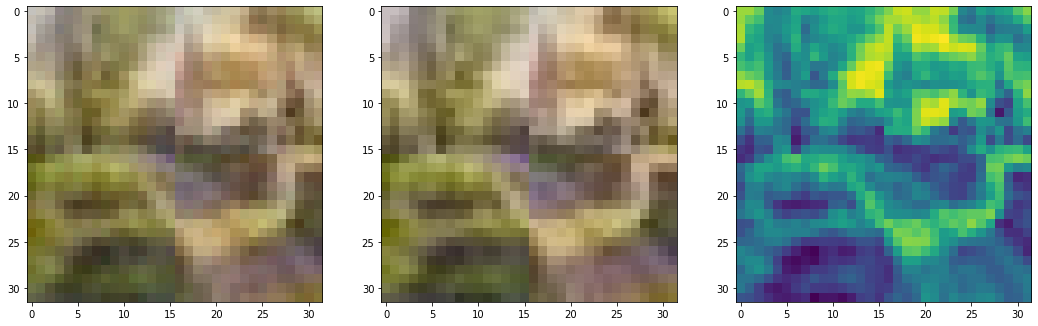

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2730, Total loss 0.000611


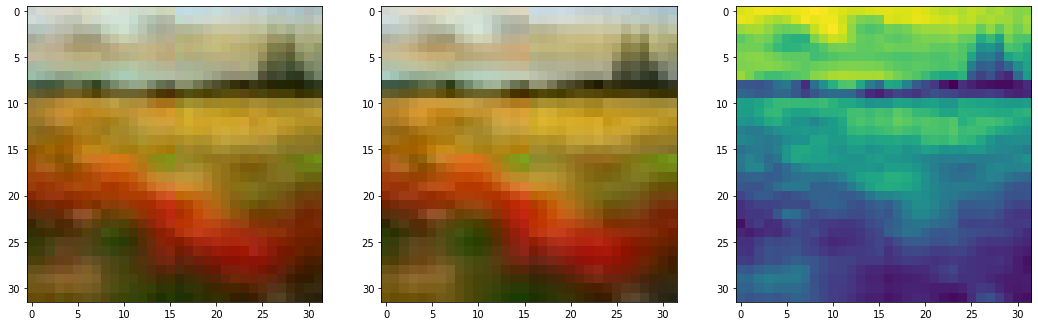

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2740, Total loss 0.000603


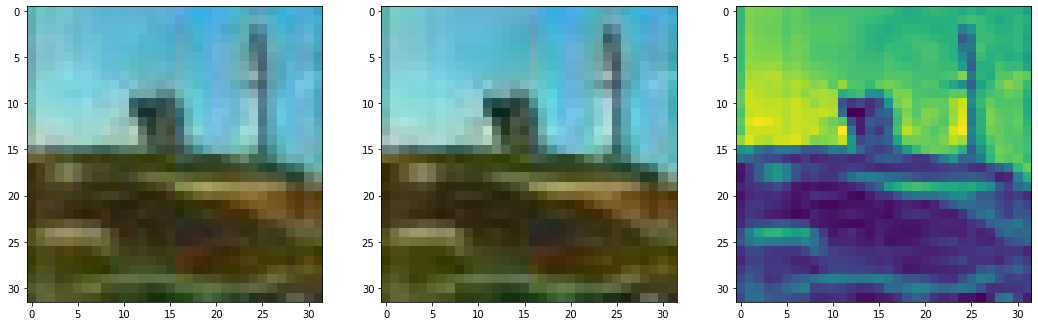

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2750, Total loss 0.000546


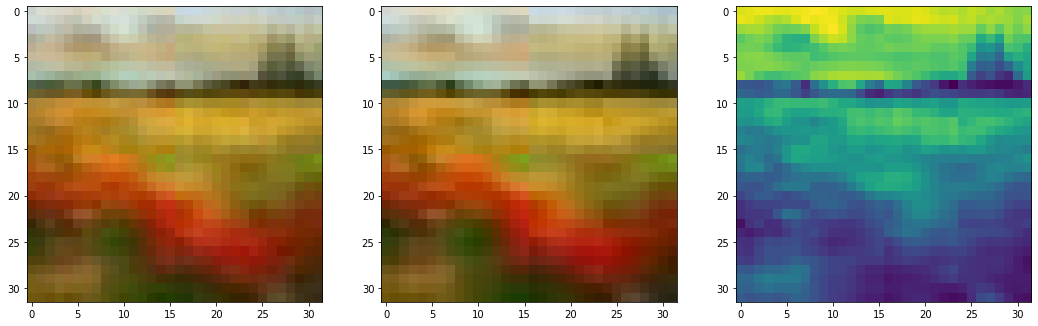

Step 2760, Total loss 0.000535


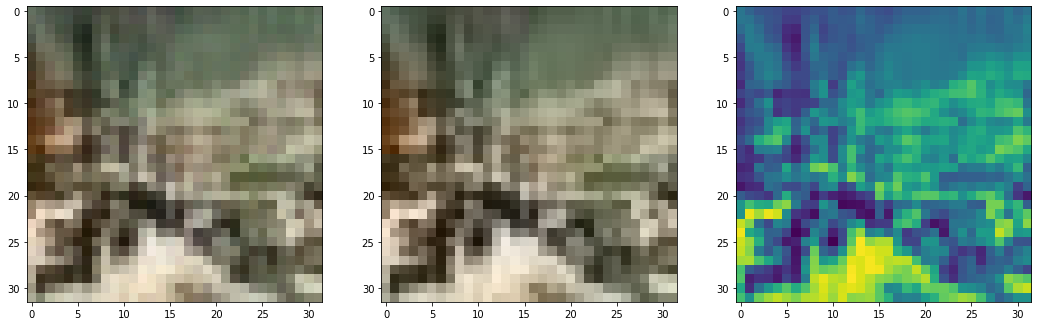

Step 2770, Total loss 0.000540


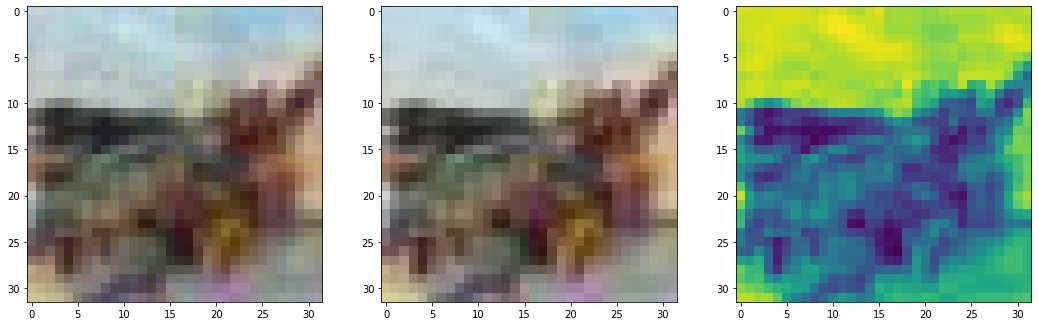

Step 2780, Total loss 0.000499


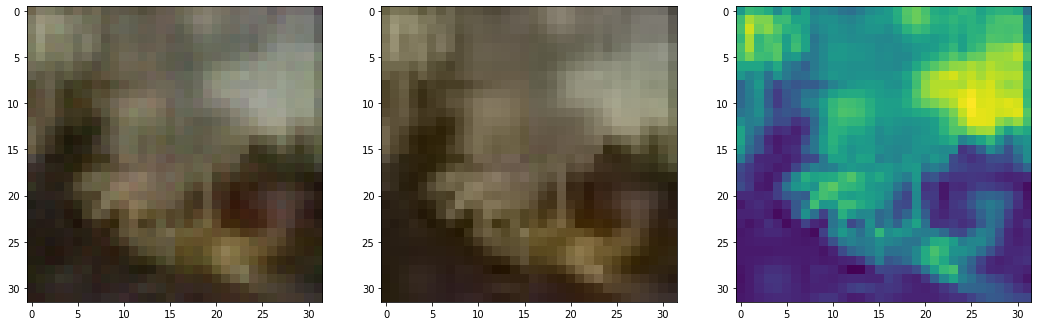

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2790, Total loss 0.000635


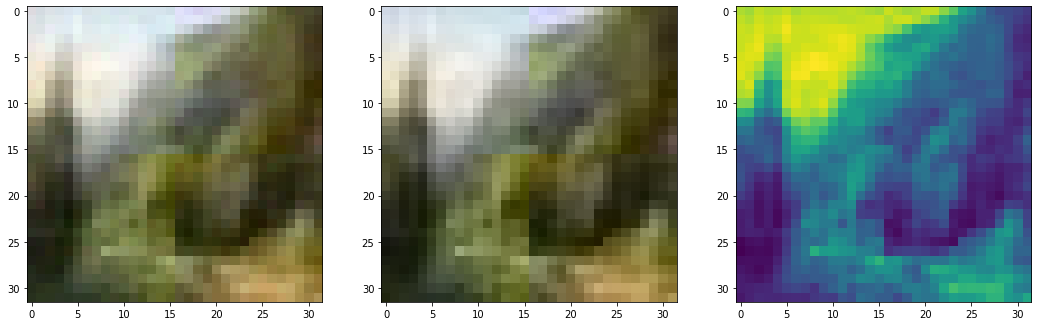

Step 2800, Total loss 0.000494


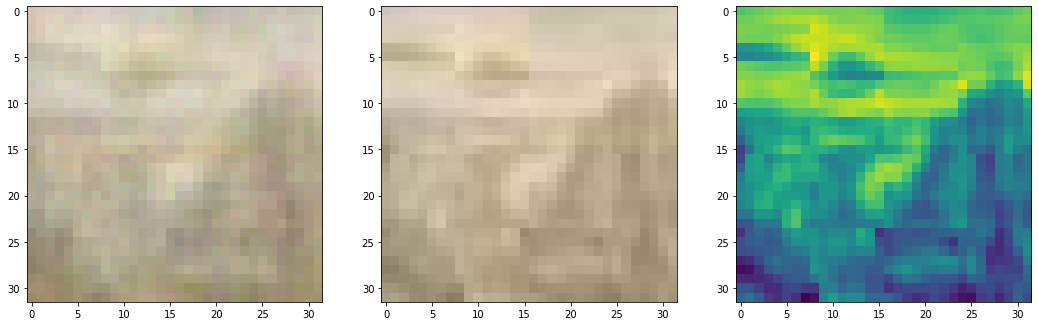

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2810, Total loss 0.000532


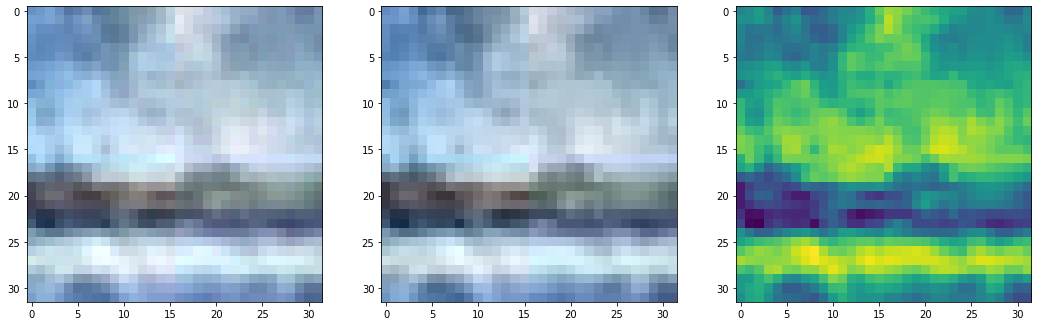

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2820, Total loss 0.000496


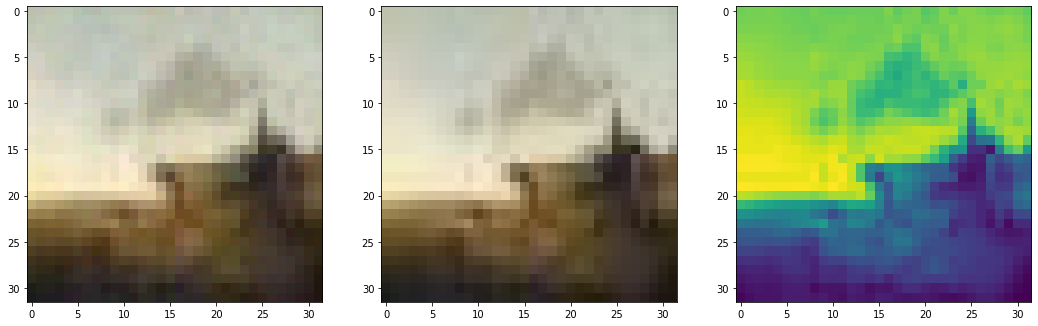

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2830, Total loss 0.000454


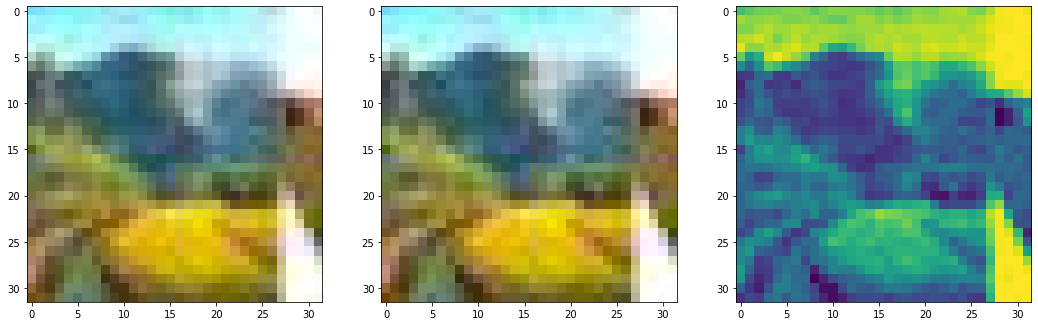

Step 2840, Total loss 0.000543


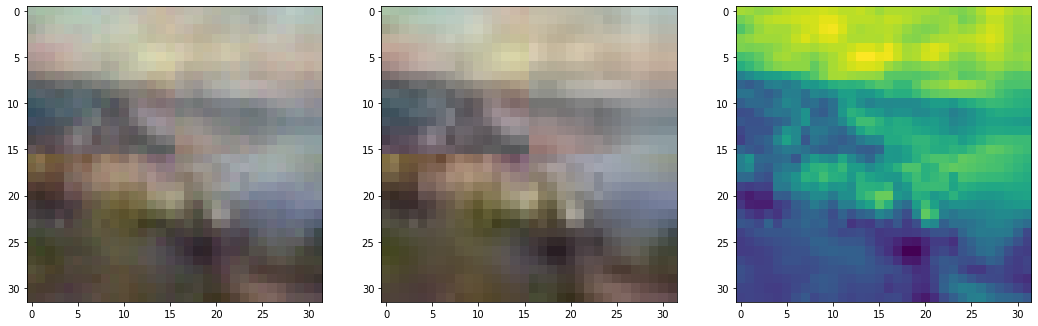

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2850, Total loss 0.000396


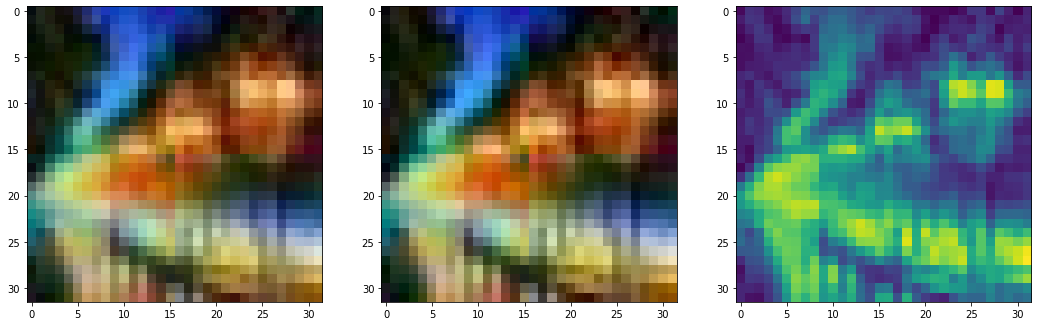

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2860, Total loss 0.000624


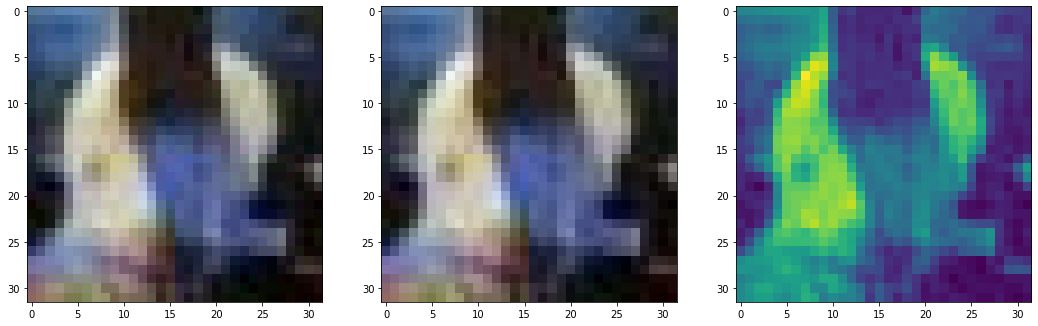

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2870, Total loss 0.000474


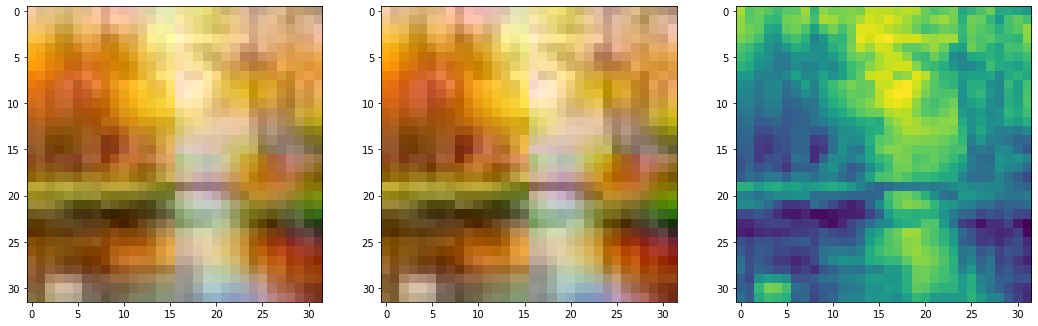

Step 2880, Total loss 0.000537


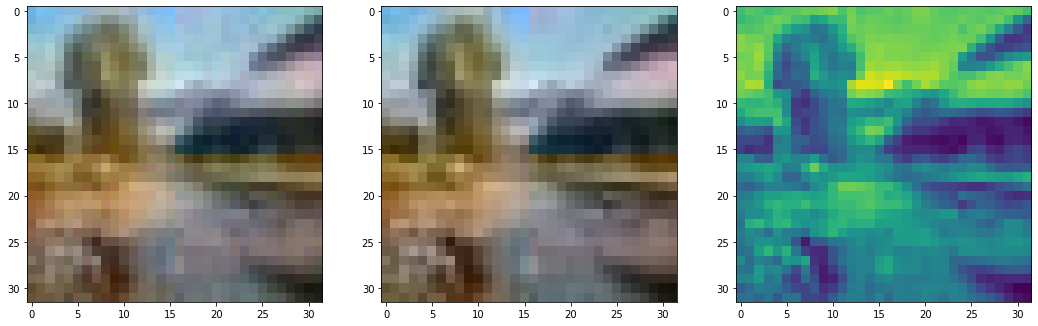

Step 2890, Total loss 0.000581


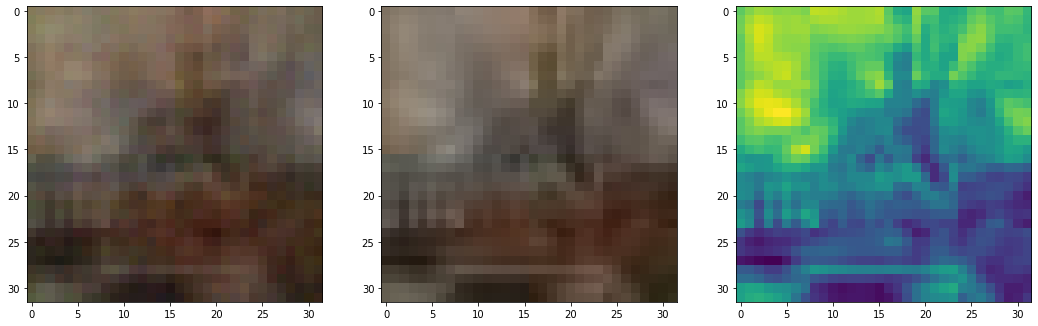

Step 2900, Total loss 0.000702


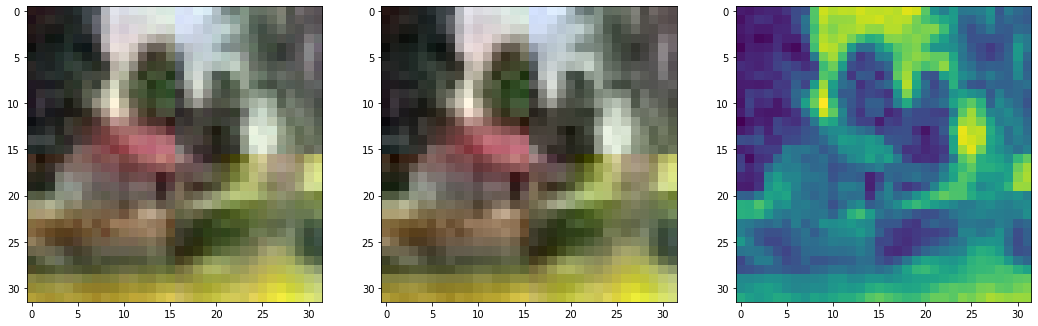

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2910, Total loss 0.000627


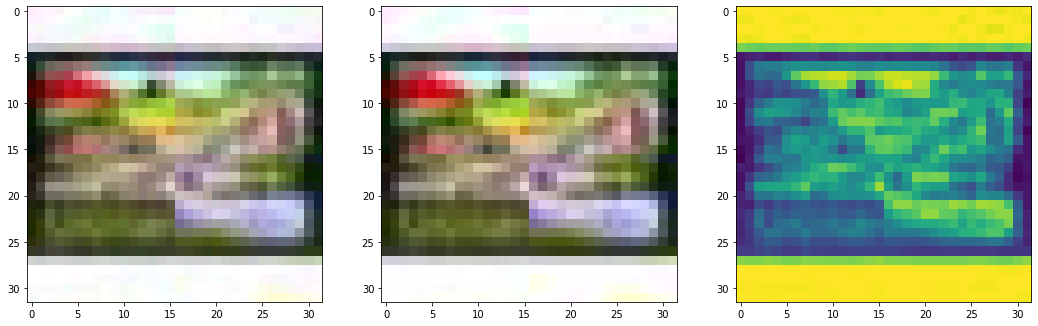

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2920, Total loss 0.000600


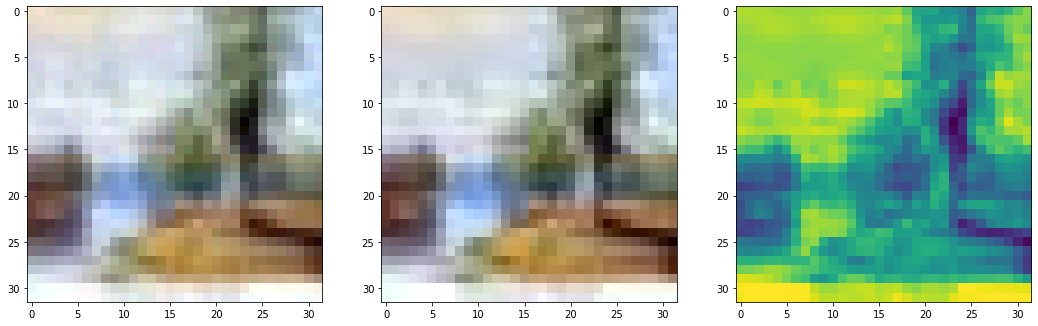

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2930, Total loss 0.000574


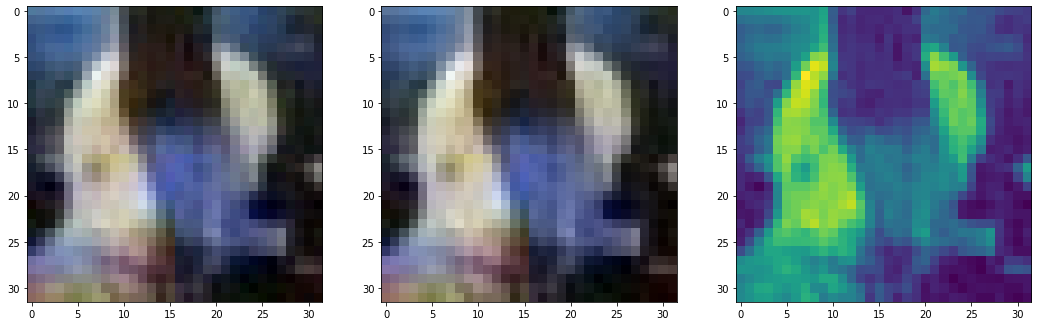

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2940, Total loss 0.000548


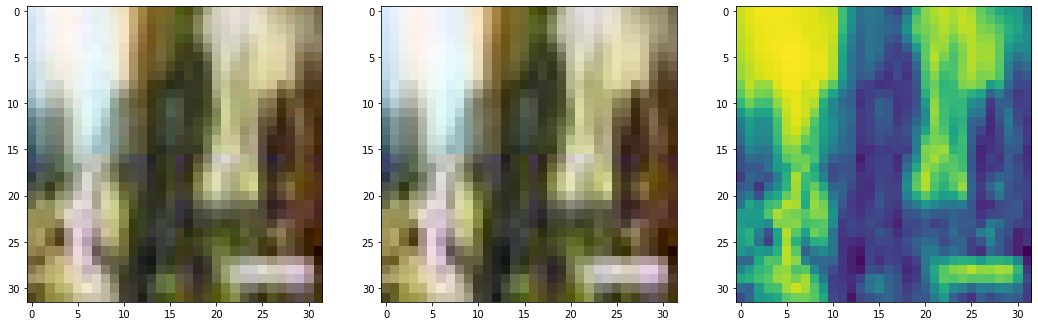

Step 2950, Total loss 0.000550


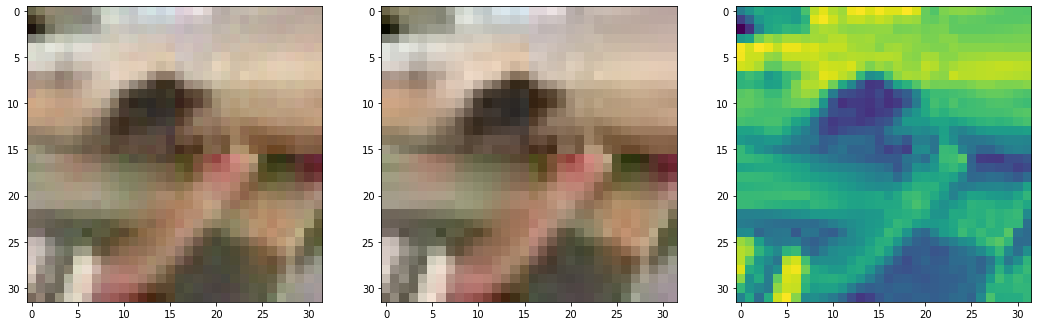

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2960, Total loss 0.000579


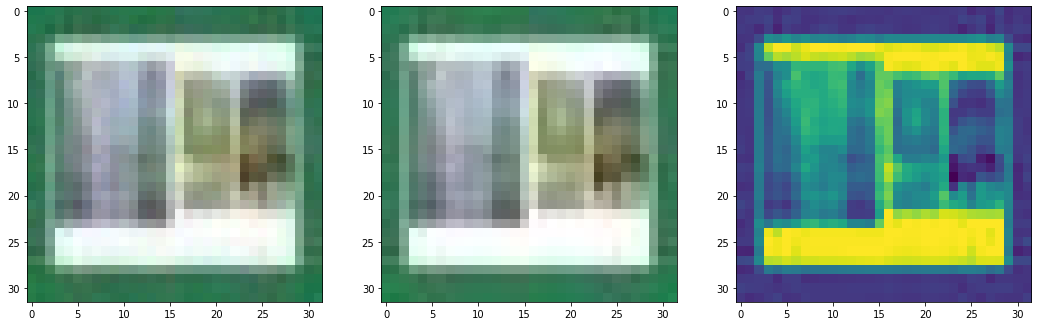

Step 2970, Total loss 0.000441


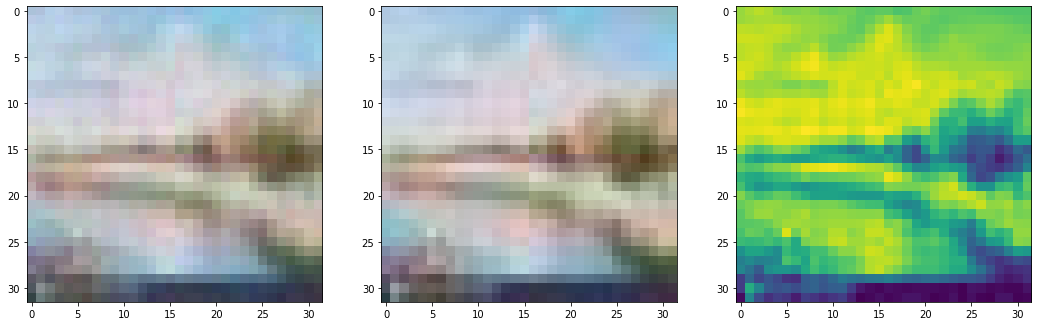

Step 2980, Total loss 0.000488


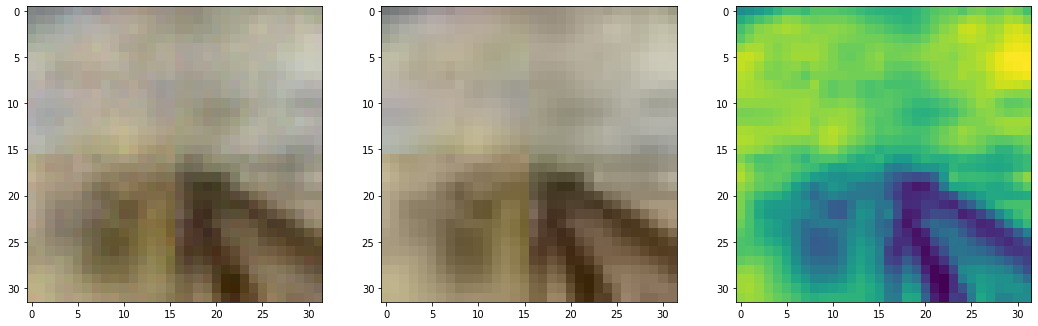

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2990, Total loss 0.000532


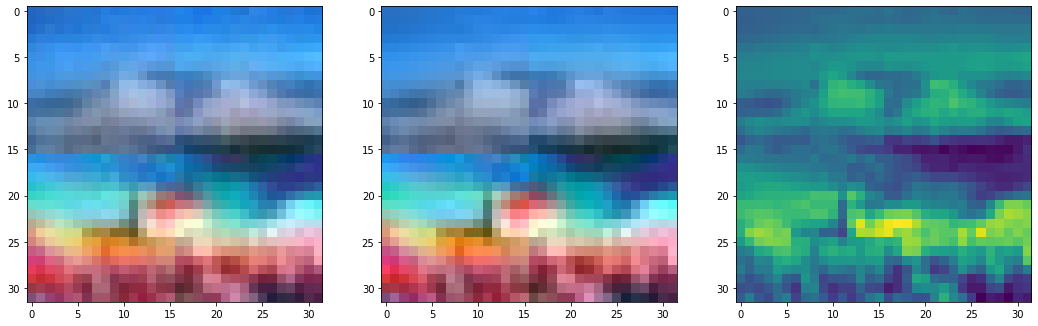

In [ ]:
total_steps = 3000 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10
batch_size=40

optim = torch.optim.Adam(lr=3e-6, params=img_siren.parameters())

for step in range(total_steps):
    
    input=torch.zeros((batch_size, sidelength**2))
    aim_output=torch.zeros((batch_size, 3*sidelength**2))
    for k in range(batch_size):
        image_index=random.randint(0, nb_images-20)
        img_input=transform_reshape(Image.open("imgs/bw/"+str(image_index)+".jpg"))
        img_aim_output=transform_reshape(Image.open("imgs/rgb/"+str(image_index)+".jpg"))

        input[k, :]=img_input
        #print(aim_output.size(), img_aim_output.size())
        aim_output[k, :]=img_aim_output



    model_output, coords = img_siren(input)
    #print("Output size: ", model_output.size())
    #print("Groundtruth size: ", ground_truth.size())
    
    loss = ((model_output - aim_output)**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        #print("Size image: ", model_output.cpu()[:1, :16384, :].size())
        
        axes[0].imshow(model_output[0, :].cpu().reshape(3, sidelength,sidelength).detach().permute(1, 2, 0).numpy())
        axes[1].imshow(aim_output[0, :].cpu().reshape(3, sidelength,sidelength).detach().permute(1, 2, 0).numpy())
        axes[2].imshow(input[0, :].cpu().reshape(sidelength,sidelength).detach().numpy())
        plt.show()
        #print(model_output.cpu().reshape(sidelength,sidelength, 3).size())
        #print(model_output.cpu().reshape(sidelength,sidelength, 3).detach().numpy().shape)

    optim.zero_grad()
    loss.backward()
    optim.step()
    losses.append(loss)

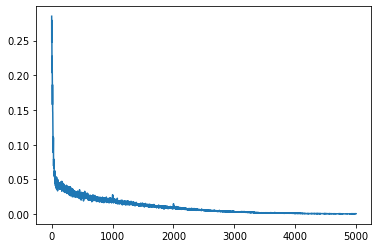

In [ ]:
plt.plot(losses)

Testing: we use images different from training, and compare the result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total loss 0.038015


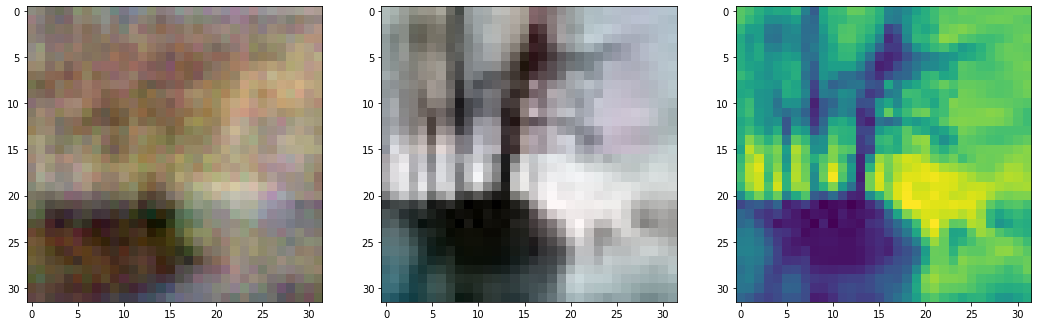

Step 1, Total loss 0.016744


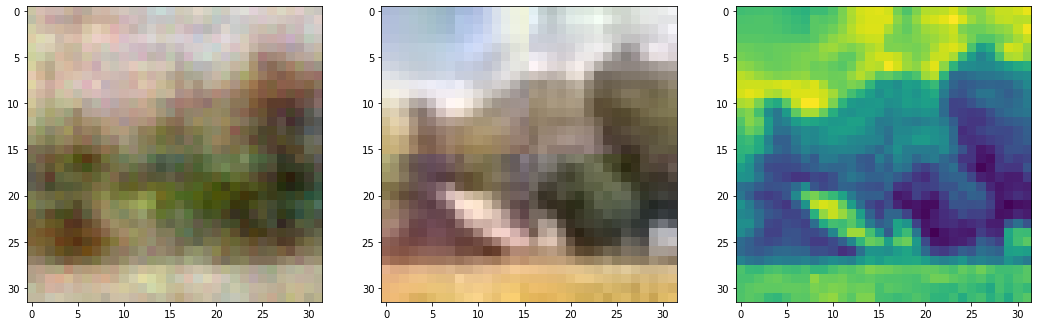

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2, Total loss 0.010803


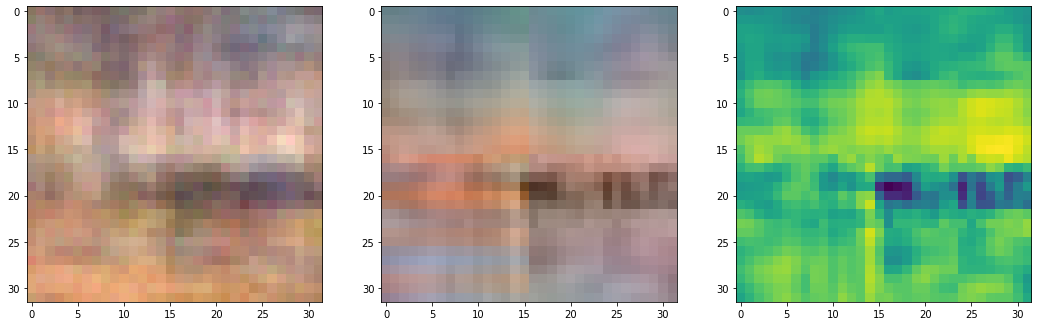

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3, Total loss 0.010803


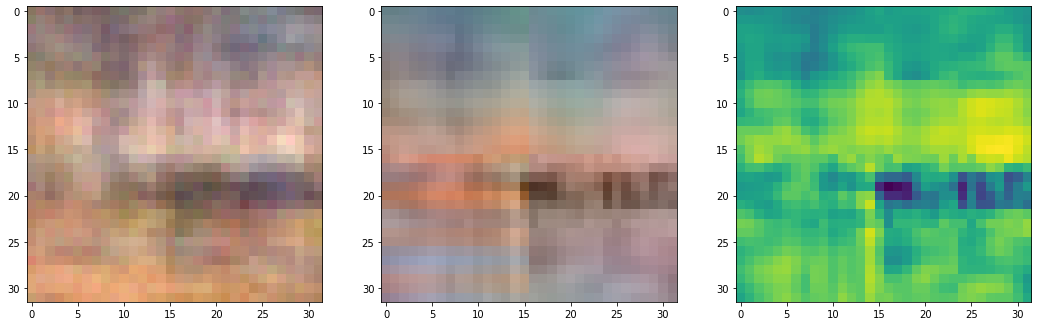

Step 4, Total loss 0.016744


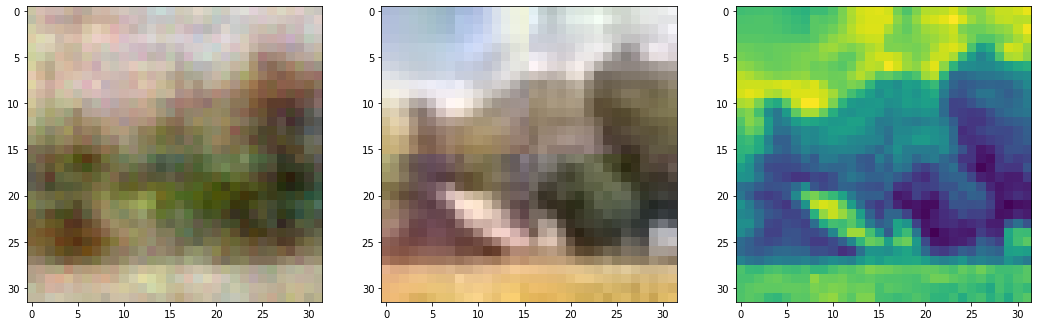

Step 5, Total loss 0.016744


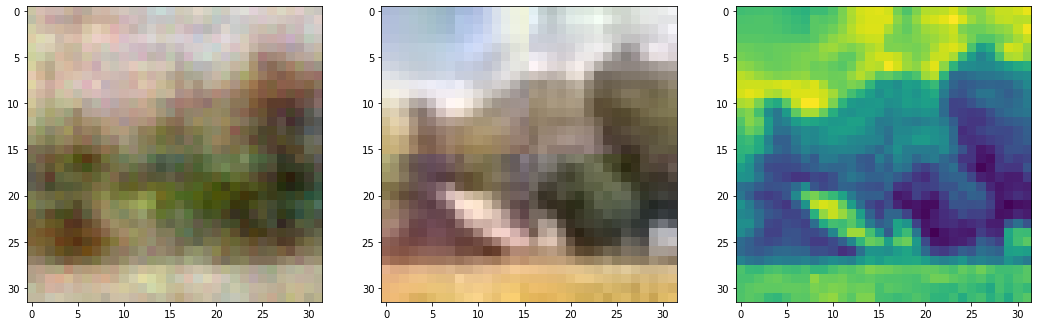

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 6, Total loss 0.030472


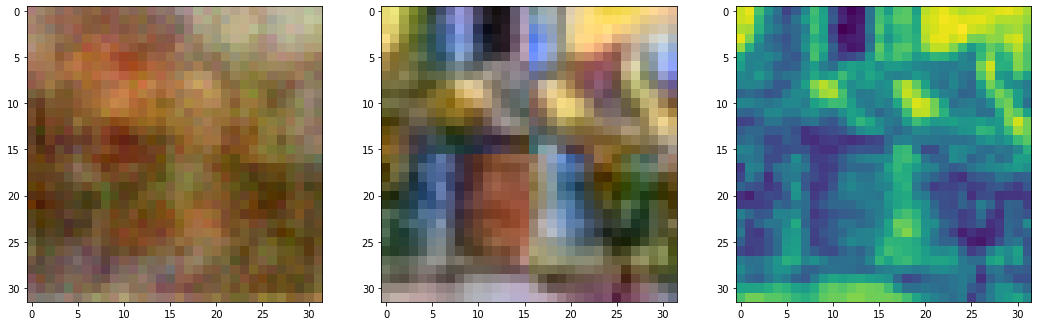

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 7, Total loss 0.019350


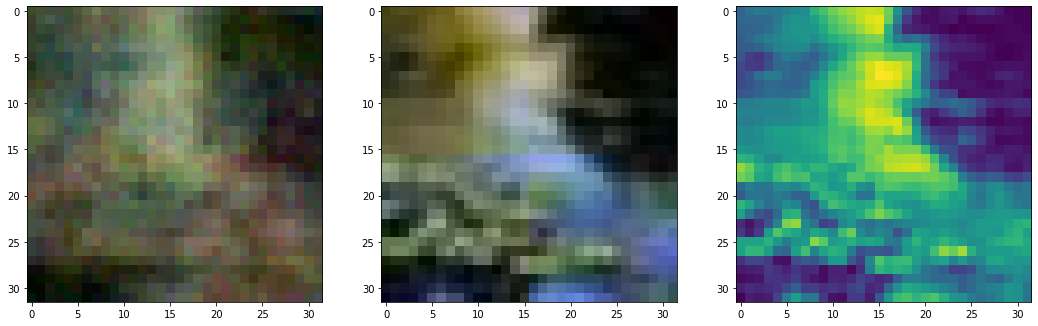

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 8, Total loss 0.015091


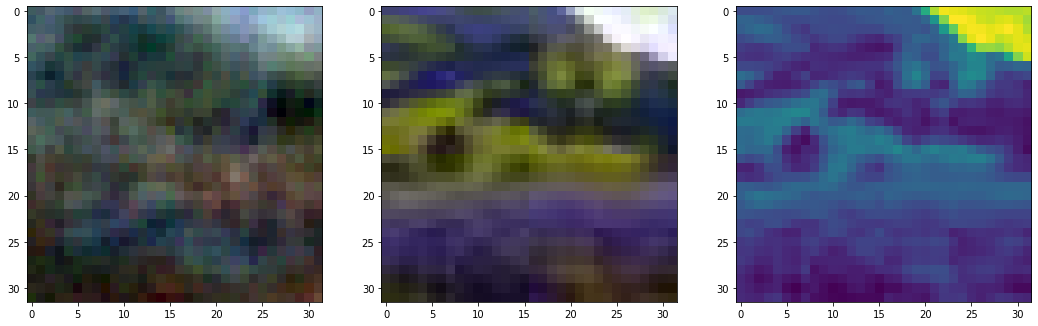

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 9, Total loss 0.011856


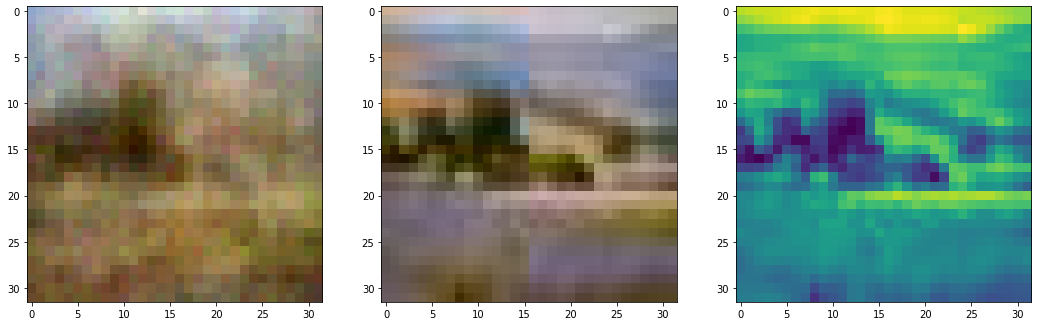

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 10, Total loss 0.005337


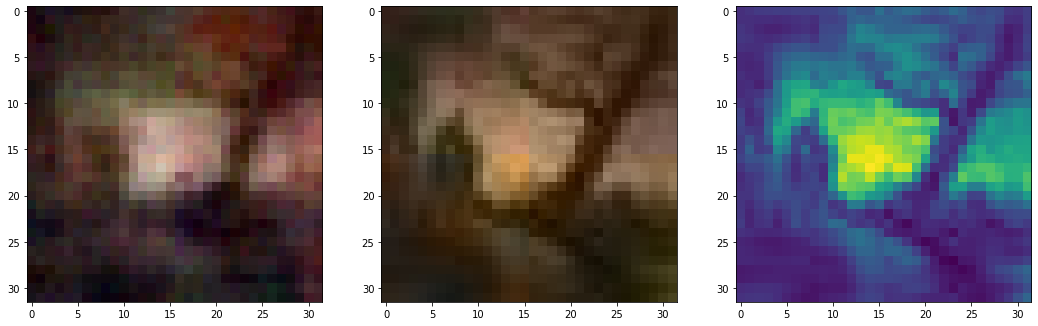

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 11, Total loss 0.013635


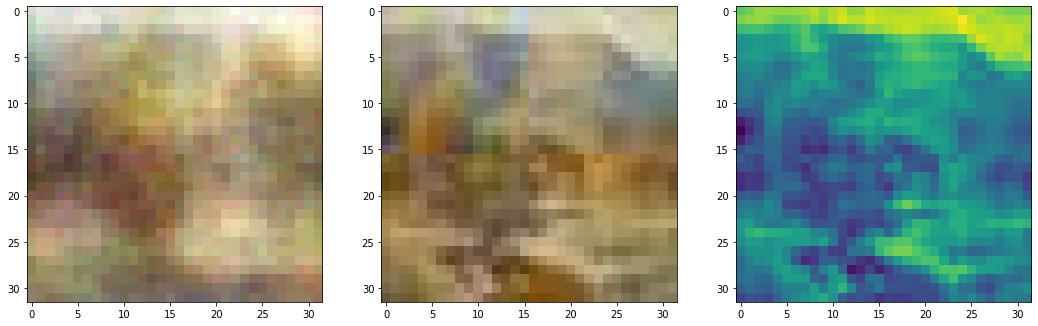

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 12, Total loss 0.023450


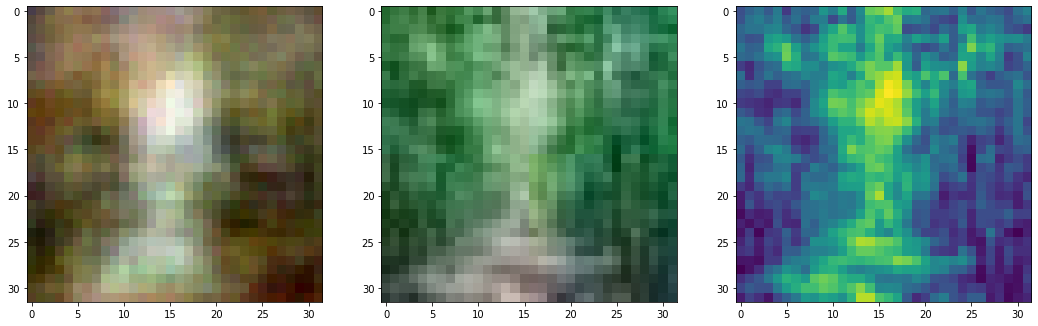

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 13, Total loss 0.015091


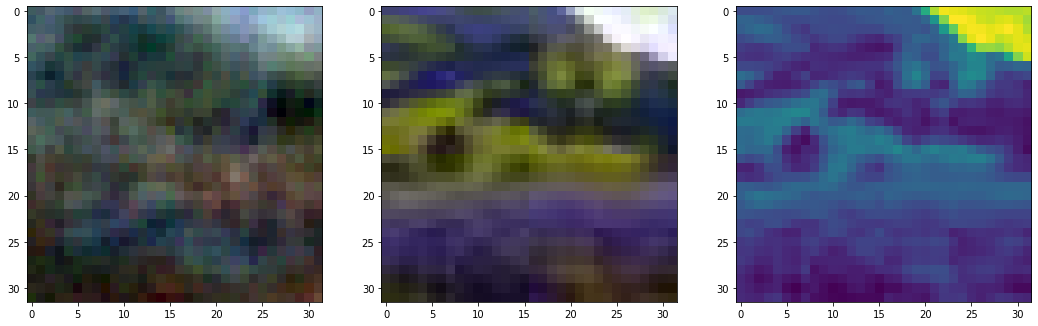

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 14, Total loss 0.025393


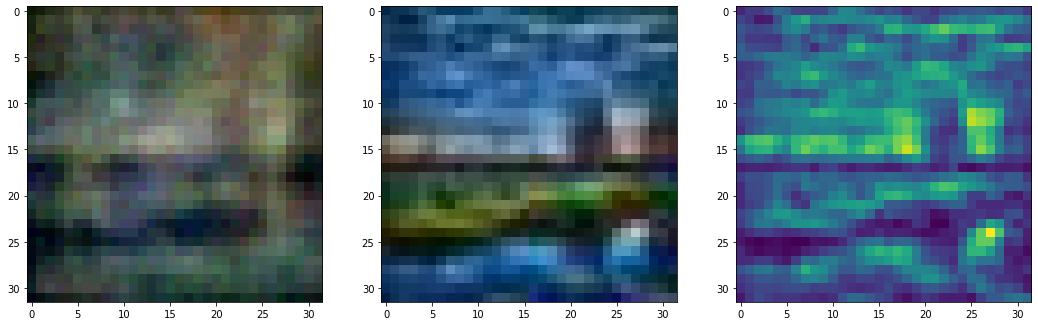

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 15, Total loss 0.015091


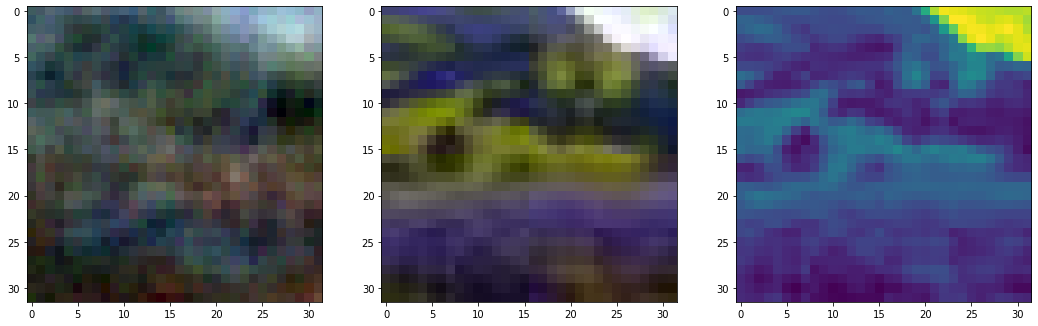

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 16, Total loss 0.025393


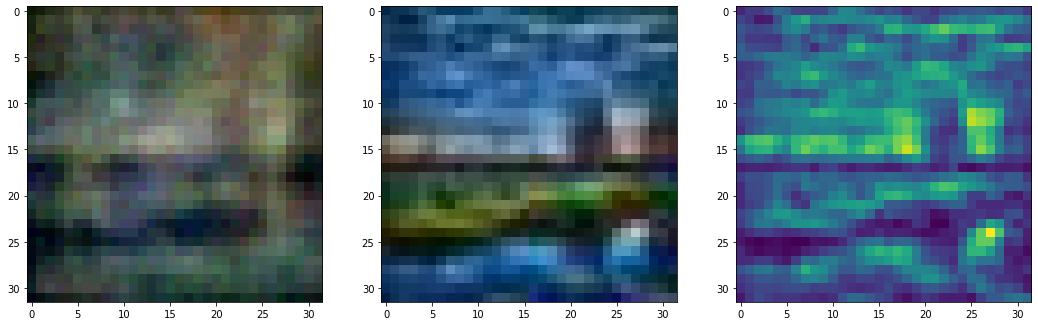

Step 17, Total loss 0.021511


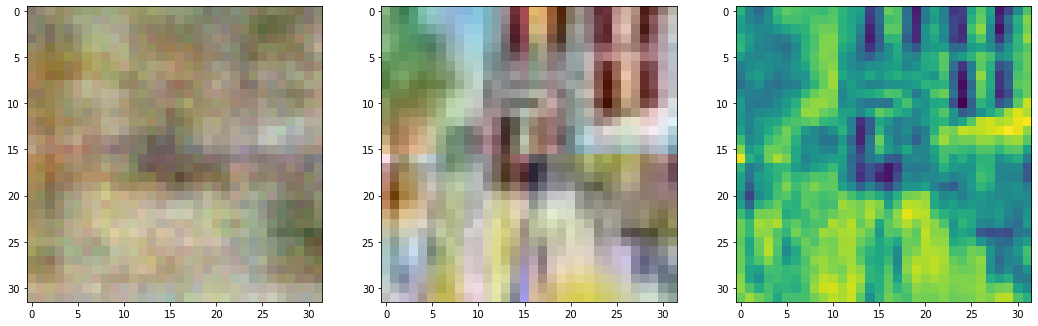

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 18, Total loss 0.013325


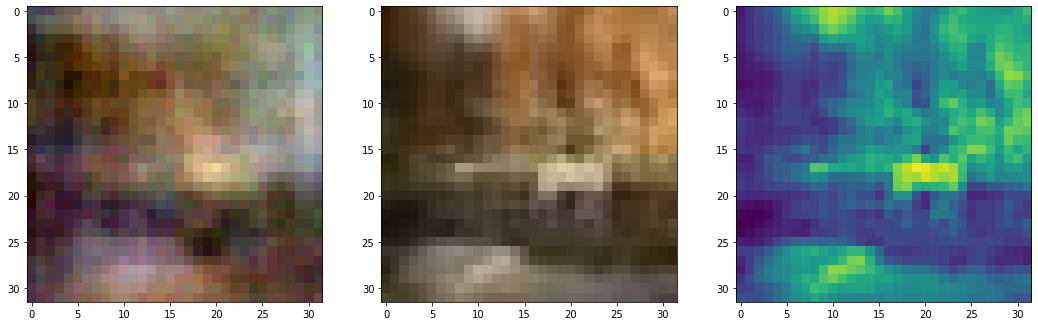

Step 19, Total loss 0.016744


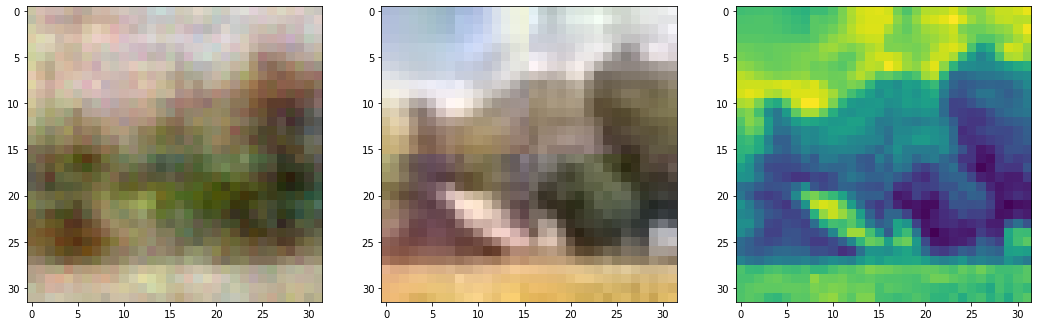

In [ ]:
total_steps = 20 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 1
batch_size=1

optim = torch.optim.Adam(lr=3e-6, params=img_siren.parameters())

for step in range(total_steps):
    
    input=torch.zeros((batch_size, sidelength**2))
    aim_output=torch.zeros((batch_size, 3*sidelength**2))
    for k in range(batch_size):
        image_index=random.randint(nb_images-19, nb_images-1)
        img_input=transform_reshape(Image.open("imgs/bw/"+str(image_index)+".jpg"))
        img_aim_output=transform_reshape(Image.open("imgs/rgb/"+str(image_index)+".jpg"))

        input[k, :]=img_input
        #print(aim_output.size(), img_aim_output.size())
        aim_output[k, :]=img_aim_output



    model_output, coords = img_siren(input)
    #print("Output size: ", model_output.size())
    #print("Groundtruth size: ", ground_truth.size())
    
    loss = ((model_output - aim_output)**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        #print("Size image: ", model_output.cpu()[:1, :16384, :].size())
        
        axes[0].imshow(model_output[0, :].cpu().reshape(3, sidelength,sidelength).detach().permute(1, 2, 0).numpy())
        axes[1].imshow(aim_output[0, :].cpu().reshape(3, sidelength,sidelength).detach().permute(1, 2, 0).numpy())
        axes[2].imshow(input[0, :].cpu().reshape(sidelength,sidelength).detach().numpy())
        plt.show()
        #print(model_output.cpu().reshape(sidelength,sidelength, 3).size())
        #print(model_output.cpu().reshape(sidelength,sidelength, 3).detach().numpy().shape)

    #optim.zero_grad()
    #loss.backward()
    #optim.step()
    #losses.append(loss)